In [1]:
# start with the libraries
# get environment information

import sys
print(sys.version)
print(sys.executable)

3.6.9 |Anaconda, Inc.| (default, Jul 30 2019, 13:42:17) 
[GCC 4.2.1 Compatible Clang 4.0.1 (tags/RELEASE_401/final)]
//anaconda3/envs/timeseries36/bin/python


In [2]:
# import the base libraries
# standard libraries
import pandas as pd
import numpy as np
from pandas import Series, DataFrame
import os
import math
from itertools import cycle
import datetime
from datetime import datetime as dt
from datetime import timedelta

# plotting libraries
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# to visualize all of the columns in the dataframe
pd.pandas.set_option('display.max_columns', None)
pd.options.display.float_format = '{:,.2f}'.format

import re
import csv
import json
import ast
from pandas.io.json import json_normalize

pd.options.display.max_colwidth = 2000
pd.set_option('display.max_rows', 100)


# for database connectivity
import psycopg2
import getpass

print(os.getcwd())

/Users/bryanbutler/Documents/Python/Forecasting/EWS


In [3]:
# user
# stream=sys.stderr
uid = getpass.getpass()

········


In [6]:
# pwd

pwd = getpass.getpass()

········


In [7]:
# connection

con=psycopg2.connect(dbname= 'dw_main', host='rs-prd-bi-cluster.cdw0722fdg2r.us-east-1.redshift.amazonaws.com', 
port= '5439', user= uid, password= pwd)
# del uid, pwd
cursor = con.cursor()

In [8]:
# set the cutoff date

cutoff_date = '2020-01-01'

In [9]:
# query
# this is for all key EWS data
# check the end date

sql_query = """
SELECT
       CAST(lcad.date_ride AS date) AS date_ride,
       CASE WHEN dt.holiday_flag LIKE 'Y' THEN 1 ELSE 0 END AS holiday,
       lcad.call_center_state,
       COUNT(DISTINCT lcad.ride_key) AS gross_rides,
       COUNT(distinct CASE WHEN lcad.ride_status = 'Verified-Paid' THEN lcad.ride_key ELSE NULL END) AS verified_paid_rides,
       SUM(CASE WHEN lcad.ride_status = 'Verified-Paid' THEN lcad.cost_usd ELSE 0 END ) AS verified_paid_costs,
       SUM(CASE WHEN lcad.ride_status = 'Verified-Paid' THEN lcad.miles ELSE 0 END ) AS verified_paid_miles,
       
       count(distinct CASE WHEN lcad.los_group_desc = 'Ambulatory' THEN lcad.ride_key ELSE NULL END) AS verified_paid_ambulatory_rides,
       SUM(CASE WHEN lcad.los_group_desc = 'Ambulatory' THEN lcad.cost_usd ELSE NULL END) AS verified_paid_ambulatory_costs,
       SUM(CASE WHEN lcad.los_group_desc = 'Ambulatory' THEN lcad.miles ELSE NULL END) AS verified_paid_ambulatory_miles,
       
       count(distinct CASE WHEN lcad.los_group_desc = 'Stretcher' THEN lcad.ride_key ELSE NULL END) AS verified_paid_stretcher_rides,
       SUM(CASE WHEN lcad.los_group_desc = 'Stretcher' THEN lcad.cost_usd ELSE NULL END) AS verified_paid_stretcher_costs,
       SUM(CASE WHEN lcad.los_group_desc = 'Stretcher' THEN lcad.miles ELSE NULL END) AS verified_paid_stretcher_miles,
       
       count(distinct CASE WHEN lcad.los_group_desc = 'Wheelchair' THEN lcad.ride_key ELSE NULL END) AS verified_paid_wheelchair_rides,
       SUM(CASE WHEN lcad.los_group_desc = 'Wheelchair' THEN lcad.cost_usd ELSE NULL END) AS verified_paid_wheelchair_costs,
       SUM(CASE WHEN lcad.los_group_desc = 'Wheelchair' THEN lcad.miles ELSE NULL END) AS verified_paid_wheelchair_miles,
       
       count(distinct lcad.rider_code) AS Riders

FROM dw.fact_lcad_ride lcad

LEFT JOIN dw.dim_date dt
    ON lcad.date_dim_id = dt.date_dim_id
WHERE
      provider_type_name NOT IN ('Public Transit', 'Gas Reimbursement', 'Unassigned')
  AND provider_type_name IS NOT NULL
  AND date(date_ride) < %s 
  AND lcad.provider_is_lcad = 'LCAD'
  AND lcad.broker_client_contract_type != 'FFS'
  AND lcad.los_group_desc in ('Ambulatory' , 'Wheelchair', 'Stretcher')
GROUP BY date_ride, holiday, call_center_state
ORDER BY date_ride

""" 

In [10]:
data = pd.read_sql_query(sql = sql_query, con = con, params = [cutoff_date])
data.head()

,date_ride,holiday,call_center_state,gross_rides,verified_paid_rides,verified_paid_costs,verified_paid_miles,verified_paid_ambulatory_rides,verified_paid_ambulatory_costs,verified_paid_ambulatory_miles,verified_paid_stretcher_rides,verified_paid_stretcher_costs,verified_paid_stretcher_miles,verified_paid_wheelchair_rides,verified_paid_wheelchair_costs,verified_paid_wheelchair_miles,riders
0,2014-01-01,1,HI,765,8,480.65,162,463,365.25,"4,154.00",2,0.00,4.00,300,115.40,"2,162.00",387
1,2014-01-01,1,MO,881,451,"14,106.09",6738,587,"7,411.61","8,524.00",5,829.20,49.00,289,"5,865.28","3,693.00",439
2,2014-01-01,1,AZ,303,64,"1,778.93",814,98,390.07,819.00,10,0.00,51.00,195,"1,388.86","1,400.00",153
3,2014-01-01,1,AR,2,2,366.60,92,2,366.60,92.00,0,nan,nan,0,nan,nan,1
4,2014-01-01,1,CA,242,30,"1,040.62",331,153,999.58,"1,139.00",27,0.00,165.00,62,41.04,290.00,128


In [11]:
data.tail()

,date_ride,holiday,call_center_state,gross_rides,verified_paid_rides,verified_paid_costs,verified_paid_miles,verified_paid_ambulatory_rides,verified_paid_ambulatory_costs,verified_paid_ambulatory_miles,verified_paid_stretcher_rides,verified_paid_stretcher_costs,verified_paid_stretcher_miles,verified_paid_wheelchair_rides,verified_paid_wheelchair_costs,verified_paid_wheelchair_miles,riders
75915,2019-12-31,0,LA,3387,1767,"70,035.71",29546,3083,"48,622.05","43,318.00",35,"14,457.84","2,060.00",269,"6,955.82","1,856.00",1681
75916,2019-12-31,0,WI,130,99,"3,043.40",862,120,"2,825.40","1,088.00",0,nan,nan,10,218.00,68.00,65
75917,2019-12-31,0,HI,896,465,"12,009.65",3990,549,"7,624.55","6,172.00",6,260.80,37.00,341,"4,124.30","1,761.00",449
75918,2019-12-31,0,SC,7499,4130,"134,768.32",69887,6409,"102,656.25","101,954.00",83,"11,417.25","1,399.00",1007,"20,694.82","15,688.00",3687
75919,2019-12-31,0,OH,2439,1552,"64,609.74",16070,1814,"34,272.92","19,096.00",99,"14,422.60",636.00,526,"15,914.22","3,597.00",1196


In [12]:
# replace all NaN with 0
df = data.copy()

df = df.fillna(0)
df.head()

,date_ride,holiday,call_center_state,gross_rides,verified_paid_rides,verified_paid_costs,verified_paid_miles,verified_paid_ambulatory_rides,verified_paid_ambulatory_costs,verified_paid_ambulatory_miles,verified_paid_stretcher_rides,verified_paid_stretcher_costs,verified_paid_stretcher_miles,verified_paid_wheelchair_rides,verified_paid_wheelchair_costs,verified_paid_wheelchair_miles,riders
0,2014-01-01,1,HI,765,8,480.65,162,463,365.25,"4,154.00",2,0.00,4.00,300,115.40,"2,162.00",387
1,2014-01-01,1,MO,881,451,"14,106.09",6738,587,"7,411.61","8,524.00",5,829.20,49.00,289,"5,865.28","3,693.00",439
2,2014-01-01,1,AZ,303,64,"1,778.93",814,98,390.07,819.00,10,0.00,51.00,195,"1,388.86","1,400.00",153
3,2014-01-01,1,AR,2,2,366.60,92,2,366.60,92.00,0,0.00,0.00,0,0.00,0.00,1
4,2014-01-01,1,CA,242,30,"1,040.62",331,153,999.58,"1,139.00",27,0.00,165.00,62,41.04,290.00,128


In [13]:
# convert date_ride to date and set as index
# only do this for direct SQL pull

# make a date
df['date_ride'] = pd.to_datetime(df['date_ride'], format='%Y-%m-%d')

# set the index
df = df.set_index(df['date_ride'])

df.head()

,date_ride,holiday,call_center_state,gross_rides,verified_paid_rides,verified_paid_costs,verified_paid_miles,verified_paid_ambulatory_rides,verified_paid_ambulatory_costs,verified_paid_ambulatory_miles,verified_paid_stretcher_rides,verified_paid_stretcher_costs,verified_paid_stretcher_miles,verified_paid_wheelchair_rides,verified_paid_wheelchair_costs,verified_paid_wheelchair_miles,riders
date_ride,,,,,,,,,,,,,,,,,
2014-01-01,2014-01-01,1,HI,765,8,480.65,162,463,365.25,"4,154.00",2,0.00,4.00,300,115.40,"2,162.00",387
2014-01-01,2014-01-01,1,MO,881,451,"14,106.09",6738,587,"7,411.61","8,524.00",5,829.20,49.00,289,"5,865.28","3,693.00",439
2014-01-01,2014-01-01,1,AZ,303,64,"1,778.93",814,98,390.07,819.00,10,0.00,51.00,195,"1,388.86","1,400.00",153
2014-01-01,2014-01-01,1,AR,2,2,366.60,92,2,366.60,92.00,0,0.00,0.00,0,0.00,0.00,1
2014-01-01,2014-01-01,1,CA,242,30,"1,040.62",331,153,999.58,"1,139.00",27,0.00,165.00,62,41.04,290.00,128


In [14]:
# convert data to monthly format

# weekly sample drops call center state
mdf = df.resample('M').aggregate({'holiday': np.max,
                                  'gross_rides': np.sum,
                                  'verified_paid_rides': np.sum,
                                  'verified_paid_costs': np.sum,
                                  'verified_paid_miles': np.sum,
                                  'verified_paid_ambulatory_rides': np.sum,
                                  'verified_paid_ambulatory_costs': np.sum,
                                  'verified_paid_ambulatory_miles': np.sum,
                                  'verified_paid_stretcher_rides': np.sum,
                                  'verified_paid_stretcher_costs': np.sum,
                                  'verified_paid_stretcher_miles': np.sum,
                                  'verified_paid_wheelchair_rides': np.sum,
                                  'verified_paid_wheelchair_costs': np.sum,
                                  'verified_paid_wheelchair_miles': np.sum,
                                  'riders': np.sum})
mdf.head()

,holiday,gross_rides,verified_paid_rides,verified_paid_costs,verified_paid_miles,verified_paid_ambulatory_rides,verified_paid_ambulatory_costs,verified_paid_ambulatory_miles,verified_paid_stretcher_rides,verified_paid_stretcher_costs,verified_paid_stretcher_miles,verified_paid_wheelchair_rides,verified_paid_wheelchair_costs,verified_paid_wheelchair_miles,riders
date_ride,,,,,,,,,,,,,,,
2014-01-31,1,3266864,1812991,"44,664,109.34",22449187,2714779,"32,411,517.29","29,804,358.00",60285,"2,718,355.07","572,595.00",491800,"9,534,236.98","4,385,262.00",1606432
2014-02-28,0,2993974,1685122,"41,089,164.36",20819875,2493248,"29,801,203.27","27,346,991.00",55181,"2,504,945.82","526,193.00",445545,"8,783,015.27","3,961,913.00",1472782
2014-03-31,0,3205898,1893825,"46,585,527.22",23252181,2667745,"33,799,351.99","28,950,447.00",59492,"2,772,694.53","570,429.00",478661,"10,013,480.70","4,235,875.00",1576993
2014-04-30,0,3289795,2010816,"49,504,202.40",24991323,2745234,"36,064,796.83","30,244,156.00",59824,"2,927,813.57","568,918.00",484737,"10,511,592.00","4,320,817.00",1617823
2014-05-31,1,3368092,2047008,"50,664,380.42",25085063,2813606,"36,997,901.58","30,665,061.00",62203,"2,986,877.75","581,866.00",492283,"10,679,601.09","4,333,808.00",1655666


In [15]:
mdf.tail()

,holiday,gross_rides,verified_paid_rides,verified_paid_costs,verified_paid_miles,verified_paid_ambulatory_rides,verified_paid_ambulatory_costs,verified_paid_ambulatory_miles,verified_paid_stretcher_rides,verified_paid_stretcher_costs,verified_paid_stretcher_miles,verified_paid_wheelchair_rides,verified_paid_wheelchair_costs,verified_paid_wheelchair_miles,riders
date_ride,,,,,,,,,,,,,,,
2019-08-31,0,4039743,2794334,"86,343,328.24",34281518,3367033,"60,146,357.54","41,763,354.00",70400,"8,317,467.27","667,867.00",602310,"17,879,503.43","5,551,020.00",1964968
2019-09-30,1,3776400,2576692,"79,569,926.29",31582519,3148164,"55,546,203.82","39,187,478.00",66252,"7,685,509.38","629,608.00",561984,"16,338,213.09","5,183,662.00",1836466
2019-10-31,0,4240488,2936311,"90,243,326.58",36031789,3542612,"63,279,436.23","43,985,597.00",72613,"8,632,855.40","696,497.00",625263,"18,331,034.95","5,759,053.00",2058689
2019-11-30,1,3849042,2541229,"78,230,431.85",30705614,3195158,"54,065,065.73","38,968,414.00",68149,"7,810,323.37","637,964.00",585735,"16,355,042.75","5,260,985.00",1870469
2019-12-31,1,3887532,2475941,"76,672,090.51",29936786,3208664,"53,058,535.19","38,815,281.00",73195,"7,658,671.19","657,451.00",605673,"15,954,884.13","5,345,872.00",1891026


In [16]:
# import all of the stats functions to be used

import timeseries_module_monthly as ts

In [18]:
# write to CSV
# all_forecasts.to_csv('wide_ews_fcast_' + dt_str + '.csv', index = False)
mdf_csv = mdf.copy()
mdf_csv.reset_index(inplace = True)
mdf_csv.to_csv('monthly_data_Feb2020.csv')


In [19]:
# get the oos data 
oos = pd.read_csv('service_days.csv', index_col='end_month', parse_dates = True)
oos.head()

,year_code,month_of_year,num_holidays,num_weekends,num_days,service_days
end_month,,,,,,
2014-01-31,2014,1,1,8,31,22.50
2014-02-28,2014,2,0,8,28,20.00
2014-03-31,2014,3,0,10,31,21.00
2014-04-30,2014,4,0,8,30,22.00
2014-05-31,2014,5,1,9,31,21.50


In [20]:
oos.tail()

,year_code,month_of_year,num_holidays,num_weekends,num_days,service_days
end_month,,,,,,
2020-08-29,2020,8,0,10,24,14.00
2020-09-29,2020,9,1,8,21,12.50
2020-10-31,2020,10,0,9,30,21.00
2020-11-30,2020,11,1,9,26,16.50
2020-12-31,2020,12,1,8,31,22.50


In [21]:
# reduce oos to key values
oos = oos[['service_days']]
oos.head()

,service_days
end_month,
2014-01-31,22.50
2014-02-28,20.00
2014-03-31,21.00
2014-04-30,22.00
2014-05-31,21.50


In [22]:
# clean up the verified_paid portion to vp

mdf.columns = mdf.columns.str.replace('verified_paid','vp')
mdf.head()

,holiday,gross_rides,vp_rides,vp_costs,vp_miles,vp_ambulatory_rides,vp_ambulatory_costs,vp_ambulatory_miles,vp_stretcher_rides,vp_stretcher_costs,vp_stretcher_miles,vp_wheelchair_rides,vp_wheelchair_costs,vp_wheelchair_miles,riders
date_ride,,,,,,,,,,,,,,,
2014-01-31,1,3266864,1812991,"44,664,109.34",22449187,2714779,"32,411,517.29","29,804,358.00",60285,"2,718,355.07","572,595.00",491800,"9,534,236.98","4,385,262.00",1606432
2014-02-28,0,2993974,1685122,"41,089,164.36",20819875,2493248,"29,801,203.27","27,346,991.00",55181,"2,504,945.82","526,193.00",445545,"8,783,015.27","3,961,913.00",1472782
2014-03-31,0,3205898,1893825,"46,585,527.22",23252181,2667745,"33,799,351.99","28,950,447.00",59492,"2,772,694.53","570,429.00",478661,"10,013,480.70","4,235,875.00",1576993
2014-04-30,0,3289795,2010816,"49,504,202.40",24991323,2745234,"36,064,796.83","30,244,156.00",59824,"2,927,813.57","568,918.00",484737,"10,511,592.00","4,320,817.00",1617823
2014-05-31,1,3368092,2047008,"50,664,380.42",25085063,2813606,"36,997,901.58","30,665,061.00",62203,"2,986,877.75","581,866.00",492283,"10,679,601.09","4,333,808.00",1655666


In [23]:
mdf.tail()

,holiday,gross_rides,vp_rides,vp_costs,vp_miles,vp_ambulatory_rides,vp_ambulatory_costs,vp_ambulatory_miles,vp_stretcher_rides,vp_stretcher_costs,vp_stretcher_miles,vp_wheelchair_rides,vp_wheelchair_costs,vp_wheelchair_miles,riders
date_ride,,,,,,,,,,,,,,,
2019-08-31,0,4039743,2794334,"86,343,328.24",34281518,3367033,"60,146,357.54","41,763,354.00",70400,"8,317,467.27","667,867.00",602310,"17,879,503.43","5,551,020.00",1964968
2019-09-30,1,3776400,2576692,"79,569,926.29",31582519,3148164,"55,546,203.82","39,187,478.00",66252,"7,685,509.38","629,608.00",561984,"16,338,213.09","5,183,662.00",1836466
2019-10-31,0,4240488,2936311,"90,243,326.58",36031789,3542612,"63,279,436.23","43,985,597.00",72613,"8,632,855.40","696,497.00",625263,"18,331,034.95","5,759,053.00",2058689
2019-11-30,1,3849042,2541229,"78,230,431.85",30705614,3195158,"54,065,065.73","38,968,414.00",68149,"7,810,323.37","637,964.00",585735,"16,355,042.75","5,260,985.00",1870469
2019-12-31,1,3887532,2475941,"76,672,090.51",29936786,3208664,"53,058,535.19","38,815,281.00",73195,"7,658,671.19","657,451.00",605673,"15,954,884.13","5,345,872.00",1891026


In [24]:
# create cost per mile

mdf['cpm'] = mdf['vp_costs']/mdf['vp_miles']

In [25]:
# add the service days to the monthly data
# create service days in train
# train['service_days'] = oos.iloc[0:end + 1]

mdf['service_days'] = oos.iloc[0: len(mdf) + 1]
mdf.tail()

,holiday,gross_rides,vp_rides,vp_costs,vp_miles,vp_ambulatory_rides,vp_ambulatory_costs,vp_ambulatory_miles,vp_stretcher_rides,vp_stretcher_costs,vp_stretcher_miles,vp_wheelchair_rides,vp_wheelchair_costs,vp_wheelchair_miles,riders,cpm,service_days
date_ride,,,,,,,,,,,,,,,,,
2019-08-31,0,4039743,2794334,"86,343,328.24",34281518,3367033,"60,146,357.54","41,763,354.00",70400,"8,317,467.27","667,867.00",602310,"17,879,503.43","5,551,020.00",1964968,2.52,22.00
2019-09-30,1,3776400,2576692,"79,569,926.29",31582519,3148164,"55,546,203.82","39,187,478.00",66252,"7,685,509.38","629,608.00",561984,"16,338,213.09","5,183,662.00",1836466,2.52,20.50
2019-10-31,0,4240488,2936311,"90,243,326.58",36031789,3542612,"63,279,436.23","43,985,597.00",72613,"8,632,855.40","696,497.00",625263,"18,331,034.95","5,759,053.00",2058689,2.50,23.00
2019-11-30,1,3849042,2541229,"78,230,431.85",30705614,3195158,"54,065,065.73","38,968,414.00",68149,"7,810,323.37","637,964.00",585735,"16,355,042.75","5,260,985.00",1870469,2.55,20.50
2019-12-31,1,3887532,2475941,"76,672,090.51",29936786,3208664,"53,058,535.19","38,815,281.00",73195,"7,658,671.19","657,451.00",605673,"15,954,884.13","5,345,872.00",1891026,2.56,21.50


In [26]:
print(cutoff_date)

2020-01-01


In [29]:
# cut the data for verifiedd paid lag of ~ 66 days

vp_lag_days = 66

vp_lag_wks = int(vp_lag_days/31)

# vp_lag_wks


vpdf = mdf.iloc[:-vp_lag_wks-1]
vpdf.tail()

,holiday,gross_rides,vp_rides,vp_costs,vp_miles,vp_ambulatory_rides,vp_ambulatory_costs,vp_ambulatory_miles,vp_stretcher_rides,vp_stretcher_costs,vp_stretcher_miles,vp_wheelchair_rides,vp_wheelchair_costs,vp_wheelchair_miles,riders,cpm,service_days
date_ride,,,,,,,,,,,,,,,,,
2019-05-31,1,4022536,2755164,"85,129,079.59",33336354,3347126,"58,968,223.56","41,095,981.00",71683,"8,505,088.47","677,657.00",603727,"17,655,767.56","5,475,482.00",1953459,2.55,22.50
2019-06-30,0,3670446,2527202,"78,487,134.16",30724186,3057270,"54,449,688.96","37,668,728.00",65995,"7,734,064.72","623,924.00",547181,"16,303,380.48","4,953,991.00",1782552,2.55,20.00
2019-07-31,1,4034142,2749201,"84,936,755.02",33467833,3359899,"58,941,841.53","41,386,842.00",70930,"8,331,489.90","673,897.00",603313,"17,663,423.59","5,479,227.00",1960153,2.54,22.50
2019-08-31,0,4039743,2794334,"86,343,328.24",34281518,3367033,"60,146,357.54","41,763,354.00",70400,"8,317,467.27","667,867.00",602310,"17,879,503.43","5,551,020.00",1964968,2.52,22.00
2019-09-30,1,3776400,2576692,"79,569,926.29",31582519,3148164,"55,546,203.82","39,187,478.00",66252,"7,685,509.38","629,608.00",561984,"16,338,213.09","5,183,662.00",1836466,2.52,20.50


# Get the Data in the Adjudication Gap
## Use as test data for rides and riders

In [30]:
# -10 might overlap

test = mdf.iloc[-5:]
test

,holiday,gross_rides,vp_rides,vp_costs,vp_miles,vp_ambulatory_rides,vp_ambulatory_costs,vp_ambulatory_miles,vp_stretcher_rides,vp_stretcher_costs,vp_stretcher_miles,vp_wheelchair_rides,vp_wheelchair_costs,vp_wheelchair_miles,riders,cpm,service_days
date_ride,,,,,,,,,,,,,,,,,
2019-08-31,0,4039743,2794334,"86,343,328.24",34281518,3367033,"60,146,357.54","41,763,354.00",70400,"8,317,467.27","667,867.00",602310,"17,879,503.43","5,551,020.00",1964968,2.52,22.00
2019-09-30,1,3776400,2576692,"79,569,926.29",31582519,3148164,"55,546,203.82","39,187,478.00",66252,"7,685,509.38","629,608.00",561984,"16,338,213.09","5,183,662.00",1836466,2.52,20.50
2019-10-31,0,4240488,2936311,"90,243,326.58",36031789,3542612,"63,279,436.23","43,985,597.00",72613,"8,632,855.40","696,497.00",625263,"18,331,034.95","5,759,053.00",2058689,2.50,23.00
2019-11-30,1,3849042,2541229,"78,230,431.85",30705614,3195158,"54,065,065.73","38,968,414.00",68149,"7,810,323.37","637,964.00",585735,"16,355,042.75","5,260,985.00",1870469,2.55,20.50
2019-12-31,1,3887532,2475941,"76,672,090.51",29936786,3208664,"53,058,535.19","38,815,281.00",73195,"7,658,671.19","657,451.00",605673,"15,954,884.13","5,345,872.00",1891026,2.56,21.50


# Set the Forecast Horizon
## Full horizon to include verified paid gap

In [31]:
# change the index system

oos_exog = oos.loc['2019-08-31':'2020-03-31']

horizon = len(oos_exog)

oos_exog

,service_days
end_month,
2019-08-31,22.00
2019-09-30,20.50
2019-10-31,23.00
2019-11-30,20.50
2019-12-31,21.50
2020-01-31,22.50
2020-02-29,20.00
2020-03-31,22.00


In [32]:
# set up for forecasting and backtesting
# set the ranges
train = mdf.iloc[:-5].copy()

end = len(train)

train.tail()


,holiday,gross_rides,vp_rides,vp_costs,vp_miles,vp_ambulatory_rides,vp_ambulatory_costs,vp_ambulatory_miles,vp_stretcher_rides,vp_stretcher_costs,vp_stretcher_miles,vp_wheelchair_rides,vp_wheelchair_costs,vp_wheelchair_miles,riders,cpm,service_days
date_ride,,,,,,,,,,,,,,,,,
2019-03-31,0,3808520,2635798,"80,767,669.02",31517532,3170213,"56,018,531.77","38,456,142.00",69494,"8,317,764.26","658,331.00",568813,"16,431,372.99","5,119,040.00",1848637,2.56,21.00
2019-04-30,0,3910579,2699591,"83,101,224.67",32640249,3256350,"57,762,543.89","39,923,606.00",69876,"8,286,073.63","651,164.00",584353,"17,052,607.15","5,342,015.00",1899609,2.55,22.00
2019-05-31,1,4022536,2755164,"85,129,079.59",33336354,3347126,"58,968,223.56","41,095,981.00",71683,"8,505,088.47","677,657.00",603727,"17,655,767.56","5,475,482.00",1953459,2.55,22.50
2019-06-30,0,3670446,2527202,"78,487,134.16",30724186,3057270,"54,449,688.96","37,668,728.00",65995,"7,734,064.72","623,924.00",547181,"16,303,380.48","4,953,991.00",1782552,2.55,20.00
2019-07-31,1,4034142,2749201,"84,936,755.02",33467833,3359899,"58,941,841.53","41,386,842.00",70930,"8,331,489.90","673,897.00",603313,"17,663,423.59","5,479,227.00",1960153,2.54,22.50


# Gross Rides
## Uses VP Training Data

In [33]:
series = 'gross_rides'

In [35]:
train.index = pd.DatetimeIndex(train.index.values,
                               freq=train.index.inferred_freq)


model = ts.build_model(train[series],
                       p=1,
                       d=2,
                       q=0,
                       S=7,
                       exog_data = train['service_days'],
                       P=1,
                       D=1,
                       Q=1)

model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                
=========================================================================================
Dep. Variable:                       gross_rides   No. Observations:                   67
Model:             SARIMAX(1, 2, 0)x(1, 1, 1, 7)   Log Likelihood                -758.465
Date:                           Tue, 10 Mar 2020   AIC                           1526.931
Time:                                   15:49:47   BIC                           1537.233
Sample:                               01-31-2014   HQIC                          1530.944
                                    - 07-31-2019                                         
Covariance Type:                             opg                                         
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
service_days   1.31e+05   9923.499     13.205      0.000    1.12e+05     1.5e+05
ar.L1           -0.5038      0.162     -3.111      0.002      -0.821      -0.186
ar.S.L7          0.3962      0.292      1.358      0.174      -0.176       0.968
ma.S.L7         -0.8810      0.389     -2.267      0.023      -1.643      -0.119
sigma2        1.641e+10      0.001   2.03e+13      0.000    1.64e+10    1.64e+10
===================================================================================
Ljung-Box (Q):                       47.13   Jarque-Bera (JB):                 2.00
Prob(Q):                              0.20   Prob(JB):                         0.37
Heteroskedasticity (H):               0.83   Skew:                            -0.38
Prob(H) (two-sided):                  0.69   Kurtosis:                         3.51
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.21e+30. Standard errors may be unstable.
"""

In [36]:
ts.get_dw(model)

2.1362934912670144

In [37]:
backtest = ts.backtest_model(model,
                             train = train,
                             exog_data=train['service_days'][1:],
                             end = len(train)-1)

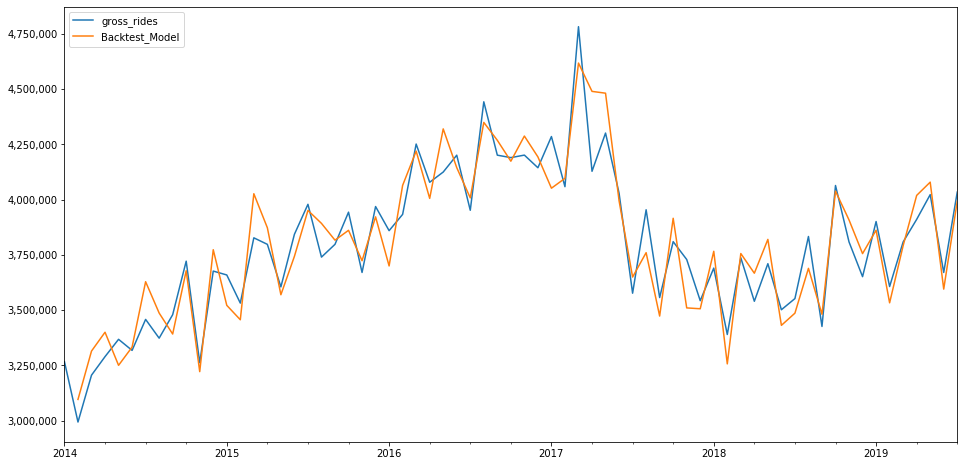

In [38]:
# make the backtest plot

plt.clf()

ts.plot_fit(train[series], backtest, train);

In [39]:
# make predictions

predictions = ts.make_predictions(model,
                               series + ' SARIMAX',
                               start=len(train),
                               end= len(train) + len(oos_exog)-1,
                               exog_data=oos_exog)

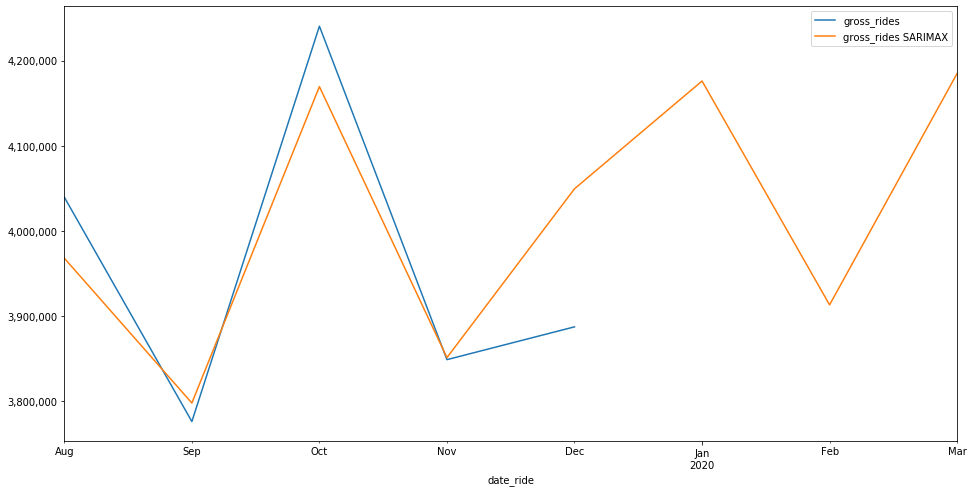

In [40]:
# plot predictions

ts.prediction_plot(series=test[series],
                   predictions=predictions,
                   wdf=vpdf,
                   holiday_df=test,
                   vp=False)

In [41]:
# get the comparison of predictions to actual

compare = ts.compare_results(test[series], predictions, test, vp =False)

compare.style.format("{:,.0f}")

,gross_rides,gross_rides SARIMAX
2019-08-31 00:00:00,"4,039,743","3,968,146"
2019-09-30 00:00:00,"3,776,400","3,798,110"
2019-10-31 00:00:00,"4,240,488","4,169,557"
2019-11-30 00:00:00,"3,849,042","3,851,413"
2019-12-31 00:00:00,"3,887,532","4,049,602"


In [42]:
# error calculations from predictions and actual

ts.error_calcs(compare, predictions, test[series])

,gross_rides,gross_rides SARIMAX,Error,Percent
2019-08-31 00:00:00,"4,039,743","3,968,146","71,597",1.77
2019-09-30 00:00:00,"3,776,400","3,798,110","-21,710",-0.57
2019-10-31 00:00:00,"4,240,488","4,169,557","70,931",1.67
2019-11-30 00:00:00,"3,849,042","3,851,413","-2,371",-0.06
2019-12-31 00:00:00,"3,887,532","4,049,602","-162,070",-4.17


In [43]:
# make the confidence intervals

intervals = ts.get_oos_conf_interval(model=model,
                                     steps_ahead=horizon,
                                     exog_data = oos_exog)

In [44]:
intervals

,Predictions,lower gross_rides,upper gross_rides
2019-08-31,"3,968,145.71","3,715,415.07","4,220,876.35"
2019-09-30,"3,798,110.11","3,343,292.83","4,252,927.39"
2019-10-31,"4,169,557.19","3,442,161.84","4,896,952.53"
2019-11-30,"3,851,413.06","2,824,473.62","4,878,352.51"
2019-12-31,"4,049,601.79","2,685,212.72","5,413,990.87"
2020-01-31,"4,176,126.98","2,446,233.15","5,906,020.81"
2020-02-29,"3,913,334.12","1,789,157.52","6,037,510.72"
2020-03-31,"4,185,027.46","1,565,362.18","6,804,692.75"


In [45]:
# make the df for plotting OOS

conf_df = ts.make_oos_plot_df(model=model,
                           steps_ahead=horizon,
                           exog_data = oos_exog)

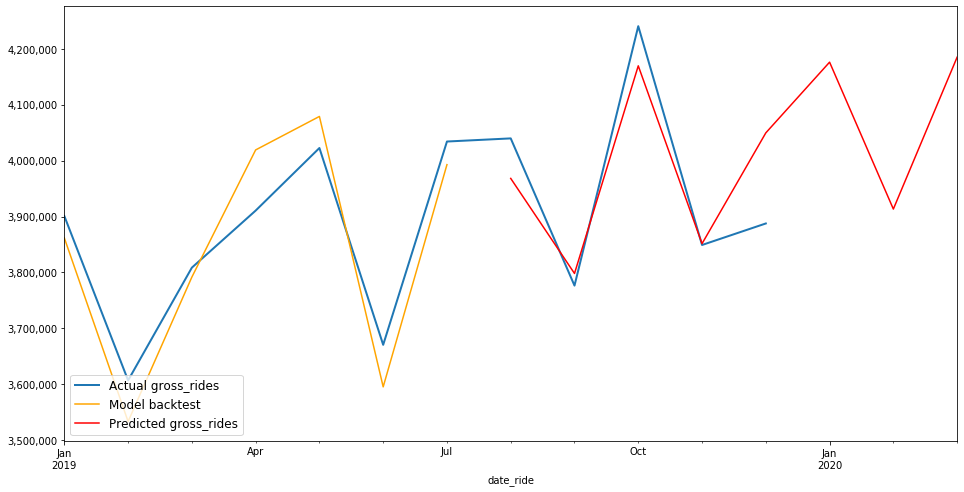

In [46]:
# oos plot

ts.plot_oos(conf_df, mdf, series, backtest, oos_exog, start_date='2019-01-01')

In [47]:
conf_df.reset_index(inplace=True)
conf_df

,index,Predictions,lower gross_rides,upper gross_rides
0,2019-08-31,"3,968,145.71","3,715,415.07","4,220,876.35"
1,2019-09-30,"3,798,110.11","3,343,292.83","4,252,927.39"
2,2019-10-31,"4,169,557.19","3,442,161.84","4,896,952.53"
3,2019-11-30,"3,851,413.06","2,824,473.62","4,878,352.51"
4,2019-12-31,"4,049,601.79","2,685,212.72","5,413,990.87"
5,2020-01-31,"4,176,126.98","2,446,233.15","5,906,020.81"
6,2020-02-29,"3,913,334.12","1,789,157.52","6,037,510.72"
7,2020-03-31,"4,185,027.46","1,565,362.18","6,804,692.75"


# Riders

In [48]:
series = 'riders'

In [49]:
model = ts.build_model(train[series],
                       p=2,
                       d=2,
                       q=0,
                       S=6,
                       exog_data = train['service_days'],
                       P=1,
                       D=1,
                       Q=0)

model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                
=========================================================================================
Dep. Variable:                            riders   No. Observations:                   67
Model:             SARIMAX(2, 2, 0)x(1, 1, 0, 6)   Log Likelihood                -730.790
Date:                           Tue, 10 Mar 2020   AIC                           1471.581
Time:                                   15:51:12   BIC                           1481.969
Sample:                               01-31-2014   HQIC                          1475.636
                                    - 07-31-2019                                         
Covariance Type:                             opg                                         
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
service_days  7.898e+04   2347.501     33.643      0.000    7.44e+04    8.36e+04
ar.L1           -0.7443      0.151     -4.946      0.000      -1.039      -0.449
ar.L2           -0.3842      0.183     -2.103      0.035      -0.742      -0.026
ar.S.L6         -0.4322      0.182     -2.370      0.018      -0.790      -0.075
sigma2        4.101e+09      0.003   1.61e+12      0.000     4.1e+09     4.1e+09
===================================================================================
Ljung-Box (Q):                       36.98   Jarque-Bera (JB):                 2.45
Prob(Q):                              0.61   Prob(JB):                         0.29
Heteroskedasticity (H):               0.65   Skew:                             0.28
Prob(H) (two-sided):                  0.34   Kurtosis:                         3.83
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 5.47e+27. Standard errors may be unstable.
"""

In [50]:
ts.get_dw(model)

2.006945142088119

In [51]:
# make backtest

backtest = ts.backtest_model(model,
                             train = train,
                             exog_data=train['service_days'][1:],
                             end = len(train)-1)

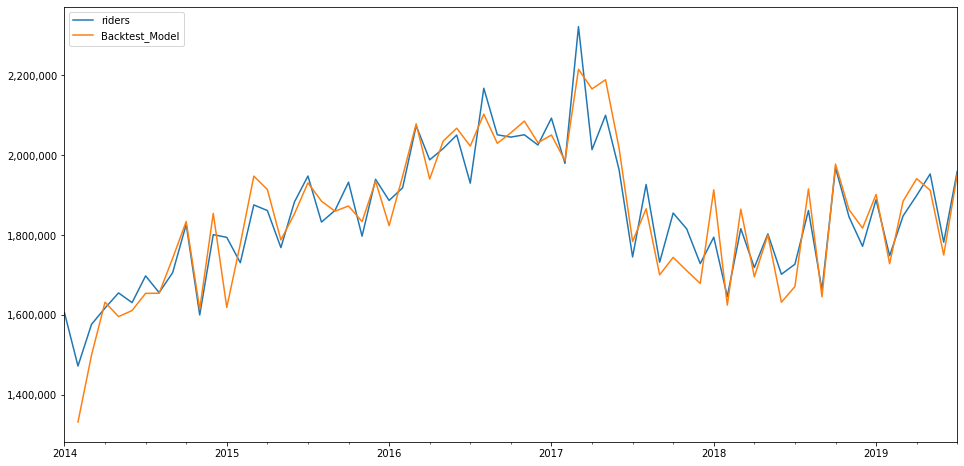

In [52]:
ts.plot_fit(train[series], backtest, train)

In [53]:
predictions = ts.make_predictions(model,
                               series + ' SARIMAX',
                               start=len(train),
                               end= len(train) + len(oos_exog)-1,
                               exog_data=oos_exog)

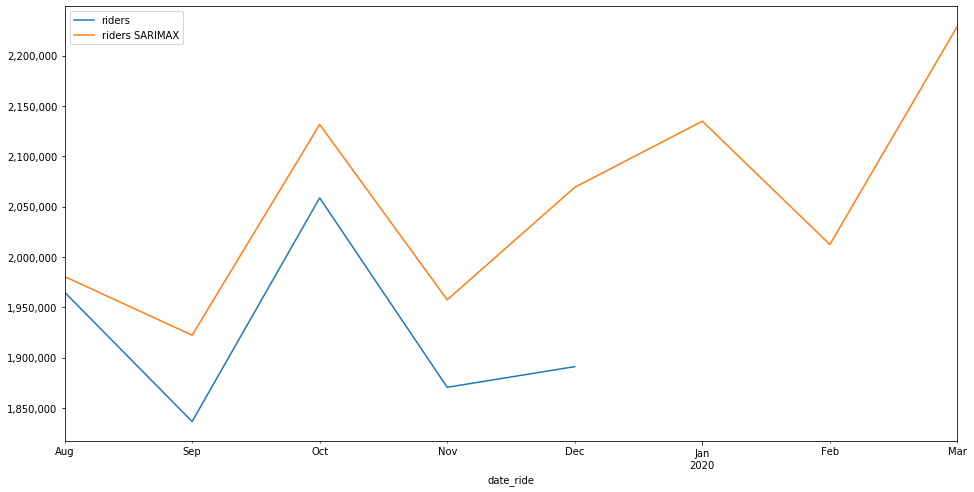

In [54]:
ts.prediction_plot(series=test[series],
                   predictions=predictions,
                   wdf=vpdf,
                   holiday_df=test,
                   vp=False)

In [55]:
compare = ts.compare_results(test[series], predictions, test, vp =False)

compare.style.format("{:,.0f}")

,riders,riders SARIMAX
2019-08-31 00:00:00,"1,964,968","1,980,507"
2019-09-30 00:00:00,"1,836,466","1,922,258"
2019-10-31 00:00:00,"2,058,689","2,131,628"
2019-11-30 00:00:00,"1,870,469","1,957,412"
2019-12-31 00:00:00,"1,891,026","2,069,237"


In [56]:
ts.error_calcs(compare, predictions, test[series])

,riders,riders SARIMAX,Error,Percent
2019-08-31 00:00:00,"1,964,968","1,980,507","-15,539",-0.79
2019-09-30 00:00:00,"1,836,466","1,922,258","-85,792",-4.67
2019-10-31 00:00:00,"2,058,689","2,131,628","-72,939",-3.54
2019-11-30 00:00:00,"1,870,469","1,957,412","-86,943",-4.65
2019-12-31 00:00:00,"1,891,026","2,069,237","-178,211",-9.42


In [57]:
intervals = ts.get_oos_conf_interval(model=model,
                                     steps_ahead=horizon,
                                     exog_data = oos_exog)

In [58]:
intervals

,Predictions,lower riders,upper riders
2019-08-31,"1,980,507.26","1,854,997.93","2,106,016.59"
2019-09-30,"1,922,257.94","1,720,790.07","2,123,725.82"
2019-10-31,"2,131,628.39","1,839,889.54","2,423,367.24"
2019-11-30,"1,957,412.12","1,549,964.93","2,364,859.31"
2019-12-31,"2,069,237.06","1,541,902.11","2,596,572.01"
2020-01-31,"2,134,929.43","1,476,301.43","2,793,557.43"
2020-02-29,"2,012,369.32","1,168,544.42","2,856,194.23"
2020-03-31,"2,229,338.12","1,192,577.15","3,266,099.09"


In [59]:
conf_df = ts.make_oos_plot_df(model=model,
                           steps_ahead=horizon,
                           exog_data = oos_exog)

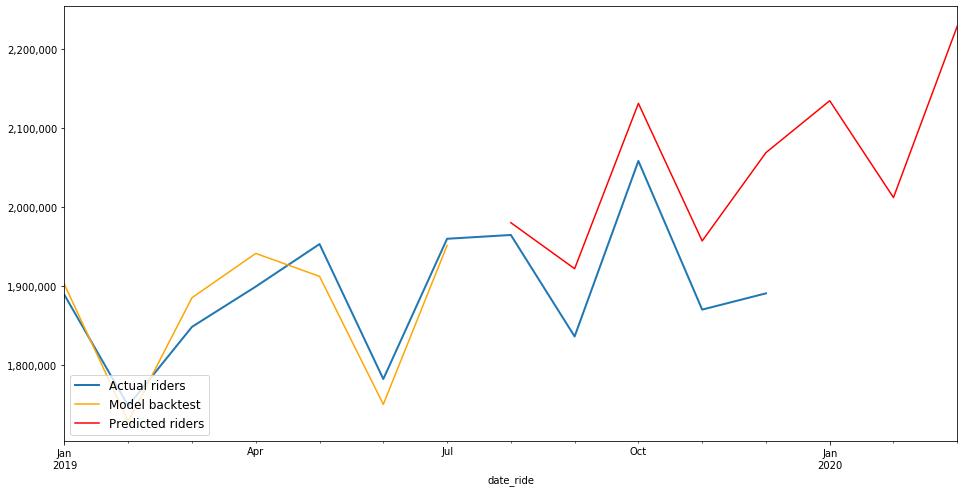

In [60]:
ts.plot_oos(conf_df, mdf, series, backtest, oos_exog, start_date='2019-01-01')

# Reset Training and Exog for OOS Modeling

In [61]:
# set up for forecasting and backtesting
# set the ranges
train = mdf.copy()

end = len(train)

train.tail()

,holiday,gross_rides,vp_rides,vp_costs,vp_miles,vp_ambulatory_rides,vp_ambulatory_costs,vp_ambulatory_miles,vp_stretcher_rides,vp_stretcher_costs,vp_stretcher_miles,vp_wheelchair_rides,vp_wheelchair_costs,vp_wheelchair_miles,riders,cpm,service_days
date_ride,,,,,,,,,,,,,,,,,
2019-08-31,0,4039743,2794334,"86,343,328.24",34281518,3367033,"60,146,357.54","41,763,354.00",70400,"8,317,467.27","667,867.00",602310,"17,879,503.43","5,551,020.00",1964968,2.52,22.00
2019-09-30,1,3776400,2576692,"79,569,926.29",31582519,3148164,"55,546,203.82","39,187,478.00",66252,"7,685,509.38","629,608.00",561984,"16,338,213.09","5,183,662.00",1836466,2.52,20.50
2019-10-31,0,4240488,2936311,"90,243,326.58",36031789,3542612,"63,279,436.23","43,985,597.00",72613,"8,632,855.40","696,497.00",625263,"18,331,034.95","5,759,053.00",2058689,2.50,23.00
2019-11-30,1,3849042,2541229,"78,230,431.85",30705614,3195158,"54,065,065.73","38,968,414.00",68149,"7,810,323.37","637,964.00",585735,"16,355,042.75","5,260,985.00",1870469,2.55,20.50
2019-12-31,1,3887532,2475941,"76,672,090.51",29936786,3208664,"53,058,535.19","38,815,281.00",73195,"7,658,671.19","657,451.00",605673,"15,954,884.13","5,345,872.00",1891026,2.56,21.50


In [62]:
# reset the exogenous series
# roll forward what has occurred

short_exog = oos.loc['2020-01-31':'2020-04-30']
short_horizon = len(short_exog)

short_exog

,service_days
end_month,
2020-01-31,22.50
2020-02-29,20.00
2020-03-31,22.00
2020-04-30,22.00


# Gross Rides - OOS

In [63]:
series = 'gross_rides'

In [66]:
train.index = pd.DatetimeIndex(train.index.values,
                               freq=train.index.inferred_freq)                              

model = ts.build_model(train[series],
                       p=1,
                       d=2,
                       q=0,
                       S=14,
                       exog_data = train['service_days'],
                       P=2,
                       D=1,
                       Q=0)

model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                        gross_rides   No. Observations:                   72
Model:             SARIMAX(1, 2, 0)x(2, 1, 0, 14)   Log Likelihood                -736.352
Date:                            Tue, 10 Mar 2020   AIC                           1482.703
Time:                                    15:56:43   BIC                           1492.830
Sample:                                01-31-2014   HQIC                          1486.629
                                     - 12-31-2019                                         
Covariance Type:                              opg                                         
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
service_days  1.548e+05   6705.251     23.086      0.000    1.42e+05    1.68e+05
ar.L1           -0.4415      0.193     -2.287      0.022      -0.820      -0.063
ar.S.L14        -0.5451      0.185     -2.950      0.003      -0.907      -0.183
ar.S.L28        -0.4513      0.238     -1.900      0.057      -0.917       0.014
sigma2        2.093e+10      0.001   4.08e+13      0.000    2.09e+10    2.09e+10
===================================================================================
Ljung-Box (Q):                       53.79   Jarque-Bera (JB):                 0.01
Prob(Q):                              0.07   Prob(JB):                         1.00
Heteroskedasticity (H):               2.87   Skew:                             0.02
Prob(H) (two-sided):                  0.03   Kurtosis:                         2.97
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 7.08e+29. Standard errors may be unstable.
"""

In [67]:
ts.get_dw(model)

2.3265812869218965

In [68]:
backtest = ts.backtest_model(model,
                             train = train,
                             exog_data=train['service_days'][1:],
                             end = len(train)-1)

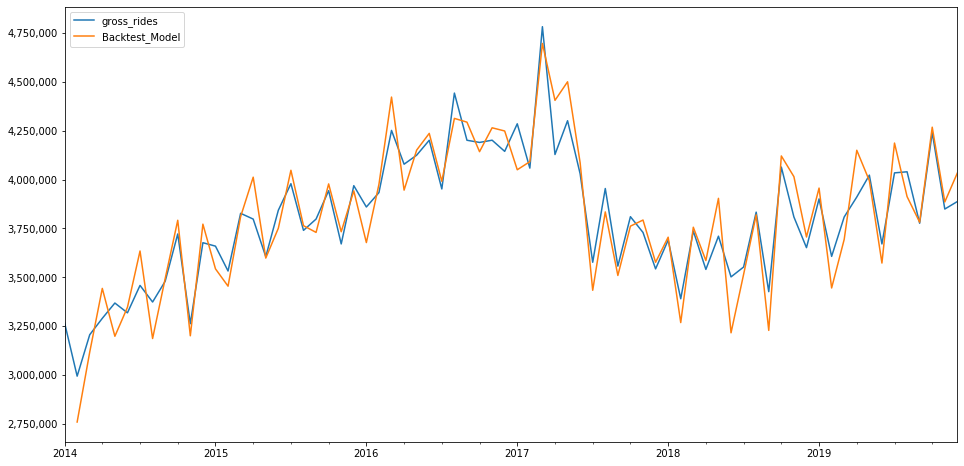

In [69]:
# plot model backtest

plt.clf()

ts.plot_fit(train[series], backtest, train);

In [70]:
predictions = ts.make_predictions(model,
                               series + ' SARIMAX',
                               start=len(train),
                               end= len(train) + len(short_exog)-1,
                               exog_data=short_exog)

In [71]:
# make the OOS intervals

intervals = ts.get_oos_conf_interval(model=model,
                                     steps_ahead=short_horizon,
                                     exog_data = short_exog)

In [72]:
intervals

,Predictions,lower gross_rides,upper gross_rides
2020-01-31,"3,920,980.03","3,637,423.01","4,204,537.05"
2020-02-29,"3,454,615.88","2,929,531.53","3,979,700.22"
2020-03-31,"3,616,279.13","2,776,341.31","4,456,216.95"
2020-04-30,"3,564,536.70","2,373,225.70","4,755,847.71"


In [73]:
conf_df = ts.make_oos_plot_df(model=model,
                           steps_ahead=short_horizon,
                           exog_data = short_exog)

In [74]:
# make the final df for merging

gross_rides_fcast = ts.oos_weekly_df(model=model,
                               steps_ahead=short_horizon,
                               exog_data = short_exog,
                               series = series,
                               add_date = True)

gross_rides_fcast

,gross_rides,lower_gross_rides,upper_gross_rides,fcast_date
2020-01-31,"3,920,980.03","3,637,423.01","4,204,537.05",2020-03-10
2020-02-29,"3,454,615.88","2,929,531.53","3,979,700.22",2020-03-10
2020-03-31,"3,616,279.13","2,776,341.31","4,456,216.95",2020-03-10
2020-04-30,"3,564,536.70","2,373,225.70","4,755,847.71",2020-03-10


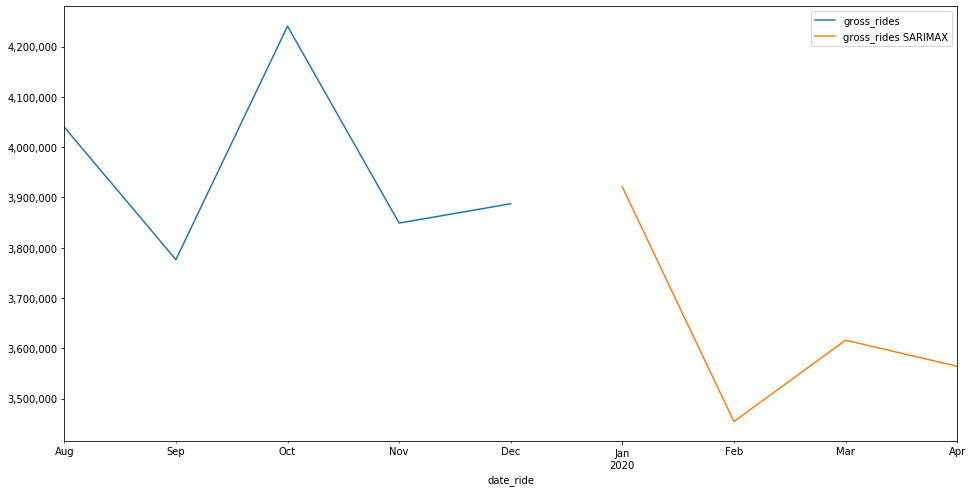

In [76]:
# oos prediction plot

ts.prediction_plot(series=test[series],
                   predictions=predictions,
                   wdf=vpdf,
                   holiday_df=oos_exog,
                   vp=False)

# Riders - OOS

In [77]:
series = 'riders'

In [86]:
model = ts.build_model(train[series],
                       p=1,
                       d=2,
                       q=0,
                       S=10,
                       exog_data = train['service_days'],
                       P=1,
                       D=1,
                       Q=0)

model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                             riders   No. Observations:                   72
Model:             SARIMAX(1, 2, 0)x(1, 1, 0, 10)   Log Likelihood                -749.809
Date:                            Tue, 10 Mar 2020   AIC                           1507.618
Time:                                    16:00:33   BIC                           1515.995
Sample:                                01-31-2014   HQIC                          1510.895
                                     - 12-31-2019                                         
Covariance Type:                              opg                                         
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
service_days  6.863e+04   4800.113     14.298      0.000    5.92e+04     7.8e+04
ar.L1           -0.5789      0.149     -3.890      0.000      -0.871      -0.287
ar.S.L10        -0.6516      0.169     -3.849      0.000      -0.983      -0.320
sigma2        6.353e+09      0.000   1.78e+13      0.000    6.35e+09    6.35e+09
===================================================================================
Ljung-Box (Q):                      100.11   Jarque-Bera (JB):                 0.32
Prob(Q):                              0.00   Prob(JB):                         0.85
Heteroskedasticity (H):               1.58   Skew:                             0.02
Prob(H) (two-sided):                  0.32   Kurtosis:                         2.64
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 6.64e+29. Standard errors may be unstable.
"""

In [87]:
ts.get_dw(model)

2.1975586413630053

In [88]:
# make backtest

backtest = ts.backtest_model(model,
                             train = train,
                             exog_data=train['holiday'][1:],
                             end = len(train)-1)

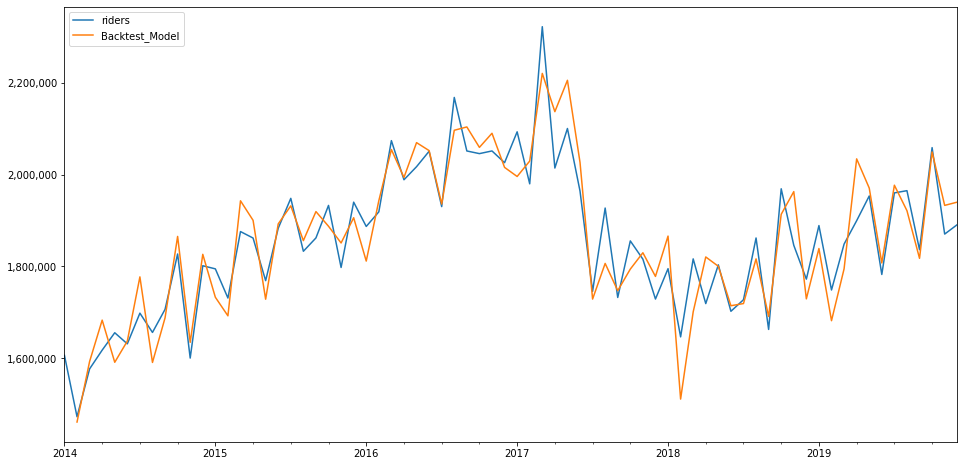

In [89]:
# plot backtest

ts.plot_fit(train[series], backtest, train)

In [90]:
# make predictions

predictions = ts.make_predictions(model,
                               series + ' SARIMAX',
                               start=len(train),
                               end= len(train) + len(short_exog)-1,
                               exog_data=short_exog)

In [91]:
# make the OOS intervals

intervals = ts.get_oos_conf_interval(model=model,
                                     steps_ahead=short_horizon,
                                     exog_data = short_exog)

In [92]:
intervals

,Predictions,lower riders,upper riders
2020-01-31,"1,923,753.29","1,767,537.75","2,079,968.83"
2020-02-29,"1,709,246.03","1,437,800.07","1,980,691.98"
2020-03-31,"1,811,294.39","1,376,129.77","2,246,459.01"
2020-04-30,"1,794,900.66","1,184,567.55","2,405,233.77"


In [93]:
conf_df = ts.make_oos_plot_df(model=model,
                           steps_ahead=short_horizon,
                           exog_data = short_exog)

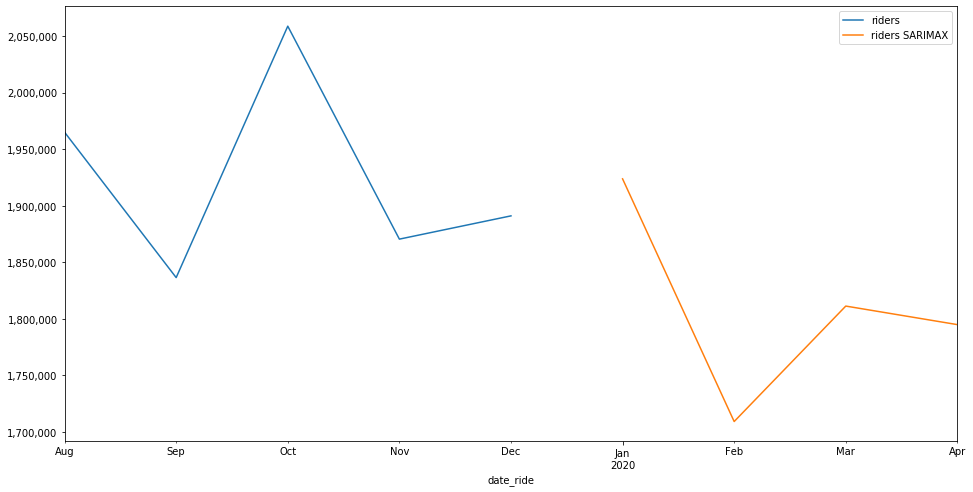

In [95]:
# oos prediction plot

ts.prediction_plot(series=test[series],
                   predictions=predictions,
                   wdf=vpdf,
                   holiday_df=short_exog,
                   vp=False)

In [96]:
# make the final df for merging

riders_fcast = ts.oos_weekly_df(model=model,
                               steps_ahead=short_horizon,
                               exog_data = short_exog,
                               series = series,
                               add_date = False)

riders_fcast

,riders,lower_riders,upper_riders
2020-01-31,"1,923,753.29","1,767,537.75","2,079,968.83"
2020-02-29,"1,709,246.03","1,437,800.07","1,980,691.98"
2020-03-31,"1,811,294.39","1,376,129.77","2,246,459.01"
2020-04-30,"1,794,900.66","1,184,567.55","2,405,233.77"


# Begin VP Series

## Reset Values for VP Train

In [220]:
# set the ranges

# make the training set
train = vpdf.copy()
full = mdf.copy()

# set the end point
end = len(train)

# set the truncation point to excude vp lag
print(vp_lag_wks)

train.tail()

2


,holiday,gross_rides,vp_rides,vp_costs,vp_miles,vp_ambulatory_rides,vp_ambulatory_costs,vp_ambulatory_miles,vp_stretcher_rides,vp_stretcher_costs,vp_stretcher_miles,vp_wheelchair_rides,vp_wheelchair_costs,vp_wheelchair_miles,riders,cpm,service_days
date_ride,,,,,,,,,,,,,,,,,
2019-05-31,1,4022536,2755164,"85,129,079.59",33336354,3347126,"58,968,223.56","41,095,981.00",71683,"8,505,088.47","677,657.00",603727,"17,655,767.56","5,475,482.00",1953459,2.55,22.50
2019-06-30,0,3670446,2527202,"78,487,134.16",30724186,3057270,"54,449,688.96","37,668,728.00",65995,"7,734,064.72","623,924.00",547181,"16,303,380.48","4,953,991.00",1782552,2.55,20.00
2019-07-31,1,4034142,2749201,"84,936,755.02",33467833,3359899,"58,941,841.53","41,386,842.00",70930,"8,331,489.90","673,897.00",603313,"17,663,423.59","5,479,227.00",1960153,2.54,22.50
2019-08-31,0,4039743,2794334,"86,343,328.24",34281518,3367033,"60,146,357.54","41,763,354.00",70400,"8,317,467.27","667,867.00",602310,"17,879,503.43","5,551,020.00",1964968,2.52,22.00
2019-09-30,1,3776400,2576692,"79,569,926.29",31582519,3148164,"55,546,203.82","39,187,478.00",66252,"7,685,509.38","629,608.00",561984,"16,338,213.09","5,183,662.00",1836466,2.52,20.50


In [221]:
# reset exog and horizon
oos_exog = oos.loc['2019-10-31':'2020-03-31']

horizon = len(oos_exog)

oos_exog

,service_days
end_month,
2019-10-31,23.00
2019-11-30,20.50
2019-12-31,21.50
2020-01-31,22.50
2020-02-29,20.00
2020-03-31,22.00


# Ver Pd Rides

In [222]:
series = 'vp_rides'

In [223]:
train.index = pd.DatetimeIndex(train.index.values,
                               freq=train.index.inferred_freq)

model = ts.build_model(train[series],
                       p=0,
                       d=2,
                       q=1,
                       S=4,
                       exog_data = train['service_days'],
                       P=2,
                       D=1,
                       Q=0)

model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                
=========================================================================================
Dep. Variable:                          vp_rides   No. Observations:                   69
Model:             SARIMAX(0, 2, 1)x(2, 1, 0, 4)   Log Likelihood                -814.665
Date:                           Wed, 11 Mar 2020   AIC                           1639.331
Time:                                   13:39:50   BIC                           1650.046
Sample:                               01-31-2014   HQIC                          1643.545
                                    - 09-30-2019                                         
Covariance Type:                             opg                                         
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
service_days  9.966e+04   1.07e+04      9.331      0.000    7.87e+04    1.21e+05
ma.L1           -0.9540      0.204     -4.680      0.000      -1.353      -0.554
ar.S.L4         -0.6162      0.276     -2.229      0.026      -1.158      -0.074
ar.S.L8         -0.4669      0.237     -1.974      0.048      -0.930      -0.003
sigma2        1.755e+10      0.002   1.06e+13      0.000    1.75e+10    1.75e+10
===================================================================================
Ljung-Box (Q):                       57.55   Jarque-Bera (JB):                 5.59
Prob(Q):                              0.04   Prob(JB):                         0.06
Heteroskedasticity (H):               0.64   Skew:                             0.62
Prob(H) (two-sided):                  0.32   Kurtosis:                         3.78
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.92e+29. Standard errors may be unstable.
"""

In [224]:
ts.get_dw(model)

2.1904723813084437

In [225]:
backtest = ts.backtest_model(model,
                             train = train,
                             exog_data=train['service_days'][1:],
                             end = len(train)-1)

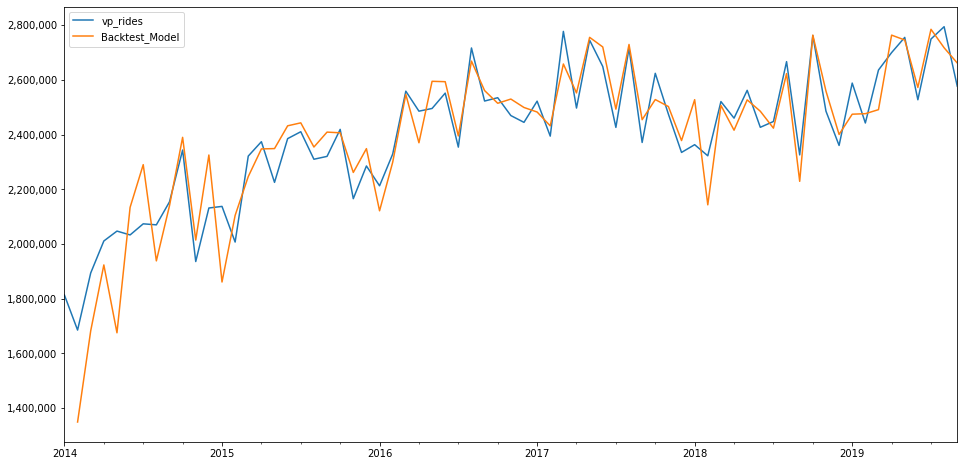

In [226]:
# plot backtest

ts.plot_fit(train[series], backtest, train);

In [227]:
# make predictions

predictions = ts.make_predictions(model,
                               series + ' SARIMAX',
                               start=len(train) + 1,
                               end= len(train) + len(oos_exog)-1,
                               exog_data=oos_exog)

In [228]:
# make prediction intervals

intervals = ts.get_oos_conf_interval(model=model,
                                     steps_ahead=horizon,
                                     exog_data = oos_exog)

In [229]:
intervals

,Predictions,lower vp_rides,upper vp_rides
2019-10-31,"2,892,957.54","2,633,303.73","3,152,611.35"
2019-11-30,"2,590,860.49","2,215,068.43","2,966,652.54"
2019-12-31,"2,712,286.38","2,241,452.52","3,183,120.25"
2020-01-31,"2,802,755.47","2,246,787.37","3,358,723.56"
2020-02-29,"2,633,412.09","1,944,204.55","3,322,619.63"
2020-03-31,"2,854,900.78","2,045,758.39","3,664,043.18"


In [230]:
# make df for oos plot

conf_df = ts.make_oos_plot_df(model=model,
                           steps_ahead=horizon,
                           exog_data = oos_exog)

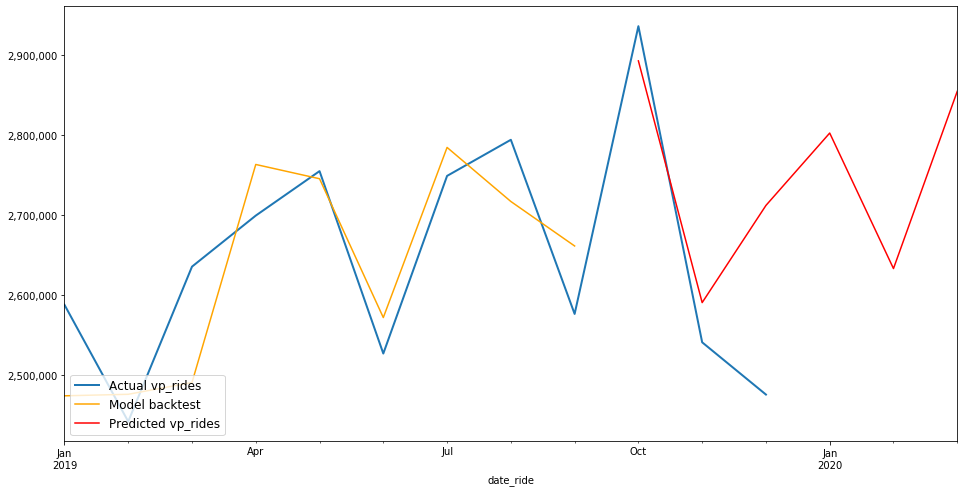

In [231]:
# oos plot

ts.plot_oos(conf_df, full, series, backtest, oos_exog, start_date='2019-01-01');

In [233]:
# make final series

vp_rides = ts.oos_weekly_df(model=model,
                            steps_ahead=horizon,
                            exog_data = oos_exog,
                            series = series,
                            add_date = False)

vp_rides

,vp_rides,lower_vp_rides,upper_vp_rides
2019-10-31,"2,892,957.54","2,633,303.73","3,152,611.35"
2019-11-30,"2,590,860.49","2,215,068.43","2,966,652.54"
2019-12-31,"2,712,286.38","2,241,452.52","3,183,120.25"
2020-01-31,"2,802,755.47","2,246,787.37","3,358,723.56"
2020-02-29,"2,633,412.09","1,944,204.55","3,322,619.63"
2020-03-31,"2,854,900.78","2,045,758.39","3,664,043.18"


# Ver Pd Costs

In [234]:
series = 'vp_costs'

In [235]:
model = ts.build_model(train[series],
                       p=2,
                       d=2,
                       q=0,
                       S=6,
                       exog_data = train['service_days'],
                       P=1,
                       D=1,
                       Q=1)

model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                
=========================================================================================
Dep. Variable:                          vp_costs   No. Observations:                   69
Model:             SARIMAX(2, 2, 0)x(1, 1, 1, 6)   Log Likelihood                -997.917
Date:                           Wed, 11 Mar 2020   AIC                           2007.834
Time:                                   13:44:16   BIC                           2020.499
Sample:                               01-31-2014   HQIC                          2012.797
                                    - 09-30-2019                                         
Covariance Type:                             opg                                         
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
service_days  2.945e+06   1.59e+05     18.479      0.000    2.63e+06    3.26e+06
ar.L1           -0.7721      0.280     -2.761      0.006      -1.320      -0.224
ar.L2           -0.4236      0.160     -2.647      0.008      -0.737      -0.110
ar.S.L6          0.2580      0.191      1.347      0.178      -0.117       0.633
ma.S.L6         -0.8319      0.201     -4.139      0.000      -1.226      -0.438
sigma2        1.123e+13      0.008   1.34e+15      0.000    1.12e+13    1.12e+13
===================================================================================
Ljung-Box (Q):                       44.63   Jarque-Bera (JB):                47.48
Prob(Q):                              0.28   Prob(JB):                         0.00
Heteroskedasticity (H):               0.59   Skew:                             1.47
Prob(H) (two-sided):                  0.24   Kurtosis:                         6.18
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.18e+31. Standard errors may be unstable.
"""

In [236]:
ts.get_dw(model)

1.8738350589403168

In [237]:
backtest = ts.backtest_model(model,
                             train = train,
                             exog_data=train['service_days'][1:],
                             end = len(train)-1)

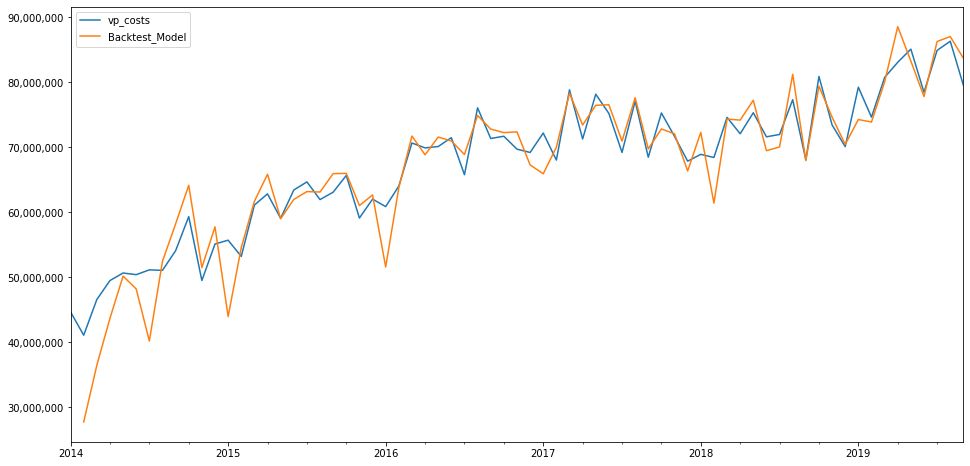

In [238]:
# plot backtest

ts.plot_fit(train[series], backtest, train)

In [239]:
# make predictions

predictions = ts.make_predictions(model,
                               series + ' SARIMAX',
                               start=len(train)+1,
                               end= len(train) + len(oos_exog)-1,
                               exog_data=oos_exog)

In [240]:
# make prediction conf intervals

intervals = ts.get_oos_conf_interval(model=model,
                                     steps_ahead=horizon,
                                     exog_data = oos_exog)

In [241]:
intervals

,Predictions,lower vp_costs,upper vp_costs
2019-10-31,"86,305,069.53","79,726,388.79","92,883,750.26"
2019-11-30,"76,829,486.78","66,411,718.91","87,247,254.66"
2019-12-31,"77,122,349.08","62,179,571.65","92,065,126.50"
2020-01-31,"77,459,739.22","56,553,413.18","98,366,065.27"
2020-02-29,"70,666,837.07","43,679,609.31","97,654,064.83"
2020-03-31,"73,921,930.15","40,271,568.23","107,572,292.07"


In [242]:
# make df for oos plot

conf_df = ts.make_oos_plot_df(model=model,
                           steps_ahead=horizon,
                           exog_data = oos_exog)

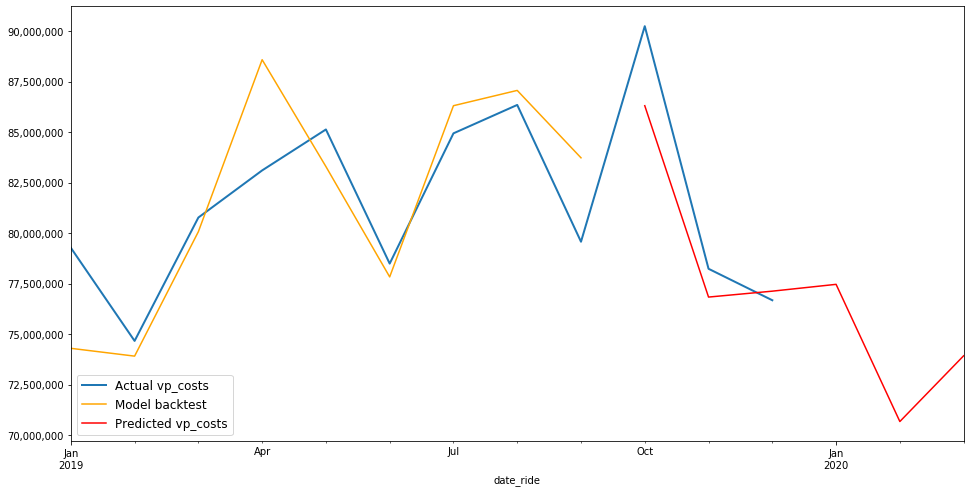

In [243]:
# plot oos

ts.plot_oos(conf_df, full, series, backtest, oos_exog, start_date='2019-01-01')

In [244]:
# make final series

vp_costs = ts.oos_weekly_df(model=model,
                            steps_ahead=horizon,
                            exog_data = oos_exog,
                            series = series,
                            add_date = False)

vp_costs

,vp_costs,lower_vp_costs,upper_vp_costs
2019-10-31,"86,305,069.53","79,726,388.79","92,883,750.26"
2019-11-30,"76,829,486.78","66,411,718.91","87,247,254.66"
2019-12-31,"77,122,349.08","62,179,571.65","92,065,126.50"
2020-01-31,"77,459,739.22","56,553,413.18","98,366,065.27"
2020-02-29,"70,666,837.07","43,679,609.31","97,654,064.83"
2020-03-31,"73,921,930.15","40,271,568.23","107,572,292.07"


# Ver Pd Miles

In [245]:
series = 'vp_miles'

In [246]:
model = ts.build_model(train[series],
                       p=1,
                       d=1,
                       q=0,
                       S=6,
                       exog_data = train['service_days'],
                       P=2,
                       D=1,
                       Q=0)

model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                
=========================================================================================
Dep. Variable:                          vp_miles   No. Observations:                   69
Model:             SARIMAX(1, 1, 0)x(2, 1, 0, 6)   Log Likelihood                -964.123
Date:                           Wed, 11 Mar 2020   AIC                           1938.247
Time:                                   13:44:56   BIC                           1948.882
Sample:                               01-31-2014   HQIC                          1942.422
                                    - 09-30-2019                                         
Covariance Type:                             opg                                         
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
service_days  1.342e+06    8.6e+04     15.602      0.000    1.17e+06    1.51e+06
ar.L1           -0.3318      0.170     -1.947      0.052      -0.666       0.002
ar.S.L6         -0.7701      0.166     -4.652      0.000      -1.095      -0.446
ar.S.L12        -0.3128      0.097     -3.214      0.001      -0.504      -0.122
sigma2        2.833e+12      0.005   5.41e+14      0.000    2.83e+12    2.83e+12
===================================================================================
Ljung-Box (Q):                       49.27   Jarque-Bera (JB):                 6.71
Prob(Q):                              0.15   Prob(JB):                         0.03
Heteroskedasticity (H):               0.40   Skew:                             0.41
Prob(H) (two-sided):                  0.04   Kurtosis:                         4.39
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 6.04e+30. Standard errors may be unstable.
"""

In [247]:
ts.get_dw(model)

1.6098244175848775

In [248]:
backtest = ts.backtest_model(model,
                             train = train,
                             exog_data=train['service_days'][1:],
                             end = len(train)-1)

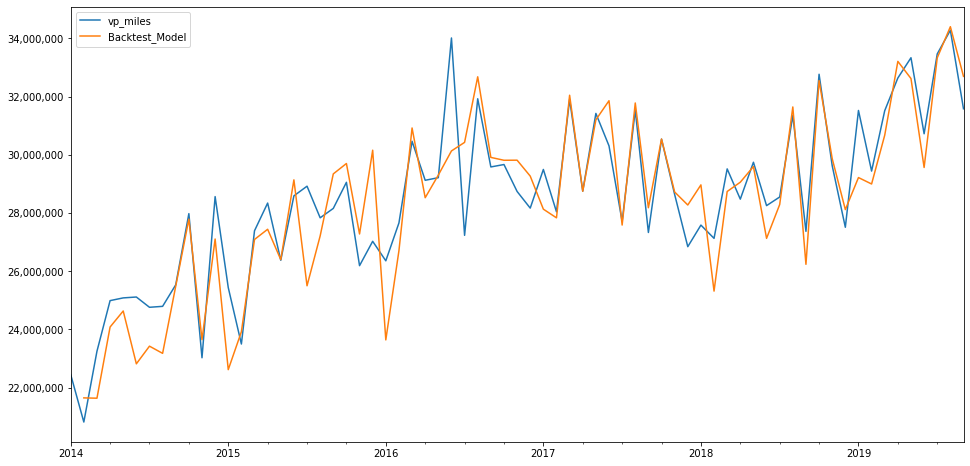

In [249]:
# plot backtest

ts.plot_fit(train[series], backtest, train)

In [250]:
# make predictions

predictions = ts.make_predictions(model,
                               series + ' SARIMAX',
                               start=len(train)+1,
                               end= len(train) + len(oos_exog)-1,
                               exog_data=oos_exog)

In [251]:
# conf intervals for predictions

intervals = ts.get_oos_conf_interval(model=model,
                                     steps_ahead=horizon,
                                     exog_data = oos_exog)

In [252]:
intervals

,Predictions,lower vp_miles,upper vp_miles
2019-10-31,"35,663,550.75","32,364,648.93","38,962,452.57"
2019-11-30,"31,443,977.36","27,476,440.33","35,411,514.39"
2019-12-31,"32,807,101.04","28,081,293.17","37,532,908.91"
2020-01-31,"34,486,214.99","29,164,490.98","39,807,938.99"
2020-02-29,"32,305,262.49","26,431,117.61","38,179,407.37"
2020-03-31,"35,389,706.40","29,015,965.77","41,763,447.03"


In [253]:
# make df for oos plot

conf_df = ts.make_oos_plot_df(model=model,
                           steps_ahead=horizon,
                           exog_data = oos_exog)

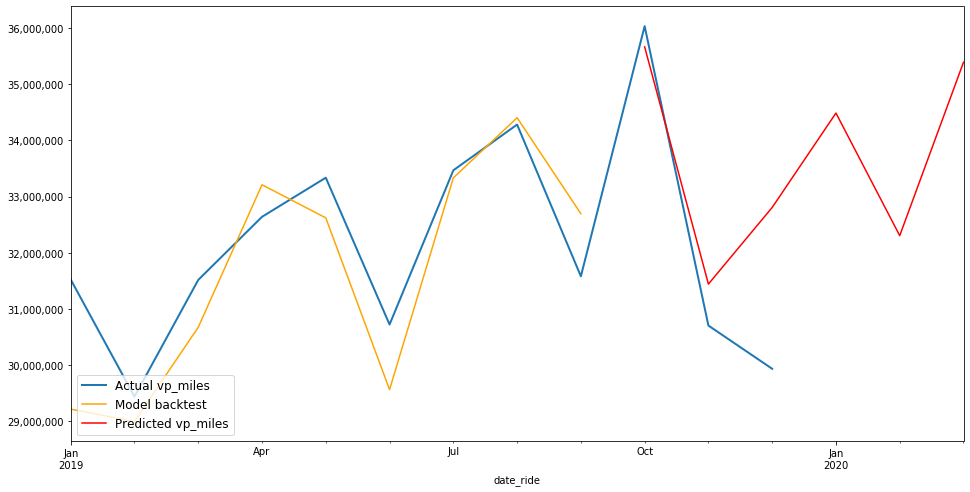

In [254]:
# plot oos

ts.plot_oos(conf_df, full, series, backtest, oos_exog, start_date='2019-01-01');

In [255]:
# make final series

vp_miles = ts.oos_weekly_df(model=model,
                            steps_ahead=horizon,
                            exog_data = oos_exog,
                            series = series,
                            add_date = False)

vp_miles

,vp_miles,lower_vp_miles,upper_vp_miles
2019-10-31,"35,663,550.75","32,364,648.93","38,962,452.57"
2019-11-30,"31,443,977.36","27,476,440.33","35,411,514.39"
2019-12-31,"32,807,101.04","28,081,293.17","37,532,908.91"
2020-01-31,"34,486,214.99","29,164,490.98","39,807,938.99"
2020-02-29,"32,305,262.49","26,431,117.61","38,179,407.37"
2020-03-31,"35,389,706.40","29,015,965.77","41,763,447.03"


# Ver Pd Amb Rides

In [256]:
series = 'vp_ambulatory_rides'

In [257]:
model = ts.build_model(train[series],
                       p=0,
                       d=2,
                       q=1,
                       S=6,
                       exog_data = train['service_days'],
                       P=0,
                       D=1,
                       Q=1)

model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                
=========================================================================================
Dep. Variable:               vp_ambulatory_rides   No. Observations:                   69
Model:             SARIMAX(0, 2, 1)x(0, 1, 1, 6)   Log Likelihood                -790.153
Date:                           Wed, 11 Mar 2020   AIC                           1588.306
Time:                                   13:45:36   BIC                           1596.750
Sample:                               01-31-2014   HQIC                          1591.616
                                    - 09-30-2019                                         
Covariance Type:                             opg                                         
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
service_days  1.387e+05   5437.297     25.501      0.000    1.28e+05    1.49e+05
ma.L1           -0.9273      0.113     -8.200      0.000      -1.149      -0.706
ma.S.L6         -0.6183      0.173     -3.572      0.000      -0.958      -0.279
sigma2        1.509e+10      0.003    4.6e+12      0.000    1.51e+10    1.51e+10
===================================================================================
Ljung-Box (Q):                       39.68   Jarque-Bera (JB):                 3.21
Prob(Q):                              0.48   Prob(JB):                         0.20
Heteroskedasticity (H):               0.40   Skew:                             0.25
Prob(H) (two-sided):                  0.05   Kurtosis:                         4.01
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 3.38e+28. Standard errors may be unstable.
"""

In [258]:
ts.get_dw(model)

1.9449224129804206

In [259]:
backtest = ts.backtest_model(model,
                             train = train,
                             exog_data=train['service_days'][1:],
                             end = len(train)-1)

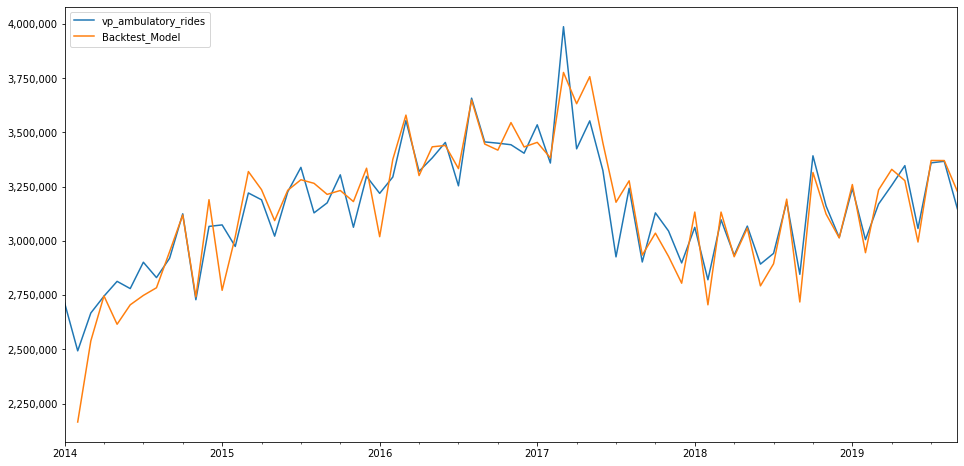

In [260]:
# plot backtest

ts.plot_fit(train[series], backtest, train)

In [261]:
# make predictions

predictions = ts.make_predictions(model,
                               series + ' SARIMAX',
                               start=len(train) + 1,
                               end= len(train) + len(oos_exog)-1,
                               exog_data=oos_exog)

In [262]:
# conf intervals for predictions

intervals = ts.get_oos_conf_interval(model=model,
                                     steps_ahead=horizon,
                                     exog_data = oos_exog)

In [263]:
intervals

,Predictions,lower vp_ambulatory_rides,upper vp_ambulatory_rides
2019-10-31,"3,488,509.57","3,247,688.67","3,729,330.48"
2019-11-30,"3,124,550.85","2,771,368.10","3,477,733.61"
2019-12-31,"3,282,349.00","2,834,191.55","3,730,506.45"
2020-01-31,"3,381,848.83","2,846,192.71","3,917,504.94"
2020-02-29,"3,112,417.28","2,493,064.75","3,731,769.80"
2020-03-31,"3,427,216.91","2,726,169.32","4,128,264.50"


In [264]:
# make df for oos plot

conf_df = ts.make_oos_plot_df(model=model,
                           steps_ahead=horizon,
                           exog_data = oos_exog)

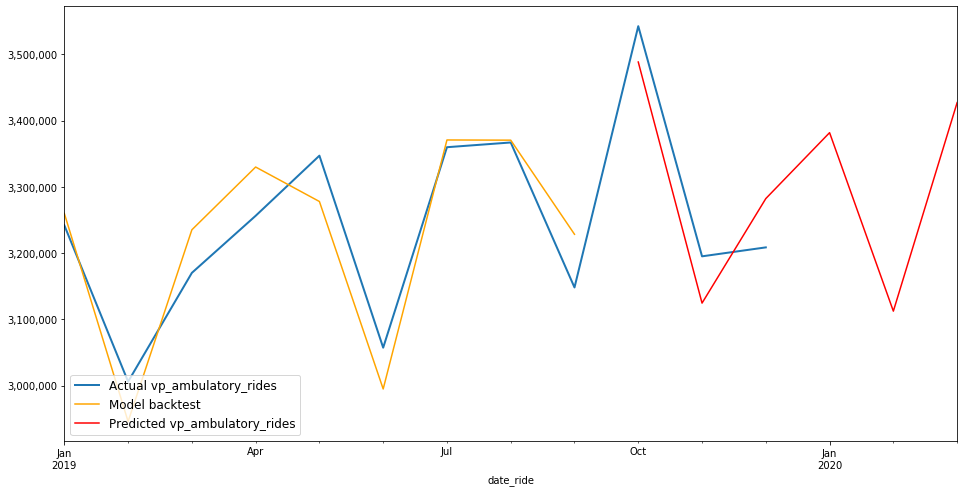

In [265]:
# oos plot

ts.plot_oos(conf_df, full, series, backtest, oos_exog, start_date='2019-01-01')

In [266]:
# make final series

vp_ambulatory_rides = ts.oos_weekly_df(model=model,
                                       steps_ahead=horizon,
                                       exog_data = oos_exog,
                                       series = series,
                                       add_date = False)

vp_ambulatory_rides

,vp_ambulatory_rides,lower_vp_ambulatory_rides,upper_vp_ambulatory_rides
2019-10-31,"3,488,509.57","3,247,688.67","3,729,330.48"
2019-11-30,"3,124,550.85","2,771,368.10","3,477,733.61"
2019-12-31,"3,282,349.00","2,834,191.55","3,730,506.45"
2020-01-31,"3,381,848.83","2,846,192.71","3,917,504.94"
2020-02-29,"3,112,417.28","2,493,064.75","3,731,769.80"
2020-03-31,"3,427,216.91","2,726,169.32","4,128,264.50"


# Ver Pd Amb Costs

In [267]:
series = 'vp_ambulatory_costs'

In [268]:
model = ts.build_model(train[series],
                       p=1,
                       d=1,
                       q=1,
                       S=5,
                       exog_data = train['service_days'],
                       P=1,
                       D=1,
                       Q=0)

model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                
=========================================================================================
Dep. Variable:               vp_ambulatory_costs   No. Observations:                   69
Model:             SARIMAX(1, 1, 1)x(1, 1, 0, 5)   Log Likelihood                -997.369
Date:                           Wed, 11 Mar 2020   AIC                           2004.738
Time:                                   13:46:34   BIC                           2015.453
Sample:                               01-31-2014   HQIC                          2008.952
                                    - 09-30-2019                                         
Covariance Type:                             opg                                         
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
service_days  1.795e+06   1.28e+05     14.057      0.000    1.54e+06    2.04e+06
ar.L1            0.7040      0.168      4.184      0.000       0.374       1.034
ma.L1           -0.9815      0.215     -4.566      0.000      -1.403      -0.560
ar.S.L5         -0.3327      0.143     -2.332      0.020      -0.612      -0.053
sigma2         4.23e+12      0.001   6.32e+15      0.000    4.23e+12    4.23e+12
===================================================================================
Ljung-Box (Q):                       57.54   Jarque-Bera (JB):                 1.30
Prob(Q):                              0.04   Prob(JB):                         0.52
Heteroskedasticity (H):               1.82   Skew:                            -0.22
Prob(H) (two-sided):                  0.18   Kurtosis:                         2.46
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 8.16e+33. Standard errors may be unstable.
"""

In [269]:
ts.get_dw(model)

1.8659036577632757

In [270]:
backtest = ts.backtest_model(model,
                             train = train,
                             exog_data=train['service_days'][1:],
                             end = len(train)-1)

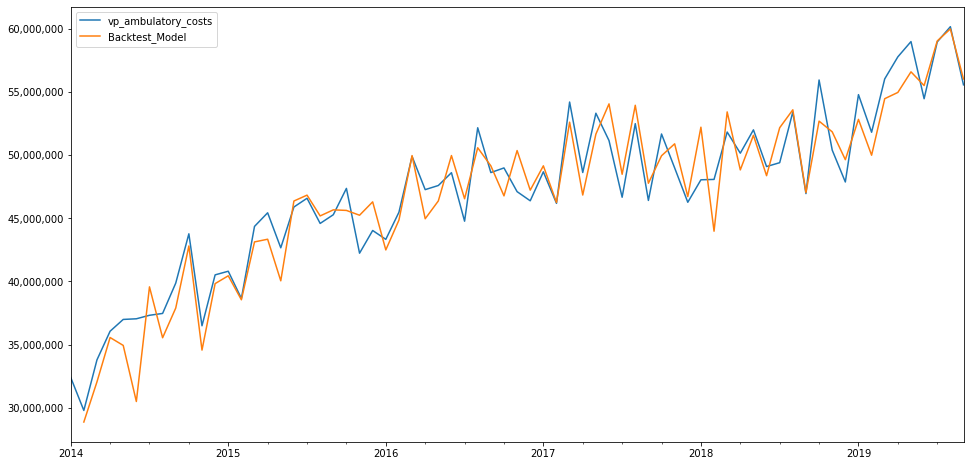

In [271]:
# plot backtest

ts.plot_fit(train[series], backtest, train)

In [272]:
# oos predictions

predictions = ts.make_predictions(model,
                               series + ' SARIMAX',
                               start=len(train)+1,
                               end= len(train) + len(oos_exog)-1,
                               exog_data=oos_exog)

In [273]:
# prediction conf intervals

intervals = ts.get_oos_conf_interval(model=model,
                                     steps_ahead=horizon,
                                     exog_data = oos_exog)

In [274]:
intervals

,Predictions,lower vp_ambulatory_costs,upper vp_ambulatory_costs
2019-10-31,"59,794,997.99","55,758,810.94","63,831,185.04"
2019-11-30,"56,249,176.51","51,263,642.42","61,234,710.60"
2019-12-31,"58,451,155.89","53,023,890.61","63,878,421.18"
2020-01-31,"62,384,643.52","56,728,310.60","68,040,976.44"
2020-02-29,"56,558,697.59","50,775,585.63","62,341,809.55"
2020-03-31,"60,057,072.63","53,230,346.91","66,883,798.34"


In [275]:
# make df for plot

conf_df = ts.make_oos_plot_df(model=model,
                           steps_ahead=horizon,
                           exog_data = oos_exog)

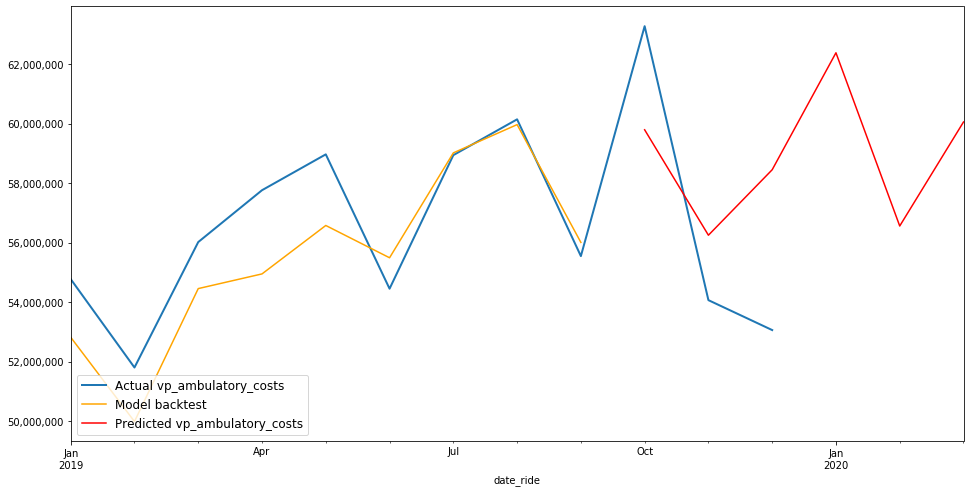

In [276]:
# plot oos

ts.plot_oos(conf_df, full, series, backtest, oos_exog, start_date='2019-01-01')

In [277]:
# make final series

vp_ambulatory_costs = ts.oos_weekly_df(model=model,
                                       steps_ahead=horizon,
                                       exog_data = oos_exog,
                                       series = series,
                                       add_date = False)

vp_ambulatory_costs

,vp_ambulatory_costs,lower_vp_ambulatory_costs,upper_vp_ambulatory_costs
2019-10-31,"59,794,997.99","55,758,810.94","63,831,185.04"
2019-11-30,"56,249,176.51","51,263,642.42","61,234,710.60"
2019-12-31,"58,451,155.89","53,023,890.61","63,878,421.18"
2020-01-31,"62,384,643.52","56,728,310.60","68,040,976.44"
2020-02-29,"56,558,697.59","50,775,585.63","62,341,809.55"
2020-03-31,"60,057,072.63","53,230,346.91","66,883,798.34"


# Ver Pd Amb Miles

In [278]:
series = 'vp_ambulatory_miles'

In [279]:
model = ts.build_model(train[series],
                       p=2,
                       d=2,
                       q=0,
                       S=6,
                       exog_data = train['service_days'],
                       P=1,
                       D=1,
                       Q=1)

model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                
=========================================================================================
Dep. Variable:               vp_ambulatory_miles   No. Observations:                   69
Model:             SARIMAX(2, 2, 0)x(1, 1, 1, 6)   Log Likelihood                -938.751
Date:                           Wed, 11 Mar 2020   AIC                           1889.501
Time:                                   13:47:38   BIC                           1902.167
Sample:                               01-31-2014   HQIC                          1894.465
                                    - 09-30-2019                                         
Covariance Type:                             opg                                         
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
service_days  1.637e+06   7.27e+04     22.517      0.000    1.49e+06    1.78e+06
ar.L1           -0.6317      0.198     -3.190      0.001      -1.020      -0.244
ar.L2           -0.4342      0.163     -2.660      0.008      -0.754      -0.114
ar.S.L6          0.4048      0.191      2.119      0.034       0.030       0.779
ma.S.L6         -0.8764      0.251     -3.492      0.000      -1.368      -0.384
sigma2        1.657e+12      0.002   7.59e+14      0.000    1.66e+12    1.66e+12
===================================================================================
Ljung-Box (Q):                       51.12   Jarque-Bera (JB):                19.27
Prob(Q):                              0.11   Prob(JB):                         0.00
Heteroskedasticity (H):               0.60   Skew:                             1.04
Prob(H) (two-sided):                  0.26   Kurtosis:                         4.80
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.12e+31. Standard errors may be unstable.
"""

In [280]:
ts.get_dw(model)

2.181477429862552

In [281]:
backtest = ts.backtest_model(model,
                             train = train,
                             exog_data=train['service_days'][1:],
                             end = len(train)-1)

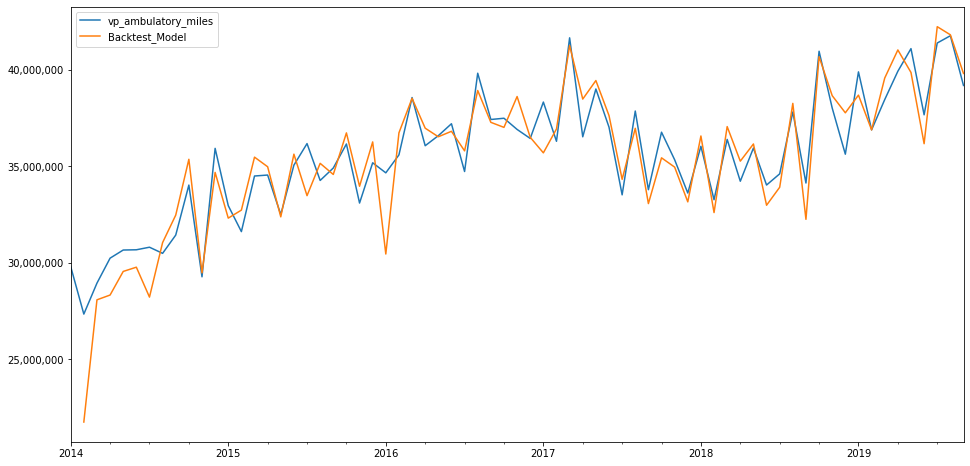

In [282]:
# plot backtest

ts.plot_fit(train[series], backtest, train)

In [283]:
# oos predictions

predictions = ts.make_predictions(model,
                               series + ' SARIMAX',
                               start=len(train)+1,
                               end= len(train) + len(oos_exog)-1,
                               exog_data=oos_exog)

In [284]:
# prediction conf intervals

intervals = ts.get_oos_conf_interval(model=model,
                                     steps_ahead=horizon,
                                     exog_data = oos_exog)

In [285]:
intervals

,Predictions,lower vp_ambulatory_miles,upper vp_ambulatory_miles
2019-10-31,"43,041,553.64","40,509,978.14","45,573,129.13"
2019-11-30,"38,878,090.10","34,587,651.39","43,168,528.81"
2019-12-31,"40,610,288.27","34,530,439.77","46,690,136.77"
2020-01-31,"41,675,614.09","33,202,789.54","50,148,438.64"
2020-02-29,"38,435,365.06","27,406,976.35","49,463,753.77"
2020-03-31,"41,543,240.37","27,819,946.41","55,266,534.33"


In [286]:
# make df for plot

conf_df = ts.make_oos_plot_df(model=model,
                           steps_ahead=horizon,
                           exog_data = oos_exog)

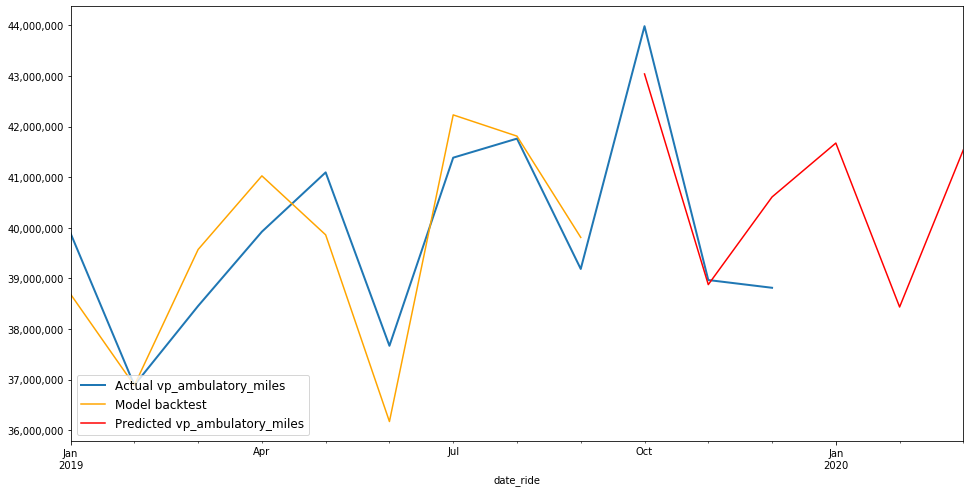

In [287]:
# plot oos

ts.plot_oos(conf_df, full, series, backtest, oos_exog, start_date='2019-01-01')

In [288]:
# make final series

vp_ambulatory_miles = ts.oos_weekly_df(model=model,
                                       steps_ahead=horizon,
                                       exog_data = oos_exog,
                                       series = series,
                                       add_date = False)

vp_ambulatory_miles

,vp_ambulatory_miles,lower_vp_ambulatory_miles,upper_vp_ambulatory_miles
2019-10-31,"43,041,553.64","40,509,978.14","45,573,129.13"
2019-11-30,"38,878,090.10","34,587,651.39","43,168,528.81"
2019-12-31,"40,610,288.27","34,530,439.77","46,690,136.77"
2020-01-31,"41,675,614.09","33,202,789.54","50,148,438.64"
2020-02-29,"38,435,365.06","27,406,976.35","49,463,753.77"
2020-03-31,"41,543,240.37","27,819,946.41","55,266,534.33"


# Ver Pd Stretcher Rides

In [289]:
series = 'vp_stretcher_rides'

In [301]:
model = ts.build_model(train[series],
                       p=1,
                       d=1,
                       q=1,
                       S=6,
                       exog_data = train['service_days'],
                       P=1,
                       D=1,
                       Q=0)

model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                
=========================================================================================
Dep. Variable:                vp_stretcher_rides   No. Observations:                   69
Model:             SARIMAX(1, 1, 1)x(1, 1, 0, 6)   Log Likelihood                -577.455
Date:                           Wed, 11 Mar 2020   AIC                           1164.910
Time:                                   13:50:11   BIC                           1175.545
Sample:                               01-31-2014   HQIC                          1169.086
                                    - 09-30-2019                                         
Covariance Type:                             opg                                         
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
service_days  2572.0602    197.479     13.024      0.000    2185.008    2959.113
ar.L1           -0.9097      0.079    -11.548      0.000      -1.064      -0.755
ma.L1            0.9997      0.143      7.005      0.000       0.720       1.279
ar.S.L6         -0.5090      0.124     -4.106      0.000      -0.752      -0.266
sigma2        7.061e+06      0.000   2.01e+10      0.000    7.06e+06    7.06e+06
===================================================================================
Ljung-Box (Q):                       39.87   Jarque-Bera (JB):                28.66
Prob(Q):                              0.48   Prob(JB):                         0.00
Heteroskedasticity (H):               2.40   Skew:                            -1.06
Prob(H) (two-sided):                  0.05   Kurtosis:                         5.56
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 3.12e+27. Standard errors may be unstable.
"""

In [302]:
ts.get_dw(model)

2.064177298635841

In [305]:
backtest = ts.backtest_model(model,
                             train = train,
                             exog_data=train['service_days'][1:],
                             end = len(train)-1)

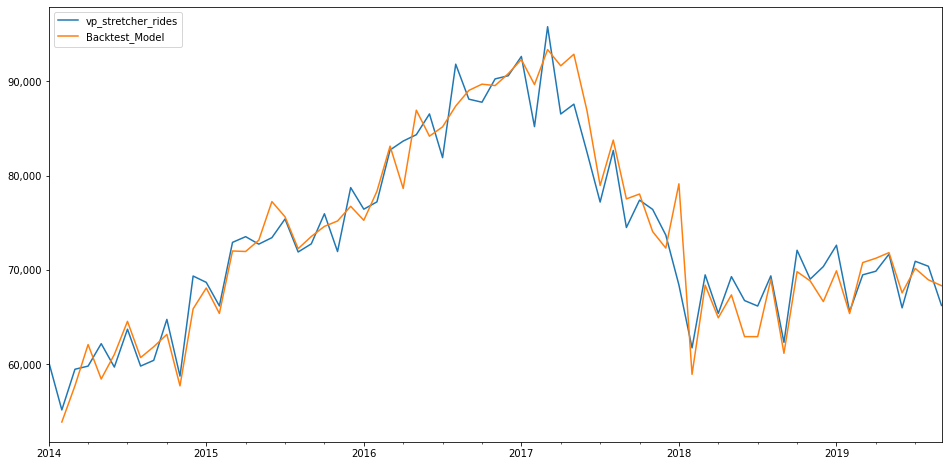

In [306]:
# plot backtest

ts.plot_fit(train[series], backtest, train)

In [307]:
# make predictions

predictions = ts.make_predictions(model,
                               series + ' SARIMAX',
                               start=len(train)+1,
                               end= len(train) + len(oos_exog)-1,
                               exog_data=oos_exog)

In [308]:
# prediction conf intervals

intervals = ts.get_oos_conf_interval(model=model,
                                     steps_ahead=horizon,
                                     exog_data = oos_exog)

In [309]:
intervals

,Predictions,lower vp_stretcher_rides,upper vp_stretcher_rides
2019-10-31,"71,688.99","66,451.18","76,926.81"
2019-11-30,"66,196.10","58,492.05","73,900.16"
2019-12-31,"70,868.87","61,531.93","80,205.81"
2020-01-31,"71,467.56","60,571.90","82,363.22"
2020-02-29,"64,890.50","52,771.62","77,009.37"
2020-03-31,"70,758.72","57,413.66","84,103.77"


In [310]:
# make df for oos

conf_df = ts.make_oos_plot_df(model=model,
                           steps_ahead=horizon,
                           exog_data = oos_exog)

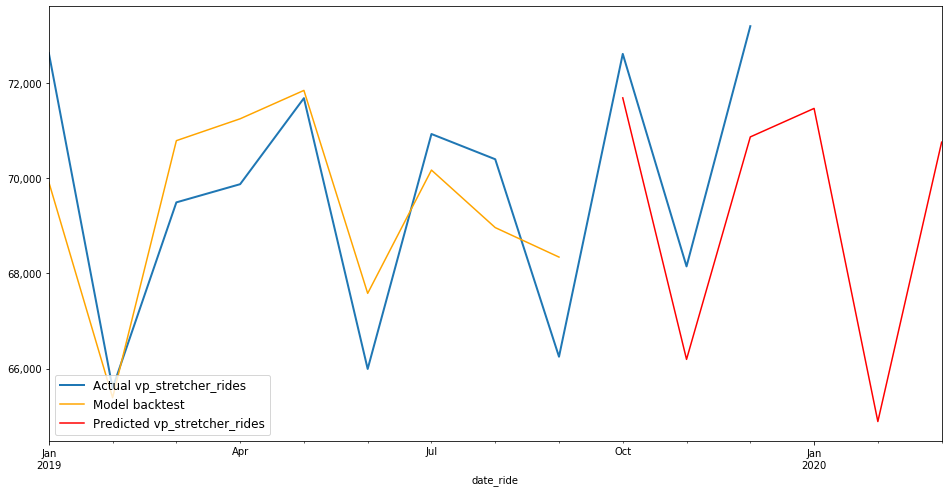

In [311]:
# plot oos

ts.plot_oos(conf_df, full, series, backtest, oos_exog, start_date='2019-01-01')

In [312]:
# make final series

vp_stretcher_rides = ts.oos_weekly_df(model=model,
                                      steps_ahead=horizon,
                                      exog_data = oos_exog,
                                      series = series,
                                      add_date = False)

vp_stretcher_rides

,vp_stretcher_rides,lower_vp_stretcher_rides,upper_vp_stretcher_rides
2019-10-31,"71,688.99","66,451.18","76,926.81"
2019-11-30,"66,196.10","58,492.05","73,900.16"
2019-12-31,"70,868.87","61,531.93","80,205.81"
2020-01-31,"71,467.56","60,571.90","82,363.22"
2020-02-29,"64,890.50","52,771.62","77,009.37"
2020-03-31,"70,758.72","57,413.66","84,103.77"


# Ver Pd Stretcher Costs

In [348]:
series = 'vp_stretcher_costs'

In [349]:
model = ts.build_model(train[series],
                       p=0,
                       d=2,
                       q=1,
                       S=12,
                       exog_data = train['service_days'],
                       P=0,
                       D=1,
                       Q=1)

model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                 vp_stretcher_costs   No. Observations:                   69
Model:             SARIMAX(0, 2, 1)x(0, 1, 1, 12)   Log Likelihood                -784.809
Date:                            Wed, 11 Mar 2020   AIC                           1577.618
Time:                                    14:00:43   BIC                           1585.647
Sample:                                01-31-2014   HQIC                          1580.723
                                     - 09-30-2019                                         
Covariance Type:                              opg                                         
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
service_days  2.161e+05   2.66e+04      8.113      0.000    1.64e+05    2.68e+05
ma.L1           -0.9341      0.090    -10.363      0.000      -1.111      -0.757
ma.S.L12        -0.5926      0.164     -3.615      0.000      -0.914      -0.271
sigma2        1.894e+11      0.006   3.11e+13      0.000    1.89e+11    1.89e+11
===================================================================================
Ljung-Box (Q):                       42.58   Jarque-Bera (JB):                11.54
Prob(Q):                              0.36   Prob(JB):                         0.00
Heteroskedasticity (H):               0.79   Skew:                             0.70
Prob(H) (two-sided):                  0.61   Kurtosis:                         4.76
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 6.76e+29. Standard errors may be unstable.
"""

In [350]:
ts.get_dw(model)

1.9475291986817522

In [351]:
backtest = ts.backtest_model(model,
                             train = train,
                             exog_data=train['service_days'][1:],
                             end = len(train)-1)

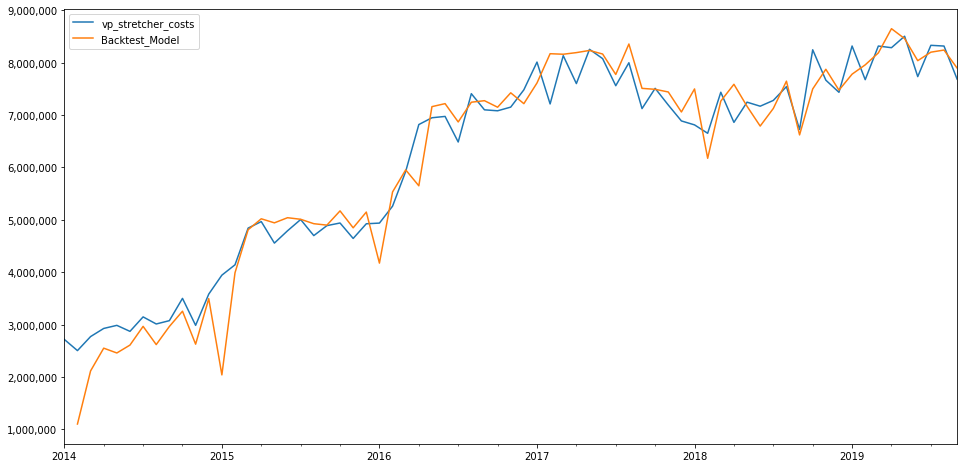

In [352]:
# plot backtest

ts.plot_fit(train[series], backtest, train)

In [353]:
# predict oos

predictions = ts.make_predictions(model,
                               series + ' SARIMAX',
                               start=len(train)+1,
                               end= len(train) + len(oos_exog)-1,
                               exog_data=oos_exog)

In [354]:
# conf intervals for predictions

intervals = ts.get_oos_conf_interval(model=model,
                                     steps_ahead=horizon,
                                     exog_data = oos_exog)

In [355]:
intervals

,Predictions,lower vp_stretcher_costs,upper vp_stretcher_costs
2019-10-31,"8,557,880.81","7,704,035.89","9,411,725.74"
2019-11-30,"7,862,666.71","6,614,298.62","9,111,034.79"
2019-12-31,"8,073,756.34","6,494,153.43","9,653,359.26"
2020-01-31,"8,411,552.11","6,528,542.32","10,294,561.89"
2020-02-29,"7,902,587.41","5,730,838.28","10,074,336.53"
2020-03-31,"8,660,742.72","6,208,441.65","11,113,043.80"


In [356]:
# make df for oos plot

conf_df = ts.make_oos_plot_df(model=model,
                           steps_ahead=horizon,
                           exog_data = oos_exog)

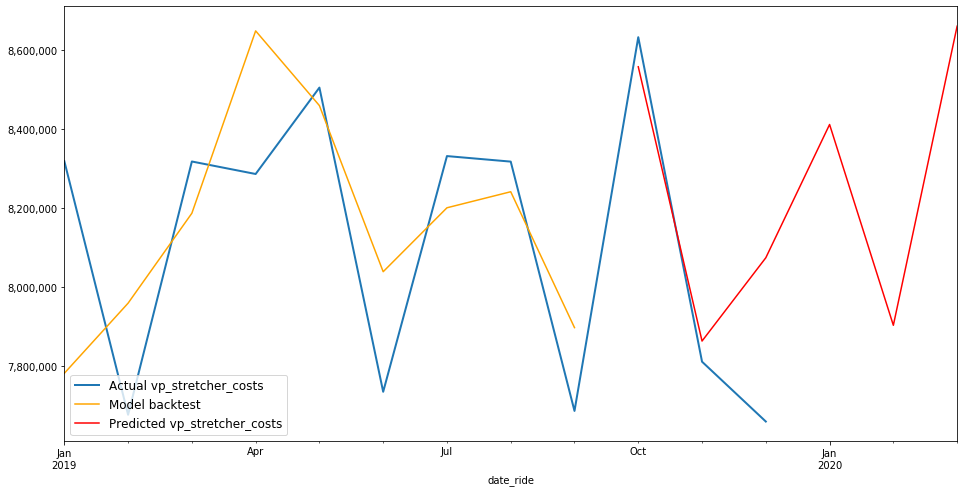

In [357]:
# plot oos

ts.plot_oos(conf_df, full, series, backtest, oos_exog, start_date='2019-01-01')

In [358]:
# make final series

vp_stretcher_costs = ts.oos_weekly_df(model=model,
                                      steps_ahead=horizon,
                                      exog_data = oos_exog,
                                      series = series,
                                      add_date = False)

vp_stretcher_costs

,vp_stretcher_costs,lower_vp_stretcher_costs,upper_vp_stretcher_costs
2019-10-31,"8,557,880.81","7,704,035.89","9,411,725.74"
2019-11-30,"7,862,666.71","6,614,298.62","9,111,034.79"
2019-12-31,"8,073,756.34","6,494,153.43","9,653,359.26"
2020-01-31,"8,411,552.11","6,528,542.32","10,294,561.89"
2020-02-29,"7,902,587.41","5,730,838.28","10,074,336.53"
2020-03-31,"8,660,742.72","6,208,441.65","11,113,043.80"


# Ver Pd Stretcher Miles

In [359]:
series = 'vp_stretcher_miles'

In [379]:
model = ts.build_model(train[series],
                       p=1,
                       d=1,
                       q=0,
                       S=4,
                       exog_data = train['service_days'],
                       P=1,
                       D=1,
                       Q=0)

model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                
=========================================================================================
Dep. Variable:                vp_stretcher_miles   No. Observations:                   69
Model:             SARIMAX(1, 1, 0)x(1, 1, 0, 4)   Log Likelihood                -754.254
Date:                           Wed, 11 Mar 2020   AIC                           1516.509
Time:                                   14:12:02   BIC                           1525.144
Sample:                               01-31-2014   HQIC                          1519.911
                                    - 09-30-2019                                         
Covariance Type:                             opg                                         
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
service_days  2.421e+04   2156.040     11.227      0.000       2e+04    2.84e+04
ar.L1           -0.2909      0.168     -1.729      0.084      -0.621       0.039
ar.S.L4         -0.3873      0.111     -3.490      0.000      -0.605      -0.170
sigma2         1.18e+09      0.007   1.64e+11      0.000    1.18e+09    1.18e+09
===================================================================================
Ljung-Box (Q):                       35.51   Jarque-Bera (JB):                 0.43
Prob(Q):                              0.67   Prob(JB):                         0.81
Heteroskedasticity (H):               2.27   Skew:                            -0.16
Prob(H) (two-sided):                  0.07   Kurtosis:                         3.24
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 9.24e+26. Standard errors may be unstable.
"""

In [380]:
ts.get_dw(model)

1.9453585518950962

In [381]:
backtest = ts.backtest_model(model,
                             train = train,
                             exog_data=train['service_days'][1:],
                             end = len(train)-1)

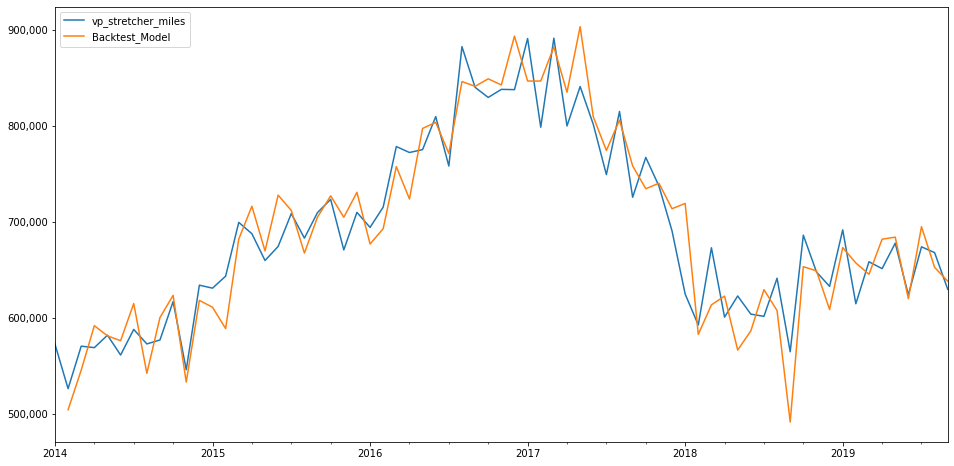

In [382]:
# plot backtest

ts.plot_fit(train[series], backtest, train)

In [383]:
# predict oos

predictions = ts.make_predictions(model,
                               series + ' SARIMAX',
                               start=len(train) + 1,
                               end= len(train) + len(oos_exog)-1,
                               exog_data=oos_exog)

In [384]:
# conf intervals for predictions

intervals = ts.get_oos_conf_interval(model=model,
                                     steps_ahead=horizon,
                                     exog_data = oos_exog)

In [385]:
intervals

,Predictions,lower vp_stretcher_miles,upper vp_stretcher_miles
2019-10-31,"692,215.77","624,887.92","759,543.61"
2019-11-30,"631,548.00","549,010.73","714,085.27"
2019-12-31,"647,688.38","549,361.28","746,015.48"
2020-01-31,"676,165.16","565,036.16","787,294.16"
2020-02-29,"619,592.60","474,351.37","764,833.84"
2020-03-31,"663,816.89","497,332.21","830,301.58"


In [386]:
# make df for oos plot

conf_df = ts.make_oos_plot_df(model=model,
                           steps_ahead=horizon,
                           exog_data = oos_exog)

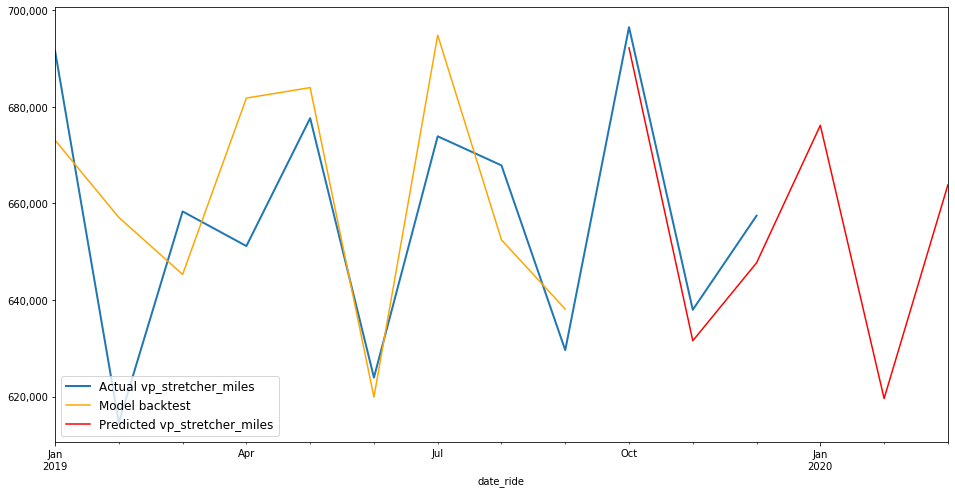

In [387]:
# plot oos

ts.plot_oos(conf_df, full, series, backtest, oos_exog, start_date='2019-01-01')

In [388]:
# make final series

vp_stretcher_miles = ts.oos_weekly_df(model=model,
                                      steps_ahead=horizon,
                                      exog_data = oos_exog,
                                      series = series,
                                      add_date = False)

vp_stretcher_miles

,vp_stretcher_miles,lower_vp_stretcher_miles,upper_vp_stretcher_miles
2019-10-31,"692,215.77","624,887.92","759,543.61"
2019-11-30,"631,548.00","549,010.73","714,085.27"
2019-12-31,"647,688.38","549,361.28","746,015.48"
2020-01-31,"676,165.16","565,036.16","787,294.16"
2020-02-29,"619,592.60","474,351.37","764,833.84"
2020-03-31,"663,816.89","497,332.21","830,301.58"


# Ver Pd Wheelchair Rides

In [389]:
series = 'vp_wheelchair_rides'

In [396]:
model = ts.build_model(train[series],
                       p=0,
                       d=2,
                       q=1,
                       S=12,
                       exog_data = train['service_days'],
                       P=0,
                       D=1,
                       Q=1)

model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                vp_wheelchair_rides   No. Observations:                   69
Model:             SARIMAX(0, 2, 1)x(0, 1, 1, 12)   Log Likelihood                -632.077
Date:                            Wed, 11 Mar 2020   AIC                           1272.155
Time:                                    14:32:20   BIC                           1280.184
Sample:                                01-31-2014   HQIC                          1275.260
                                     - 09-30-2019                                         
Covariance Type:                              opg                                         
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
service_days  2.061e+04   3962.851      5.200      0.000    1.28e+04    2.84e+04
ma.L1           -0.9263      0.194     -4.774      0.000      -1.307      -0.546
ma.S.L12        -0.7078      0.188     -3.773      0.000      -1.076      -0.340
sigma2        8.373e+08      0.055   1.53e+10      0.000    8.37e+08    8.37e+08
===================================================================================
Ljung-Box (Q):                       30.20   Jarque-Bera (JB):               160.19
Prob(Q):                              0.87   Prob(JB):                         0.00
Heteroskedasticity (H):               0.17   Skew:                             1.16
Prob(H) (two-sided):                  0.00   Kurtosis:                        11.03
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 3.57e+25. Standard errors may be unstable.
"""

In [397]:
ts.get_dw(model)

2.3498022515331716

In [404]:
backtest = ts.backtest_model(model,
                             train = train,
                             exog_data=train['service_days'][1:],
                             end = len(train)-1)

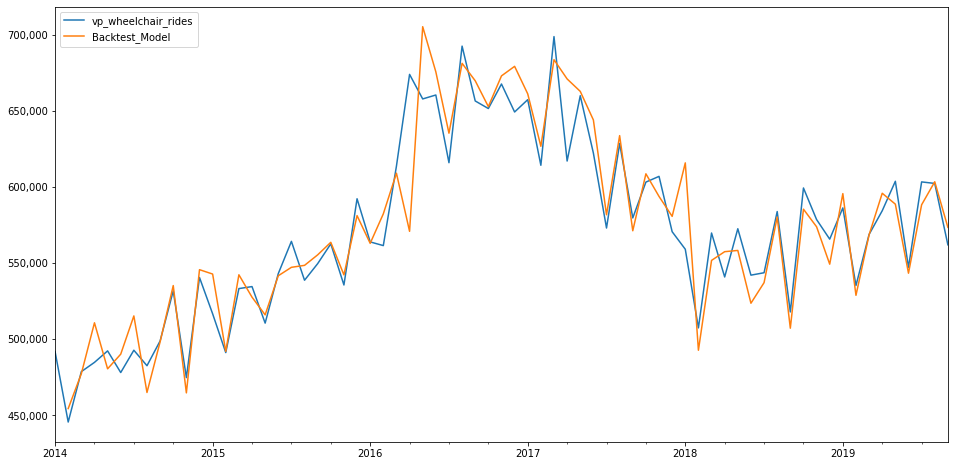

In [405]:
# plot backtest

ts.plot_fit(train[series], backtest, train)

In [406]:
# predictions

predictions = ts.make_predictions(model,
                               series + ' SARIMAX',
                               start=len(train) + 1,
                               end= len(train) + len(oos_exog)-1,
                               exog_data=oos_exog)

In [407]:
# make prediction intervals

intervals = ts.get_oos_conf_interval(model=model,
                                     steps_ahead=horizon,
                                     exog_data = oos_exog)

In [408]:
intervals

,Predictions,lower vp_wheelchair_rides,upper vp_wheelchair_rides
2019-10-31,"615,038.39","558,058.60","672,018.17"
2019-11-30,"571,561.10","487,907.82","655,214.38"
2019-12-31,"589,305.74","483,035.20","695,576.28"
2020-01-31,"595,864.43","468,677.57","723,051.29"
2020-02-29,"540,914.65","393,666.28","688,163.02"
2020-03-31,"595,131.42","428,262.27","762,000.57"


In [409]:
# make df for oos plot

conf_df = ts.make_oos_plot_df(model=model,
                           steps_ahead=horizon,
                           exog_data = oos_exog)

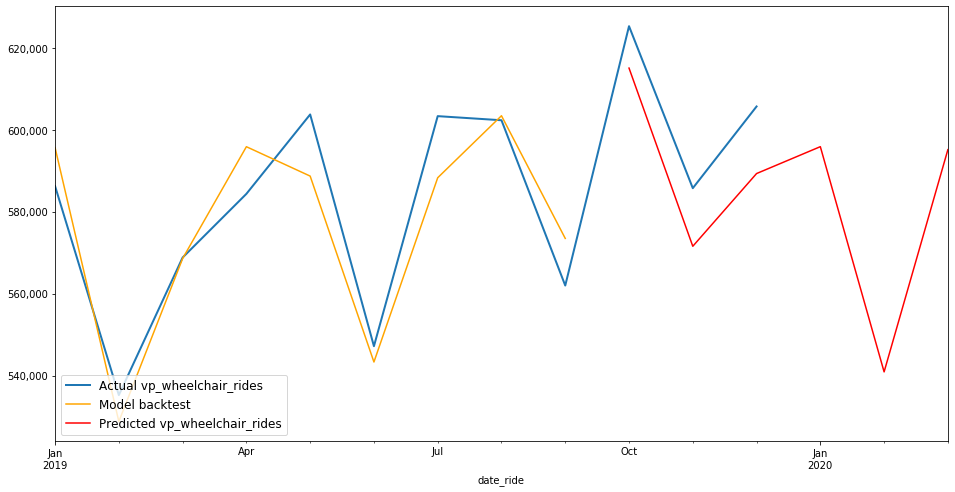

In [410]:
# plot oos

ts.plot_oos(conf_df, full, series, backtest, oos_exog, start_date='2019-01-01')

In [411]:
# make final series

vp_wheelchair_rides = ts.oos_weekly_df(model=model,
                                       steps_ahead=horizon,
                                       exog_data = oos_exog,
                                       series = series,
                                       add_date = False)

vp_wheelchair_rides

,vp_wheelchair_rides,lower_vp_wheelchair_rides,upper_vp_wheelchair_rides
2019-10-31,"615,038.39","558,058.60","672,018.17"
2019-11-30,"571,561.10","487,907.82","655,214.38"
2019-12-31,"589,305.74","483,035.20","695,576.28"
2020-01-31,"595,864.43","468,677.57","723,051.29"
2020-02-29,"540,914.65","393,666.28","688,163.02"
2020-03-31,"595,131.42","428,262.27","762,000.57"


# Ver Pd Wheelchair Costs

In [412]:
series = 'vp_wheelchair_costs'

In [439]:
model = ts.build_model(train[series],
                       p=0,
                       d=0,
                       q=2,
                       S=3,
                       exog_data = train['service_days'],
                       P=0,
                       D=1,
                       Q=2)

model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                
=========================================================================================
Dep. Variable:               vp_wheelchair_costs   No. Observations:                   69
Model:             SARIMAX(0, 0, 2)x(0, 1, 2, 3)   Log Likelihood                -976.687
Date:                           Wed, 11 Mar 2020   AIC                           1965.374
Time:                                   14:39:27   BIC                           1978.512
Sample:                               01-31-2014   HQIC                          1970.566
                                    - 09-30-2019                                         
Covariance Type:                             opg                                         
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
service_days  6.623e+05   3.74e+04     17.723      0.000    5.89e+05    7.36e+05
ma.L1            0.5871      0.121      4.847      0.000       0.350       0.825
ma.L2            0.4522      0.112      4.038      0.000       0.233       0.672
ma.S.L3         -0.3067      0.058     -5.269      0.000      -0.421      -0.193
ma.S.L6          0.1297      0.074      1.752      0.080      -0.015       0.275
sigma2        3.841e+11      0.023   1.69e+13      0.000    3.84e+11    3.84e+11
===================================================================================
Ljung-Box (Q):                       41.64   Jarque-Bera (JB):                40.62
Prob(Q):                              0.40   Prob(JB):                         0.00
Heteroskedasticity (H):               0.93   Skew:                            -0.35
Prob(H) (two-sided):                  0.86   Kurtosis:                         6.78
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 7.75e+27. Standard errors may be unstable.
"""

In [440]:
ts.get_dw(model)

1.0972341413970585

In [441]:
backtest = ts.backtest_model(model,
                             train = train,
                             exog_data=train['service_days'][1:],
                             end = len(train)-1)

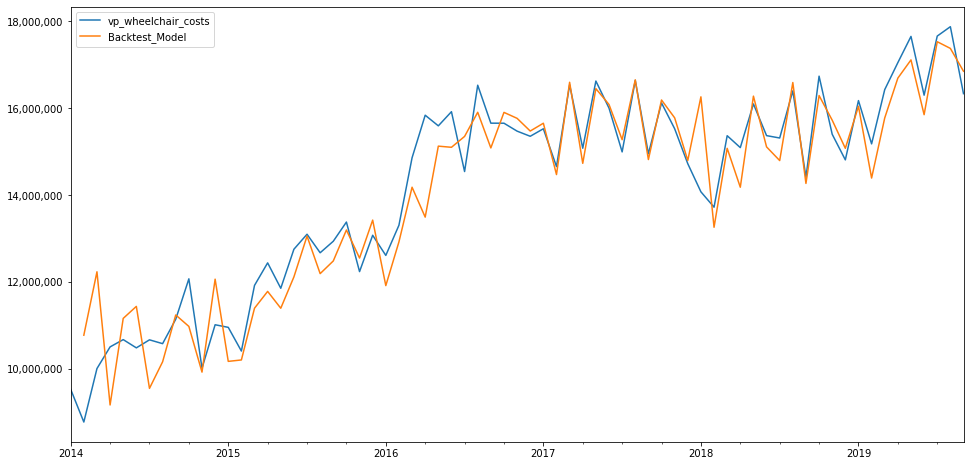

In [442]:
# plot backtest

ts.plot_fit(train[series], backtest, train)

In [443]:
# make predictions

predictions = ts.make_predictions(model,
                               series + ' SARIMAX',
                               start=len(train) + 1,
                               end= len(train) + len(oos_exog)-1,
                               exog_data=oos_exog)

In [444]:
# conf intervals for predictions

intervals = ts.get_oos_conf_interval(model=model,
                                     steps_ahead=horizon,
                                     exog_data = oos_exog)

In [445]:
intervals

,Predictions,lower vp_wheelchair_costs,upper vp_wheelchair_costs
2019-10-31,"17,863,919.69","16,649,172.85","19,078,666.53"
2019-11-30,"16,549,193.88","15,140,564.59","17,957,823.17"
2019-12-31,"17,171,153.07","15,659,192.95","18,683,113.20"
2020-01-31,"17,639,144.74","15,908,476.89","19,369,812.58"
2020-02-29,"16,390,702.54","14,590,796.86","18,190,608.22"
2020-03-31,"17,481,014.09","15,641,258.33","19,320,769.84"


In [446]:
# make df for oos plt

conf_df = ts.make_oos_plot_df(model=model,
                           steps_ahead=horizon,
                           exog_data = oos_exog)

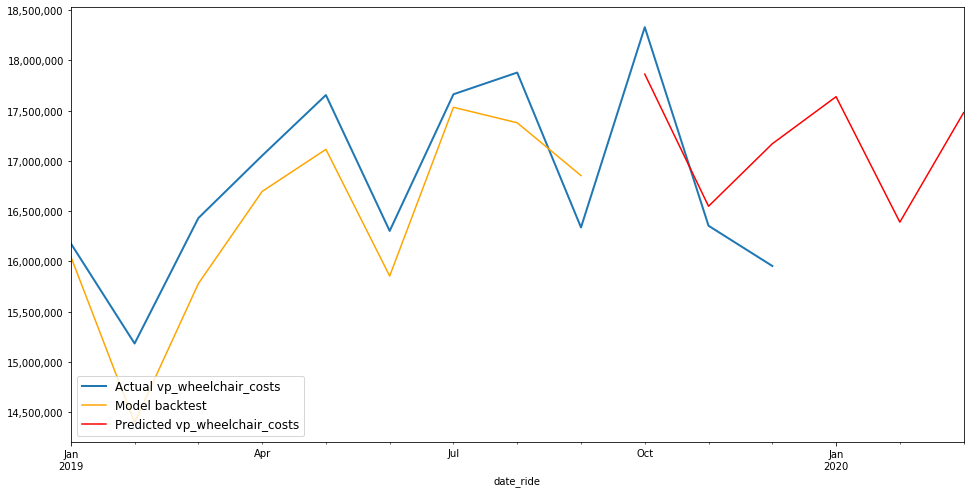

In [447]:
# plot oos

ts.plot_oos(conf_df, full, series, backtest, oos_exog, start_date='2019-01-01')

In [448]:
# make final series

vp_wheelchair_costs = ts.oos_weekly_df(model=model,
                                       steps_ahead=horizon,
                                       exog_data = oos_exog,
                                       series = series,
                                       add_date = False)

vp_wheelchair_costs

,vp_wheelchair_costs,lower_vp_wheelchair_costs,upper_vp_wheelchair_costs
2019-10-31,"17,863,919.69","16,649,172.85","19,078,666.53"
2019-11-30,"16,549,193.88","15,140,564.59","17,957,823.17"
2019-12-31,"17,171,153.07","15,659,192.95","18,683,113.20"
2020-01-31,"17,639,144.74","15,908,476.89","19,369,812.58"
2020-02-29,"16,390,702.54","14,590,796.86","18,190,608.22"
2020-03-31,"17,481,014.09","15,641,258.33","19,320,769.84"


# Ver Pd Wheelchair Miles

In [449]:
series = 'vp_wheelchair_miles'

In [450]:
# get the outlier
outlier = train[series].quantile(0.95)

# get the median
median = train[series].quantile(0.50)

# replace the outliers
train[series] = np.where(train[series] > outlier, median,train[series])

In [483]:
model = ts.build_model(train[series],
                       p=0,
                       d=1,
                       q=1,
                       S=12,
                       exog_data = train['service_days'],
                       P=0,
                       D=1,
                       Q=1)

model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                vp_wheelchair_miles   No. Observations:                   69
Model:             SARIMAX(0, 1, 1)x(0, 1, 1, 12)   Log Likelihood                -786.126
Date:                            Wed, 11 Mar 2020   AIC                           1580.251
Time:                                    14:56:02   BIC                           1588.353
Sample:                                01-31-2014   HQIC                          1583.392
                                     - 09-30-2019                                         
Covariance Type:                              opg                                         
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
service_days  8.406e+04   1.99e+04      4.215      0.000     4.5e+04    1.23e+05
ma.L1           -0.2831      0.151     -1.877      0.060      -0.579       0.012
ma.S.L12        -0.5001      0.163     -3.070      0.002      -0.819      -0.181
sigma2        1.182e+11      0.005    2.3e+13      0.000    1.18e+11    1.18e+11
===================================================================================
Ljung-Box (Q):                       51.70   Jarque-Bera (JB):                 0.51
Prob(Q):                              0.10   Prob(JB):                         0.77
Heteroskedasticity (H):               0.51   Skew:                            -0.22
Prob(H) (two-sided):                  0.15   Kurtosis:                         3.15
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 7.88e+28. Standard errors may be unstable.
"""

In [484]:
ts.get_dw(model)

1.381614748029567

In [485]:
backtest = ts.backtest_model(model,
                             train = train,
                             exog_data=train['service_days'][1:],
                             end = len(train)-1)

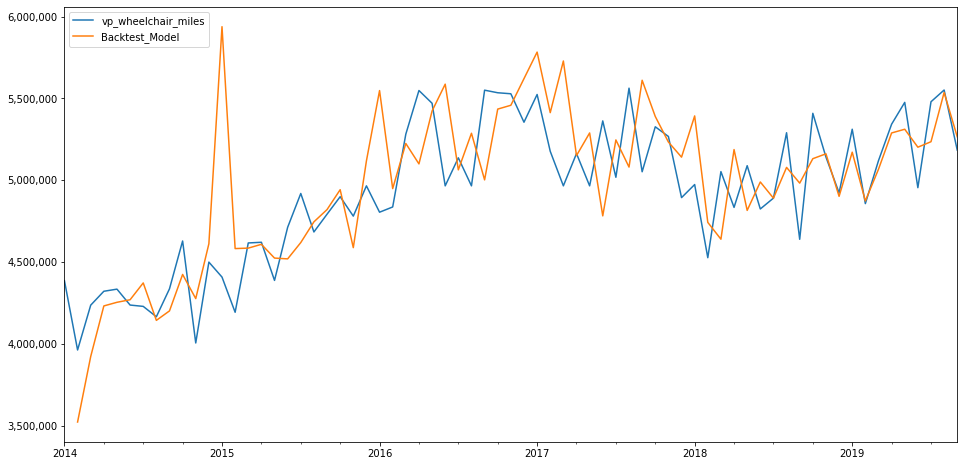

In [486]:
# plot backtest

ts.plot_fit(train[series], backtest, train)

In [487]:
# make predictions

predictions = ts.make_predictions(model,
                               series + ' SARIMAX',
                               start=len(train) + 1,
                               end= len(train) + len(oos_exog)-1,
                               exog_data=oos_exog)

In [488]:
# conf intervals for predictions

intervals = ts.get_oos_conf_interval(model=model,
                                     steps_ahead=horizon,
                                     exog_data = oos_exog)

In [489]:
intervals

,Predictions,lower vp_wheelchair_miles,upper vp_wheelchair_miles
2019-10-31,"5,705,537.11","5,031,501.93","6,379,572.30"
2019-11-30,"5,403,240.65","4,573,895.91","6,232,585.40"
2019-12-31,"5,338,990.33","4,379,148.18","6,298,832.49"
2020-01-31,"5,576,769.80","4,502,174.96","6,651,364.64"
2020-02-29,"5,150,038.44","3,971,814.70","6,328,262.18"
2020-03-31,"5,467,969.22","4,194,521.83","6,741,416.62"


In [490]:
# make df for oos plt

conf_df = ts.make_oos_plot_df(model=model,
                           steps_ahead=horizon,
                           exog_data = oos_exog)

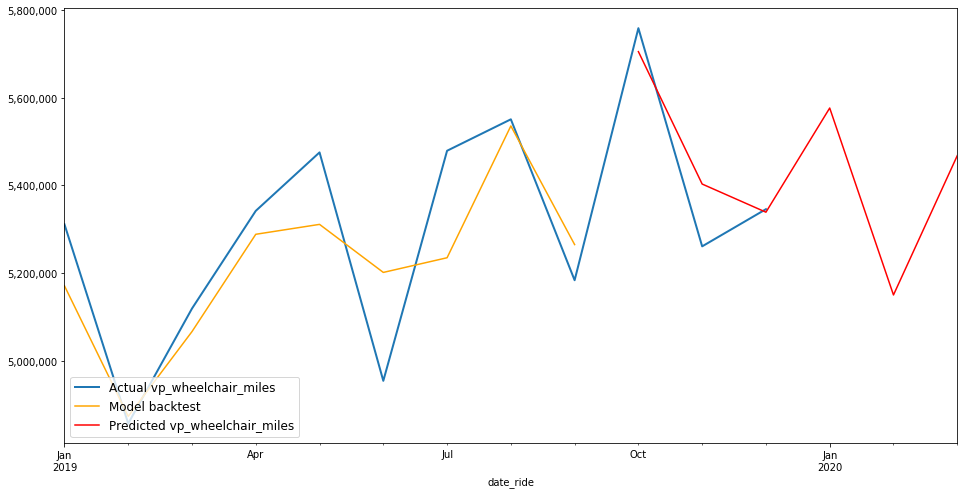

In [491]:
# plot oos

ts.plot_oos(conf_df, full, series, backtest, oos_exog, start_date='2019-01-01')

In [492]:
# make final series

vp_wheelchair_miles = ts.oos_weekly_df(model=model,
                                       steps_ahead=horizon,
                                       exog_data = oos_exog,
                                       series = series,
                                       add_date = False)

vp_wheelchair_miles

,vp_wheelchair_miles,lower_vp_wheelchair_miles,upper_vp_wheelchair_miles
2019-10-31,"5,705,537.11","5,031,501.93","6,379,572.30"
2019-11-30,"5,403,240.65","4,573,895.91","6,232,585.40"
2019-12-31,"5,338,990.33","4,379,148.18","6,298,832.49"
2020-01-31,"5,576,769.80","4,502,174.96","6,651,364.64"
2020-02-29,"5,150,038.44","3,971,814.70","6,328,262.18"
2020-03-31,"5,467,969.22","4,194,521.83","6,741,416.62"


# CPM

In [493]:
series = 'cpm'

In [494]:
train[series].describe()

count   69.00
mean     2.35
std      0.19
min      1.93
25%      2.23
50%      2.43
75%      2.51
max      2.56
Name: cpm, dtype: float64

In [551]:
# get the outlier
outlier = train[series].quantile(.05)

# get the median
median = train[series].quantile(0.50)

# replace the outliers
train[series] = np.where(train[series] < outlier, median,train[series])

print(outlier)
print(median)
train[series].describe()

2.004966346013986
2.4260672709589346


count   69.00
mean     2.39
std      0.15
min      2.01
25%      2.26
50%      2.43
75%      2.51
max      2.56
Name: cpm, dtype: float64

In [562]:
train.index = pd.DatetimeIndex(train.index.values,
                               freq=train.index.inferred_freq)

model = ts.build_model(train[series],
                       p=0,
                       d=1,
                       q=1,
                       S=6,
                       exog_data = None,
                       P=1,
                       D=1,
                       Q=0)

model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                
=========================================================================================
Dep. Variable:                               cpm   No. Observations:                   69
Model:             SARIMAX(0, 1, 1)x(1, 1, 0, 6)   Log Likelihood                  55.326
Date:                           Wed, 11 Mar 2020   AIC                           -104.651
Time:                                   15:07:58   BIC                            -98.270
Sample:                               01-31-2014   HQIC                          -102.146
                                    - 09-30-2019                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.4083      0.088     -4.665      0.000      -0.580      -0.237
ar.S.L6       -0.6983      0.046    -15.114      0.000      -0.789      -0.608
sigma2         0.0092      0.001      9.349      0.000       0.007       0.011
===================================================================================
Ljung-Box (Q):                       43.46   Jarque-Bera (JB):                59.12
Prob(Q):                              0.33   Prob(JB):                         0.00
Heteroskedasticity (H):               0.03   Skew:                             1.07
Prob(H) (two-sided):                  0.00   Kurtosis:                         7.28
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [563]:
ts.get_dw(model)

1.2614556763118536

In [564]:
backtest = ts.backtest_model(model,
                             train = train,
                             exog_data=None,
                             # exog_data=train['service_days'][1:],
                             end = len(train)-1)

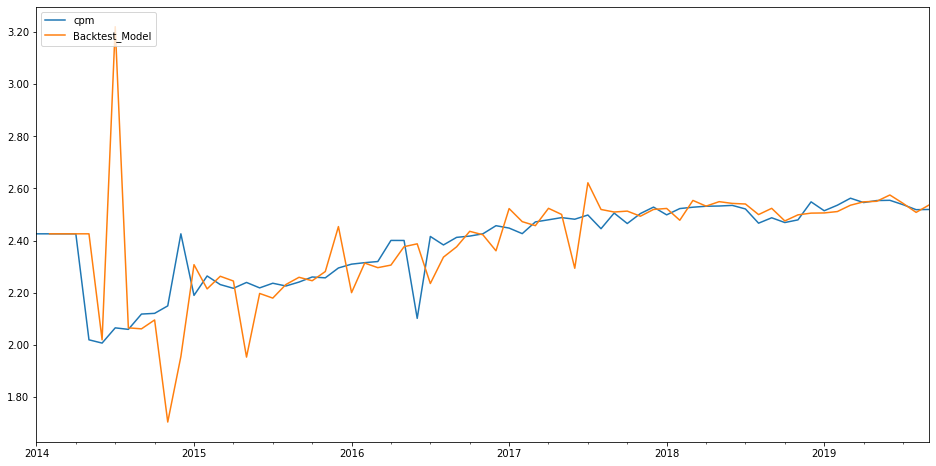

In [565]:
# plt the backtest

ts.plot_fit(train[series], backtest, train, decimal = True)

In [566]:
# predict oos

predictions = ts.make_predictions(model,
                               series + ' SARIMAX',
                               start=len(train) + 1,
                               end= len(train) + len(oos_exog)-1,
                               exog_data=None)

In [567]:
# conf intervals for oos

intervals = ts.get_oos_conf_interval(model=model,
                                     steps_ahead=horizon,
                                     exog_data = None)

In [568]:
intervals

,Predictions,lower cpm,upper cpm
2019-10-31,2.51,2.32,2.70
2019-11-30,2.52,2.30,2.74
2019-12-31,2.57,2.32,2.81
2020-01-31,2.54,2.27,2.81
2020-02-29,2.55,2.26,2.84
2020-03-31,2.57,2.25,2.88


In [569]:
# make df for plotting

conf_df = ts.make_oos_plot_df(model=model,
                           steps_ahead=horizon,
                           exog_data = None)

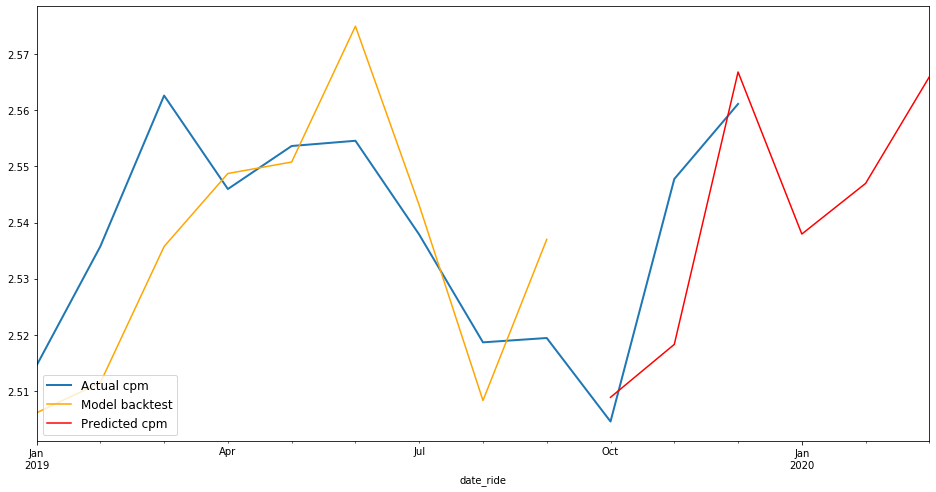

In [570]:
# plot oos 

ts.plot_oos(conf_df, full, series, backtest, oos_exog, start_date='2019-01-01', decimal = True)

In [571]:
# Make final series

cpm_fcast = ts.oos_weekly_df(model=model,
                       steps_ahead=horizon,
                       exog_data = oos_exog,
                       series = series,
                       add_date = False)

cpm_fcast

//anaconda3/envs/timeseries36/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:1935: ValueWarning: Exogenous array provided to predict, but additional data not required. `exog` argument ignored.
  ' required. `exog` argument ignored.', ValueWarning)


,cpm,lower_cpm,upper_cpm
2019-10-31,2.51,2.32,2.70
2019-11-30,2.52,2.30,2.74
2019-12-31,2.57,2.32,2.81
2020-01-31,2.54,2.27,2.81
2020-02-29,2.55,2.26,2.84
2020-03-31,2.57,2.25,2.88


# Begin to Combine Data Frames

In [572]:
list_cols = list(mdf.columns)

# change holiday to holidays

list_cols[1] = 'holidays'


list_cols

['holiday',
 'holidays',
 'vp_rides',
 'vp_costs',
 'vp_miles',
 'vp_ambulatory_rides',
 'vp_ambulatory_costs',
 'vp_ambulatory_miles',
 'vp_stretcher_rides',
 'vp_stretcher_costs',
 'vp_stretcher_miles',
 'vp_wheelchair_rides',
 'vp_wheelchair_costs',
 'vp_wheelchair_miles',
 'riders',
 'cpm',
 'service_days']

In [573]:
# remove riders and gross rides
exclude = ['date_ride', 'gross_rides', 'riders', 'holiday', 'holidays', 'cpm', 'service_days']
vp_cols = [e for e in list_cols if e not in exclude]

vp_cols


['vp_rides',
 'vp_costs',
 'vp_miles',
 'vp_ambulatory_rides',
 'vp_ambulatory_costs',
 'vp_ambulatory_miles',
 'vp_stretcher_rides',
 'vp_stretcher_costs',
 'vp_stretcher_miles',
 'vp_wheelchair_rides',
 'vp_wheelchair_costs',
 'vp_wheelchair_miles']

In [574]:
# make a list of dataframes using the columns
service_days = oos_exog

# create empty list
vp_df = []

for df in vp_cols:
    # use eval to handle the string name as actual df
    df = pd.DataFrame(eval(df))
    vp_df.append(df)
    

vp_df

[               vp_rides  lower_vp_rides  upper_vp_rides
 2019-10-31 2,892,957.54    2,633,303.73    3,152,611.35
 2019-11-30 2,590,860.49    2,215,068.43    2,966,652.54
 2019-12-31 2,712,286.38    2,241,452.52    3,183,120.25
 2020-01-31 2,802,755.47    2,246,787.37    3,358,723.56
 2020-02-29 2,633,412.09    1,944,204.55    3,322,619.63
 2020-03-31 2,854,900.78    2,045,758.39    3,664,043.18,
                 vp_costs  lower_vp_costs  upper_vp_costs
 2019-10-31 86,305,069.53   79,726,388.79   92,883,750.26
 2019-11-30 76,829,486.78   66,411,718.91   87,247,254.66
 2019-12-31 77,122,349.08   62,179,571.65   92,065,126.50
 2020-01-31 77,459,739.22   56,553,413.18   98,366,065.27
 2020-02-29 70,666,837.07   43,679,609.31   97,654,064.83
 2020-03-31 73,921,930.15   40,271,568.23  107,572,292.07,
                 vp_miles  lower_vp_miles  upper_vp_miles
 2019-10-31 35,663,550.75   32,364,648.93   38,962,452.57
 2019-11-30 31,443,977.36   27,476,440.33   35,411,514.39
 2019-12-31 32,807,

In [575]:
# concat them all into a single df
combined_wide = pd.concat(vp_df, axis = 1)
combined_wide

,vp_rides,lower_vp_rides,upper_vp_rides,vp_costs,lower_vp_costs,upper_vp_costs,vp_miles,lower_vp_miles,upper_vp_miles,vp_ambulatory_rides,lower_vp_ambulatory_rides,upper_vp_ambulatory_rides,vp_ambulatory_costs,lower_vp_ambulatory_costs,upper_vp_ambulatory_costs,vp_ambulatory_miles,lower_vp_ambulatory_miles,upper_vp_ambulatory_miles,vp_stretcher_rides,lower_vp_stretcher_rides,upper_vp_stretcher_rides,vp_stretcher_costs,lower_vp_stretcher_costs,upper_vp_stretcher_costs,vp_stretcher_miles,lower_vp_stretcher_miles,upper_vp_stretcher_miles,vp_wheelchair_rides,lower_vp_wheelchair_rides,upper_vp_wheelchair_rides,vp_wheelchair_costs,lower_vp_wheelchair_costs,upper_vp_wheelchair_costs,vp_wheelchair_miles,lower_vp_wheelchair_miles,upper_vp_wheelchair_miles
2019-10-31,"2,892,957.54","2,633,303.73","3,152,611.35","86,305,069.53","79,726,388.79","92,883,750.26","35,663,550.75","32,364,648.93","38,962,452.57","3,488,509.57","3,247,688.67","3,729,330.48","59,794,997.99","55,758,810.94","63,831,185.04","43,041,553.64","40,509,978.14","45,573,129.13","71,688.99","66,451.18","76,926.81","8,557,880.81","7,704,035.89","9,411,725.74","692,215.77","624,887.92","759,543.61","615,038.39","558,058.60","672,018.17","17,863,919.69","16,649,172.85","19,078,666.53","5,705,537.11","5,031,501.93","6,379,572.30"
2019-11-30,"2,590,860.49","2,215,068.43","2,966,652.54","76,829,486.78","66,411,718.91","87,247,254.66","31,443,977.36","27,476,440.33","35,411,514.39","3,124,550.85","2,771,368.10","3,477,733.61","56,249,176.51","51,263,642.42","61,234,710.60","38,878,090.10","34,587,651.39","43,168,528.81","66,196.10","58,492.05","73,900.16","7,862,666.71","6,614,298.62","9,111,034.79","631,548.00","549,010.73","714,085.27","571,561.10","487,907.82","655,214.38","16,549,193.88","15,140,564.59","17,957,823.17","5,403,240.65","4,573,895.91","6,232,585.40"
2019-12-31,"2,712,286.38","2,241,452.52","3,183,120.25","77,122,349.08","62,179,571.65","92,065,126.50","32,807,101.04","28,081,293.17","37,532,908.91","3,282,349.00","2,834,191.55","3,730,506.45","58,451,155.89","53,023,890.61","63,878,421.18","40,610,288.27","34,530,439.77","46,690,136.77","70,868.87","61,531.93","80,205.81","8,073,756.34","6,494,153.43","9,653,359.26","647,688.38","549,361.28","746,015.48","589,305.74","483,035.20","695,576.28","17,171,153.07","15,659,192.95","18,683,113.20","5,338,990.33","4,379,148.18","6,298,832.49"
2020-01-31,"2,802,755.47","2,246,787.37","3,358,723.56","77,459,739.22","56,553,413.18","98,366,065.27","34,486,214.99","29,164,490.98","39,807,938.99","3,381,848.83","2,846,192.71","3,917,504.94","62,384,643.52","56,728,310.60","68,040,976.44","41,675,614.09","33,202,789.54","50,148,438.64","71,467.56","60,571.90","82,363.22","8,411,552.11","6,528,542.32","10,294,561.89","676,165.16","565,036.16","787,294.16","595,864.43","468,677.57","723,051.29","17,639,144.74","15,908,476.89","19,369,812.58","5,576,769.80","4,502,174.96","6,651,364.64"
2020-02-29,"2,633,412.09","1,944,204.55","3,322,619.63","70,666,837.07","43,679,609.31","97,654,064.83","32,305,262.49","26,431,117.61","38,179,407.37","3,112,417.28","2,493,064.75","3,731,769.80","56,558,697.59","50,775,585.63","62,341,809.55","38,435,365.06","27,406,976.35","49,463,753.77","64,890.50","52,771.62","77,009.37","7,902,587.41","5,730,838.28","10,074,336.53","619,592.60","474,351.37","764,833.84","540,914.65","393,666.28","688,163.02","16,390,702.54","14,590,796.86","18,190,608.22","5,150,038.44","3,971,814.70","6,328,262.18"
2020-03-31,"2,854,900.78","2,045,758.39","3,664,043.18","73,921,930.15","40,271,568.23","107,572,292.07","35,389,706.40","29,015,965.77","41,763,447.03","3,427,216.91","2,726,169.32","4,128,264.50","60,057,072.63","53,230,346.91","66,883,798.34","41,543,240.37","27,819,946.41","55,266,534.33","70,758.72","57,413.66","84,103.77","8,660,742.72","6,208,441.65","11,113,043.80","663,816.89","497,332.21","830,301.58","595,131.42","428,262.27","762,000.57","17,481,014.09","15,641,258.33","19,320,769.84","5,467,969.22"

In [576]:
# SKIP THIS STEP
# truncate the series to remove past

# week_incr = 1

# begin = short_horizon + week_incr

# combined_wide_red = combined_wide.iloc[begin:]
# combined_wide_red.head()

In [577]:
len(service_days)

6

In [578]:
service_days

,service_days
end_month,
2019-10-31,23.00
2019-11-30,20.50
2019-12-31,21.50
2020-01-31,22.50
2020-02-29,20.00
2020-03-31,22.00


In [579]:
gross_rides_fcast

,gross_rides,lower_gross_rides,upper_gross_rides,fcast_date
2020-01-31,"3,920,980.03","3,637,423.01","4,204,537.05",2020-03-10
2020-02-29,"3,454,615.88","2,929,531.53","3,979,700.22",2020-03-10
2020-03-31,"3,616,279.13","2,776,341.31","4,456,216.95",2020-03-10
2020-04-30,"3,564,536.70","2,373,225.70","4,755,847.71",2020-03-10


In [580]:
riders_fcast

,riders,lower_riders,upper_riders
2020-01-31,"1,923,753.29","1,767,537.75","2,079,968.83"
2020-02-29,"1,709,246.03","1,437,800.07","1,980,691.98"
2020-03-31,"1,811,294.39","1,376,129.77","2,246,459.01"
2020-04-30,"1,794,900.66","1,184,567.55","2,405,233.77"


In [581]:
cpm_fcast

,cpm,lower_cpm,upper_cpm
2019-10-31,2.51,2.32,2.70
2019-11-30,2.52,2.30,2.74
2019-12-31,2.57,2.32,2.81
2020-01-31,2.54,2.27,2.81
2020-02-29,2.55,2.26,2.84
2020-03-31,2.57,2.25,2.88


In [582]:
cpm_fcast

,cpm,lower_cpm,upper_cpm
2019-10-31,2.51,2.32,2.70
2019-11-30,2.52,2.30,2.74
2019-12-31,2.57,2.32,2.81
2020-01-31,2.54,2.27,2.81
2020-02-29,2.55,2.26,2.84
2020-03-31,2.57,2.25,2.88


In [585]:
# concatonate them all


all_forecasts = pd.concat([service_days, gross_rides_fcast, riders_fcast, cpm_fcast, combined_wide], axis = 1)
all_forecasts


,service_days,gross_rides,lower_gross_rides,upper_gross_rides,fcast_date,riders,lower_riders,upper_riders,cpm,lower_cpm,upper_cpm,vp_rides,lower_vp_rides,upper_vp_rides,vp_costs,lower_vp_costs,upper_vp_costs,vp_miles,lower_vp_miles,upper_vp_miles,vp_ambulatory_rides,lower_vp_ambulatory_rides,upper_vp_ambulatory_rides,vp_ambulatory_costs,lower_vp_ambulatory_costs,upper_vp_ambulatory_costs,vp_ambulatory_miles,lower_vp_ambulatory_miles,upper_vp_ambulatory_miles,vp_stretcher_rides,lower_vp_stretcher_rides,upper_vp_stretcher_rides,vp_stretcher_costs,lower_vp_stretcher_costs,upper_vp_stretcher_costs,vp_stretcher_miles,lower_vp_stretcher_miles,upper_vp_stretcher_miles,vp_wheelchair_rides,lower_vp_wheelchair_rides,upper_vp_wheelchair_rides,vp_wheelchair_costs,lower_vp_wheelchair_costs,upper_vp_wheelchair_costs,vp_wheelchair_miles,lower_vp_wheelchair_miles,upper_vp_wheelchair_miles
2019-10-31,23.00,nan,nan,nan,NaN,nan,nan,nan,2.51,2.32,2.70,"2,892,957.54","2,633,303.73","3,152,611.35","86,305,069.53","79,726,388.79","92,883,750.26","35,663,550.75","32,364,648.93","38,962,452.57","3,488,509.57","3,247,688.67","3,729,330.48","59,794,997.99","55,758,810.94","63,831,185.04","43,041,553.64","40,509,978.14","45,573,129.13","71,688.99","66,451.18","76,926.81","8,557,880.81","7,704,035.89","9,411,725.74","692,215.77","624,887.92","759,543.61","615,038.39","558,058.60","672,018.17","17,863,919.69","16,649,172.85","19,078,666.53","5,705,537.11","5,031,501.93","6,379,572.30"
2019-11-30,20.50,nan,nan,nan,NaN,nan,nan,nan,2.52,2.30,2.74,"2,590,860.49","2,215,068.43","2,966,652.54","76,829,486.78","66,411,718.91","87,247,254.66","31,443,977.36","27,476,440.33","35,411,514.39","3,124,550.85","2,771,368.10","3,477,733.61","56,249,176.51","51,263,642.42","61,234,710.60","38,878,090.10","34,587,651.39","43,168,528.81","66,196.10","58,492.05","73,900.16","7,862,666.71","6,614,298.62","9,111,034.79","631,548.00","549,010.73","714,085.27","571,561.10","487,907.82","655,214.38","16,549,193.88","15,140,564.59","17,957,823.17","5,403,240.65","4,573,895.91","6,232,585.40"
2019-12-31,21.50,nan,nan,nan,NaN,nan,nan,nan,2.57,2.32,2.81,"2,712,286.38","2,241,452.52","3,183,120.25","77,122,349.08","62,179,571.65","92,065,126.50","32,807,101.04","28,081,293.17","37,532,908.91","3,282,349.00","2,834,191.55","3,730,506.45","58,451,155.89","53,023,890.61","63,878,421.18","40,610,288.27","34,530,439.77","46,690,136.77","70,868.87","61,531.93","80,205.81","8,073,756.34","6,494,153.43","9,653,359.26","647,688.38","549,361.28","746,015.48","589,305.74","483,035.20","695,576.28","17,171,153.07","15,659,192.95","18,683,113.20","5,338,990.33","4,379,148.18","6,298,832.49"
2020-01-31,22.50,"3,920,980.03","3,637,423.01","4,204,537.05",2020-03-10,"1,923,753.29","1,767,537.75","2,079,968.83",2.54,2.27,2.81,"2,802,755.47","2,246,787.37","3,358,723.56","77,459,739.22","56,553,413.18","98,366,065.27","34,486,214.99","29,164,490.98","39,807,938.99","3,381,848.83","2,846,192.71","3,917,504.94","62,384,643.52","56,728,310.60","68,040,976.44","41,675,614.09","33,202,789.54","50,148,438.64","71,467.56","60,571.90","82,363.22","8,411,552.11","6,528,542.32","10,294,561.89","676,165.16","565,036.16","787,294.16","595,864.43","468,677.57","723,051.29","17,639,144.74","15,908,476.89","19,369,812.58","5,576,769.80","4,502,174.96","6,651,364.64"
2020-02-29,20.00,"3,454,615.88","2,929,531.53","3,979,700.22",2020-03-10,"1,709,246.03","1,437,800.07","1,980,691.98",2.55,2.26,2.84,"2,633,412.09","1,944,204.55","3,322,619.63","70,666,837.07","43,679,609.31","97,654,064.83","32,305,262.49","26,431,117.61","38,179,407.37","3,112,417.28","2,493,064.75","3,731,769.80","56,558,697.59","50,775,585.63","62,341,809.55","38,435,365.06","27,406,976.35","49,463,753.77","64,890.50","52,771.62","77,009.37","7,902,587.41","5,730,838.28","10,074,336.53","619,592.60","474,351.37","764,833.84","540,914.65","393,666.28","688,163.02","16,390,702.54","14,590,796.86","18,190,608.22","5,150,038.44","3,971,814.70","6,328,262.

In [586]:
#Sometime skip this step

all_forecasts = all_forecasts[0:6]
all_forecasts

,service_days,gross_rides,lower_gross_rides,upper_gross_rides,fcast_date,riders,lower_riders,upper_riders,cpm,lower_cpm,upper_cpm,vp_rides,lower_vp_rides,upper_vp_rides,vp_costs,lower_vp_costs,upper_vp_costs,vp_miles,lower_vp_miles,upper_vp_miles,vp_ambulatory_rides,lower_vp_ambulatory_rides,upper_vp_ambulatory_rides,vp_ambulatory_costs,lower_vp_ambulatory_costs,upper_vp_ambulatory_costs,vp_ambulatory_miles,lower_vp_ambulatory_miles,upper_vp_ambulatory_miles,vp_stretcher_rides,lower_vp_stretcher_rides,upper_vp_stretcher_rides,vp_stretcher_costs,lower_vp_stretcher_costs,upper_vp_stretcher_costs,vp_stretcher_miles,lower_vp_stretcher_miles,upper_vp_stretcher_miles,vp_wheelchair_rides,lower_vp_wheelchair_rides,upper_vp_wheelchair_rides,vp_wheelchair_costs,lower_vp_wheelchair_costs,upper_vp_wheelchair_costs,vp_wheelchair_miles,lower_vp_wheelchair_miles,upper_vp_wheelchair_miles
2019-10-31,23.00,nan,nan,nan,NaN,nan,nan,nan,2.51,2.32,2.70,"2,892,957.54","2,633,303.73","3,152,611.35","86,305,069.53","79,726,388.79","92,883,750.26","35,663,550.75","32,364,648.93","38,962,452.57","3,488,509.57","3,247,688.67","3,729,330.48","59,794,997.99","55,758,810.94","63,831,185.04","43,041,553.64","40,509,978.14","45,573,129.13","71,688.99","66,451.18","76,926.81","8,557,880.81","7,704,035.89","9,411,725.74","692,215.77","624,887.92","759,543.61","615,038.39","558,058.60","672,018.17","17,863,919.69","16,649,172.85","19,078,666.53","5,705,537.11","5,031,501.93","6,379,572.30"
2019-11-30,20.50,nan,nan,nan,NaN,nan,nan,nan,2.52,2.30,2.74,"2,590,860.49","2,215,068.43","2,966,652.54","76,829,486.78","66,411,718.91","87,247,254.66","31,443,977.36","27,476,440.33","35,411,514.39","3,124,550.85","2,771,368.10","3,477,733.61","56,249,176.51","51,263,642.42","61,234,710.60","38,878,090.10","34,587,651.39","43,168,528.81","66,196.10","58,492.05","73,900.16","7,862,666.71","6,614,298.62","9,111,034.79","631,548.00","549,010.73","714,085.27","571,561.10","487,907.82","655,214.38","16,549,193.88","15,140,564.59","17,957,823.17","5,403,240.65","4,573,895.91","6,232,585.40"
2019-12-31,21.50,nan,nan,nan,NaN,nan,nan,nan,2.57,2.32,2.81,"2,712,286.38","2,241,452.52","3,183,120.25","77,122,349.08","62,179,571.65","92,065,126.50","32,807,101.04","28,081,293.17","37,532,908.91","3,282,349.00","2,834,191.55","3,730,506.45","58,451,155.89","53,023,890.61","63,878,421.18","40,610,288.27","34,530,439.77","46,690,136.77","70,868.87","61,531.93","80,205.81","8,073,756.34","6,494,153.43","9,653,359.26","647,688.38","549,361.28","746,015.48","589,305.74","483,035.20","695,576.28","17,171,153.07","15,659,192.95","18,683,113.20","5,338,990.33","4,379,148.18","6,298,832.49"
2020-01-31,22.50,"3,920,980.03","3,637,423.01","4,204,537.05",2020-03-10,"1,923,753.29","1,767,537.75","2,079,968.83",2.54,2.27,2.81,"2,802,755.47","2,246,787.37","3,358,723.56","77,459,739.22","56,553,413.18","98,366,065.27","34,486,214.99","29,164,490.98","39,807,938.99","3,381,848.83","2,846,192.71","3,917,504.94","62,384,643.52","56,728,310.60","68,040,976.44","41,675,614.09","33,202,789.54","50,148,438.64","71,467.56","60,571.90","82,363.22","8,411,552.11","6,528,542.32","10,294,561.89","676,165.16","565,036.16","787,294.16","595,864.43","468,677.57","723,051.29","17,639,144.74","15,908,476.89","19,369,812.58","5,576,769.80","4,502,174.96","6,651,364.64"
2020-02-29,20.00,"3,454,615.88","2,929,531.53","3,979,700.22",2020-03-10,"1,709,246.03","1,437,800.07","1,980,691.98",2.55,2.26,2.84,"2,633,412.09","1,944,204.55","3,322,619.63","70,666,837.07","43,679,609.31","97,654,064.83","32,305,262.49","26,431,117.61","38,179,407.37","3,112,417.28","2,493,064.75","3,731,769.80","56,558,697.59","50,775,585.63","62,341,809.55","38,435,365.06","27,406,976.35","49,463,753.77","64,890.50","52,771.62","77,009.37","7,902,587.41","5,730,838.28","10,074,336.53","619,592.60","474,351.37","764,833.84","540,914.65","393,666.28","688,163.02","16,390,702.54","14,590,796.86","18,190,608.22","5,150,038.44","3,971,814.70","6,328,262.

In [587]:
all_forecasts.tail()

,service_days,gross_rides,lower_gross_rides,upper_gross_rides,fcast_date,riders,lower_riders,upper_riders,cpm,lower_cpm,upper_cpm,vp_rides,lower_vp_rides,upper_vp_rides,vp_costs,lower_vp_costs,upper_vp_costs,vp_miles,lower_vp_miles,upper_vp_miles,vp_ambulatory_rides,lower_vp_ambulatory_rides,upper_vp_ambulatory_rides,vp_ambulatory_costs,lower_vp_ambulatory_costs,upper_vp_ambulatory_costs,vp_ambulatory_miles,lower_vp_ambulatory_miles,upper_vp_ambulatory_miles,vp_stretcher_rides,lower_vp_stretcher_rides,upper_vp_stretcher_rides,vp_stretcher_costs,lower_vp_stretcher_costs,upper_vp_stretcher_costs,vp_stretcher_miles,lower_vp_stretcher_miles,upper_vp_stretcher_miles,vp_wheelchair_rides,lower_vp_wheelchair_rides,upper_vp_wheelchair_rides,vp_wheelchair_costs,lower_vp_wheelchair_costs,upper_vp_wheelchair_costs,vp_wheelchair_miles,lower_vp_wheelchair_miles,upper_vp_wheelchair_miles
2019-11-30,20.50,nan,nan,nan,NaN,nan,nan,nan,2.52,2.30,2.74,"2,590,860.49","2,215,068.43","2,966,652.54","76,829,486.78","66,411,718.91","87,247,254.66","31,443,977.36","27,476,440.33","35,411,514.39","3,124,550.85","2,771,368.10","3,477,733.61","56,249,176.51","51,263,642.42","61,234,710.60","38,878,090.10","34,587,651.39","43,168,528.81","66,196.10","58,492.05","73,900.16","7,862,666.71","6,614,298.62","9,111,034.79","631,548.00","549,010.73","714,085.27","571,561.10","487,907.82","655,214.38","16,549,193.88","15,140,564.59","17,957,823.17","5,403,240.65","4,573,895.91","6,232,585.40"
2019-12-31,21.50,nan,nan,nan,NaN,nan,nan,nan,2.57,2.32,2.81,"2,712,286.38","2,241,452.52","3,183,120.25","77,122,349.08","62,179,571.65","92,065,126.50","32,807,101.04","28,081,293.17","37,532,908.91","3,282,349.00","2,834,191.55","3,730,506.45","58,451,155.89","53,023,890.61","63,878,421.18","40,610,288.27","34,530,439.77","46,690,136.77","70,868.87","61,531.93","80,205.81","8,073,756.34","6,494,153.43","9,653,359.26","647,688.38","549,361.28","746,015.48","589,305.74","483,035.20","695,576.28","17,171,153.07","15,659,192.95","18,683,113.20","5,338,990.33","4,379,148.18","6,298,832.49"
2020-01-31,22.50,"3,920,980.03","3,637,423.01","4,204,537.05",2020-03-10,"1,923,753.29","1,767,537.75","2,079,968.83",2.54,2.27,2.81,"2,802,755.47","2,246,787.37","3,358,723.56","77,459,739.22","56,553,413.18","98,366,065.27","34,486,214.99","29,164,490.98","39,807,938.99","3,381,848.83","2,846,192.71","3,917,504.94","62,384,643.52","56,728,310.60","68,040,976.44","41,675,614.09","33,202,789.54","50,148,438.64","71,467.56","60,571.90","82,363.22","8,411,552.11","6,528,542.32","10,294,561.89","676,165.16","565,036.16","787,294.16","595,864.43","468,677.57","723,051.29","17,639,144.74","15,908,476.89","19,369,812.58","5,576,769.80","4,502,174.96","6,651,364.64"
2020-02-29,20.00,"3,454,615.88","2,929,531.53","3,979,700.22",2020-03-10,"1,709,246.03","1,437,800.07","1,980,691.98",2.55,2.26,2.84,"2,633,412.09","1,944,204.55","3,322,619.63","70,666,837.07","43,679,609.31","97,654,064.83","32,305,262.49","26,431,117.61","38,179,407.37","3,112,417.28","2,493,064.75","3,731,769.80","56,558,697.59","50,775,585.63","62,341,809.55","38,435,365.06","27,406,976.35","49,463,753.77","64,890.50","52,771.62","77,009.37","7,902,587.41","5,730,838.28","10,074,336.53","619,592.60","474,351.37","764,833.84","540,914.65","393,666.28","688,163.02","16,390,702.54","14,590,796.86","18,190,608.22","5,150,038.44","3,971,814.70","6,328,262.18"
2020-03-31,22.00,"3,616,279.13","2,776,341.31","4,456,216.95",2020-03-10,"1,811,294.39","1,376,129.77","2,246,459.01",2.57,2.25,2.88,"2,854,900.78","2,045,758.39","3,664,043.18","73,921,930.15","40,271,568.23","107,572,292.07","35,389,706.40","29,015,965.77","41,763,447.03","3,427,216.91","2,726,169.32","4,128,264.50","60,057,072.63","53,230,346.91","66,883,798.34","41,543,240.37","27,819,946.41","55,266,534.33","70,758.72","57,413.66","84,103.77","8,660,742.72","6,208,441.65","11,113,043.80","663,816.89","497,332.21","830,301.58","595,131.42","428,262.27","762,000.57","17,481,014.09

In [589]:
# row['date'] - timedelta(days = 1)

# set the forecast date
now = dt.now().date()
past = 40
forecast_date = now - timedelta(days = past) 
forecast_date

datetime.date(2020, 1, 31)

In [590]:
# set the forecast date for the whole dataset
all_forecasts['fcast_date'] = forecast_date
all_forecasts

//anaconda3/envs/timeseries36/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,service_days,gross_rides,lower_gross_rides,upper_gross_rides,fcast_date,riders,lower_riders,upper_riders,cpm,lower_cpm,upper_cpm,vp_rides,lower_vp_rides,upper_vp_rides,vp_costs,lower_vp_costs,upper_vp_costs,vp_miles,lower_vp_miles,upper_vp_miles,vp_ambulatory_rides,lower_vp_ambulatory_rides,upper_vp_ambulatory_rides,vp_ambulatory_costs,lower_vp_ambulatory_costs,upper_vp_ambulatory_costs,vp_ambulatory_miles,lower_vp_ambulatory_miles,upper_vp_ambulatory_miles,vp_stretcher_rides,lower_vp_stretcher_rides,upper_vp_stretcher_rides,vp_stretcher_costs,lower_vp_stretcher_costs,upper_vp_stretcher_costs,vp_stretcher_miles,lower_vp_stretcher_miles,upper_vp_stretcher_miles,vp_wheelchair_rides,lower_vp_wheelchair_rides,upper_vp_wheelchair_rides,vp_wheelchair_costs,lower_vp_wheelchair_costs,upper_vp_wheelchair_costs,vp_wheelchair_miles,lower_vp_wheelchair_miles,upper_vp_wheelchair_miles
2019-10-31,23.00,nan,nan,nan,2020-01-31,nan,nan,nan,2.51,2.32,2.70,"2,892,957.54","2,633,303.73","3,152,611.35","86,305,069.53","79,726,388.79","92,883,750.26","35,663,550.75","32,364,648.93","38,962,452.57","3,488,509.57","3,247,688.67","3,729,330.48","59,794,997.99","55,758,810.94","63,831,185.04","43,041,553.64","40,509,978.14","45,573,129.13","71,688.99","66,451.18","76,926.81","8,557,880.81","7,704,035.89","9,411,725.74","692,215.77","624,887.92","759,543.61","615,038.39","558,058.60","672,018.17","17,863,919.69","16,649,172.85","19,078,666.53","5,705,537.11","5,031,501.93","6,379,572.30"
2019-11-30,20.50,nan,nan,nan,2020-01-31,nan,nan,nan,2.52,2.30,2.74,"2,590,860.49","2,215,068.43","2,966,652.54","76,829,486.78","66,411,718.91","87,247,254.66","31,443,977.36","27,476,440.33","35,411,514.39","3,124,550.85","2,771,368.10","3,477,733.61","56,249,176.51","51,263,642.42","61,234,710.60","38,878,090.10","34,587,651.39","43,168,528.81","66,196.10","58,492.05","73,900.16","7,862,666.71","6,614,298.62","9,111,034.79","631,548.00","549,010.73","714,085.27","571,561.10","487,907.82","655,214.38","16,549,193.88","15,140,564.59","17,957,823.17","5,403,240.65","4,573,895.91","6,232,585.40"
2019-12-31,21.50,nan,nan,nan,2020-01-31,nan,nan,nan,2.57,2.32,2.81,"2,712,286.38","2,241,452.52","3,183,120.25","77,122,349.08","62,179,571.65","92,065,126.50","32,807,101.04","28,081,293.17","37,532,908.91","3,282,349.00","2,834,191.55","3,730,506.45","58,451,155.89","53,023,890.61","63,878,421.18","40,610,288.27","34,530,439.77","46,690,136.77","70,868.87","61,531.93","80,205.81","8,073,756.34","6,494,153.43","9,653,359.26","647,688.38","549,361.28","746,015.48","589,305.74","483,035.20","695,576.28","17,171,153.07","15,659,192.95","18,683,113.20","5,338,990.33","4,379,148.18","6,298,832.49"
2020-01-31,22.50,"3,920,980.03","3,637,423.01","4,204,537.05",2020-01-31,"1,923,753.29","1,767,537.75","2,079,968.83",2.54,2.27,2.81,"2,802,755.47","2,246,787.37","3,358,723.56","77,459,739.22","56,553,413.18","98,366,065.27","34,486,214.99","29,164,490.98","39,807,938.99","3,381,848.83","2,846,192.71","3,917,504.94","62,384,643.52","56,728,310.60","68,040,976.44","41,675,614.09","33,202,789.54","50,148,438.64","71,467.56","60,571.90","82,363.22","8,411,552.11","6,528,542.32","10,294,561.89","676,165.16","565,036.16","787,294.16","595,864.43","468,677.57","723,051.29","17,639,144.74","15,908,476.89","19,369,812.58","5,576,769.80","4,502,174.96","6,651,364.64"
2020-02-29,20.00,"3,454,615.88","2,929,531.53","3,979,700.22",2020-01-31,"1,709,246.03","1,437,800.07","1,980,691.98",2.55,2.26,2.84,"2,633,412.09","1,944,204.55","3,322,619.63","70,666,837.07","43,679,609.31","97,654,064.83","32,305,262.49","26,431,117.61","38,179,407.37","3,112,417.28","2,493,064.75","3,731,769.80","56,558,697.59","50,775,585.63","62,341,809.55","38,435,365.06","27,406,976.35","49,463,753.77","64,890.50","52,771.62","77,009.37","7,902,587.41","5,730,838.28","10,074,336.53","619,592.60","474,351.37","764,833.84","540,914.65","393,666.28","688,163.02","16,390,702.54","14,590,796.86","18,190,608.22","5,150,038.44","3,97

In [591]:
# move the fcast_date for simplicity

fc = all_forecasts['fcast_date']
all_forecasts.drop(labels=['fcast_date'], axis=1,inplace = True)
all_forecasts.insert(0, 'fcast_date', fc)

all_forecasts

//anaconda3/envs/timeseries36/lib/python3.6/site-packages/pandas/core/frame.py:4117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,fcast_date,service_days,gross_rides,lower_gross_rides,upper_gross_rides,riders,lower_riders,upper_riders,cpm,lower_cpm,upper_cpm,vp_rides,lower_vp_rides,upper_vp_rides,vp_costs,lower_vp_costs,upper_vp_costs,vp_miles,lower_vp_miles,upper_vp_miles,vp_ambulatory_rides,lower_vp_ambulatory_rides,upper_vp_ambulatory_rides,vp_ambulatory_costs,lower_vp_ambulatory_costs,upper_vp_ambulatory_costs,vp_ambulatory_miles,lower_vp_ambulatory_miles,upper_vp_ambulatory_miles,vp_stretcher_rides,lower_vp_stretcher_rides,upper_vp_stretcher_rides,vp_stretcher_costs,lower_vp_stretcher_costs,upper_vp_stretcher_costs,vp_stretcher_miles,lower_vp_stretcher_miles,upper_vp_stretcher_miles,vp_wheelchair_rides,lower_vp_wheelchair_rides,upper_vp_wheelchair_rides,vp_wheelchair_costs,lower_vp_wheelchair_costs,upper_vp_wheelchair_costs,vp_wheelchair_miles,lower_vp_wheelchair_miles,upper_vp_wheelchair_miles
2019-10-31,2020-01-31,23.00,nan,nan,nan,nan,nan,nan,2.51,2.32,2.70,"2,892,957.54","2,633,303.73","3,152,611.35","86,305,069.53","79,726,388.79","92,883,750.26","35,663,550.75","32,364,648.93","38,962,452.57","3,488,509.57","3,247,688.67","3,729,330.48","59,794,997.99","55,758,810.94","63,831,185.04","43,041,553.64","40,509,978.14","45,573,129.13","71,688.99","66,451.18","76,926.81","8,557,880.81","7,704,035.89","9,411,725.74","692,215.77","624,887.92","759,543.61","615,038.39","558,058.60","672,018.17","17,863,919.69","16,649,172.85","19,078,666.53","5,705,537.11","5,031,501.93","6,379,572.30"
2019-11-30,2020-01-31,20.50,nan,nan,nan,nan,nan,nan,2.52,2.30,2.74,"2,590,860.49","2,215,068.43","2,966,652.54","76,829,486.78","66,411,718.91","87,247,254.66","31,443,977.36","27,476,440.33","35,411,514.39","3,124,550.85","2,771,368.10","3,477,733.61","56,249,176.51","51,263,642.42","61,234,710.60","38,878,090.10","34,587,651.39","43,168,528.81","66,196.10","58,492.05","73,900.16","7,862,666.71","6,614,298.62","9,111,034.79","631,548.00","549,010.73","714,085.27","571,561.10","487,907.82","655,214.38","16,549,193.88","15,140,564.59","17,957,823.17","5,403,240.65","4,573,895.91","6,232,585.40"
2019-12-31,2020-01-31,21.50,nan,nan,nan,nan,nan,nan,2.57,2.32,2.81,"2,712,286.38","2,241,452.52","3,183,120.25","77,122,349.08","62,179,571.65","92,065,126.50","32,807,101.04","28,081,293.17","37,532,908.91","3,282,349.00","2,834,191.55","3,730,506.45","58,451,155.89","53,023,890.61","63,878,421.18","40,610,288.27","34,530,439.77","46,690,136.77","70,868.87","61,531.93","80,205.81","8,073,756.34","6,494,153.43","9,653,359.26","647,688.38","549,361.28","746,015.48","589,305.74","483,035.20","695,576.28","17,171,153.07","15,659,192.95","18,683,113.20","5,338,990.33","4,379,148.18","6,298,832.49"
2020-01-31,2020-01-31,22.50,"3,920,980.03","3,637,423.01","4,204,537.05","1,923,753.29","1,767,537.75","2,079,968.83",2.54,2.27,2.81,"2,802,755.47","2,246,787.37","3,358,723.56","77,459,739.22","56,553,413.18","98,366,065.27","34,486,214.99","29,164,490.98","39,807,938.99","3,381,848.83","2,846,192.71","3,917,504.94","62,384,643.52","56,728,310.60","68,040,976.44","41,675,614.09","33,202,789.54","50,148,438.64","71,467.56","60,571.90","82,363.22","8,411,552.11","6,528,542.32","10,294,561.89","676,165.16","565,036.16","787,294.16","595,864.43","468,677.57","723,051.29","17,639,144.74","15,908,476.89","19,369,812.58","5,576,769.80","4,502,174.96","6,651,364.64"
2020-02-29,2020-01-31,20.00,"3,454,615.88","2,929,531.53","3,979,700.22","1,709,246.03","1,437,800.07","1,980,691.98",2.55,2.26,2.84,"2,633,412.09","1,944,204.55","3,322,619.63","70,666,837.07","43,679,609.31","97,654,064.83","32,305,262.49","26,431,117.61","38,179,407.37","3,112,417.28","2,493,064.75","3,731,769.80","56,558,697.59","50,775,585.63","62,341,809.55","38,435,365.06","27,406,976.35","49,463,753.77","64,890.50","52,771.62","77,009.37","7,902,587.41","5,730,838.28","10,074,336.53","619,592.60","474,351.37","764,833.84","540,914.65","393,666.28","688,163.02","16,390,702.54","14,590,796.86","18,190,608.22","5,150,038.44","3,97

In [592]:
# reset the index
all_forecasts.reset_index(inplace=True)

# rename the column
all_forecasts.rename(columns = {'index':'week_ending'}, inplace = True)

# reassign the index with column name
all_forecasts.set_index('week_ending', inplace = True)

all_forecasts


//anaconda3/envs/timeseries36/lib/python3.6/site-packages/pandas/core/frame.py:4238: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(**kwargs)


,fcast_date,service_days,gross_rides,lower_gross_rides,upper_gross_rides,riders,lower_riders,upper_riders,cpm,lower_cpm,upper_cpm,vp_rides,lower_vp_rides,upper_vp_rides,vp_costs,lower_vp_costs,upper_vp_costs,vp_miles,lower_vp_miles,upper_vp_miles,vp_ambulatory_rides,lower_vp_ambulatory_rides,upper_vp_ambulatory_rides,vp_ambulatory_costs,lower_vp_ambulatory_costs,upper_vp_ambulatory_costs,vp_ambulatory_miles,lower_vp_ambulatory_miles,upper_vp_ambulatory_miles,vp_stretcher_rides,lower_vp_stretcher_rides,upper_vp_stretcher_rides,vp_stretcher_costs,lower_vp_stretcher_costs,upper_vp_stretcher_costs,vp_stretcher_miles,lower_vp_stretcher_miles,upper_vp_stretcher_miles,vp_wheelchair_rides,lower_vp_wheelchair_rides,upper_vp_wheelchair_rides,vp_wheelchair_costs,lower_vp_wheelchair_costs,upper_vp_wheelchair_costs,vp_wheelchair_miles,lower_vp_wheelchair_miles,upper_vp_wheelchair_miles
week_ending,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2019-10-31,2020-01-31,23.00,nan,nan,nan,nan,nan,nan,2.51,2.32,2.70,"2,892,957.54","2,633,303.73","3,152,611.35","86,305,069.53","79,726,388.79","92,883,750.26","35,663,550.75","32,364,648.93","38,962,452.57","3,488,509.57","3,247,688.67","3,729,330.48","59,794,997.99","55,758,810.94","63,831,185.04","43,041,553.64","40,509,978.14","45,573,129.13","71,688.99","66,451.18","76,926.81","8,557,880.81","7,704,035.89","9,411,725.74","692,215.77","624,887.92","759,543.61","615,038.39","558,058.60","672,018.17","17,863,919.69","16,649,172.85","19,078,666.53","5,705,537.11","5,031,501.93","6,379,572.30"
2019-11-30,2020-01-31,20.50,nan,nan,nan,nan,nan,nan,2.52,2.30,2.74,"2,590,860.49","2,215,068.43","2,966,652.54","76,829,486.78","66,411,718.91","87,247,254.66","31,443,977.36","27,476,440.33","35,411,514.39","3,124,550.85","2,771,368.10","3,477,733.61","56,249,176.51","51,263,642.42","61,234,710.60","38,878,090.10","34,587,651.39","43,168,528.81","66,196.10","58,492.05","73,900.16","7,862,666.71","6,614,298.62","9,111,034.79","631,548.00","549,010.73","714,085.27","571,561.10","487,907.82","655,214.38","16,549,193.88","15,140,564.59","17,957,823.17","5,403,240.65","4,573,895.91","6,232,585.40"
2019-12-31,2020-01-31,21.50,nan,nan,nan,nan,nan,nan,2.57,2.32,2.81,"2,712,286.38","2,241,452.52","3,183,120.25","77,122,349.08","62,179,571.65","92,065,126.50","32,807,101.04","28,081,293.17","37,532,908.91","3,282,349.00","2,834,191.55","3,730,506.45","58,451,155.89","53,023,890.61","63,878,421.18","40,610,288.27","34,530,439.77","46,690,136.77","70,868.87","61,531.93","80,205.81","8,073,756.34","6,494,153.43","9,653,359.26","647,688.38","549,361.28","746,015.48","589,305.74","483,035.20","695,576.28","17,171,153.07","15,659,192.95","18,683,113.20","5,338,990.33","4,379,148.18","6,298,832.49"
2020-01-31,2020-01-31,22.50,"3,920,980.03","3,637,423.01","4,204,537.05","1,923,753.29","1,767,537.75","2,079,968.83",2.54,2.27,2.81,"2,802,755.47","2,246,787.37","3,358,723.56","77,459,739.22","56,553,413.18","98,366,065.27","34,486,214.99","29,164,490.98","39,807,938.99","3,381,848.83","2,846,192.71","3,917,504.94","62,384,643.52","56,728,310.60","68,040,976.44","41,675,614.09","33,202,789.54","50,148,438.64","71,467.56","60,571.90","82,363.22","8,411,552.11","6,528,542.32","10,294,561.89","676,165.16","565,036.16","787,294.16","595,864.43","468,677.57","723,051.29","17,639,144.74","15,908,476.89","19,369,812.58","5,576,769.80","4,502,174.96","6,651,364.64"
2020-02-29,2020-01-31,20.00,"3,454,615.88","2,929,531.53","3,979,700.22","1,709,246.03","1,437,800.07","1,980,691.98",2.55,2.26,2.84,"2,633,412.09","1,944,204.55","3,322,619.63","70,666,837.07","43,679,609.31","97,654,064.83","32,305,262.49","26,431,117.61","38,179,407.37","3,112,417.28","2,493,064.75","3,731,769.80","56,558,697.59","50,775,585.63","62,341,809.55","38,435,365.06","27,406,976.35","49,463,753.77","64,890.50","52,771.62","77,009.37","7,902,587.41","5,730,838.28","10,074,336.53","619,592.60","474,351.37","764,833.84","540,914.65","393,666.28","688,163.02","16,390,7

In [593]:
all_cols = list(all_forecasts.columns)
all_cols

['fcast_date',
 'service_days',
 'gross_rides',
 'lower_gross_rides',
 'upper_gross_rides',
 'riders',
 'lower_riders',
 'upper_riders',
 'cpm',
 'lower_cpm',
 'upper_cpm',
 'vp_rides',
 'lower_vp_rides',
 'upper_vp_rides',
 'vp_costs',
 'lower_vp_costs',
 'upper_vp_costs',
 'vp_miles',
 'lower_vp_miles',
 'upper_vp_miles',
 'vp_ambulatory_rides',
 'lower_vp_ambulatory_rides',
 'upper_vp_ambulatory_rides',
 'vp_ambulatory_costs',
 'lower_vp_ambulatory_costs',
 'upper_vp_ambulatory_costs',
 'vp_ambulatory_miles',
 'lower_vp_ambulatory_miles',
 'upper_vp_ambulatory_miles',
 'vp_stretcher_rides',
 'lower_vp_stretcher_rides',
 'upper_vp_stretcher_rides',
 'vp_stretcher_costs',
 'lower_vp_stretcher_costs',
 'upper_vp_stretcher_costs',
 'vp_stretcher_miles',
 'lower_vp_stretcher_miles',
 'upper_vp_stretcher_miles',
 'vp_wheelchair_rides',
 'lower_vp_wheelchair_rides',
 'upper_vp_wheelchair_rides',
 'vp_wheelchair_costs',
 'lower_vp_wheelchair_costs',
 'upper_vp_wheelchair_costs',
 'vp_wheelc

In [594]:
# change names of gross_rides, riders and cpm

col_dict = {'gross_rides': 'gross_rides_fcast', 'riders': 'riders_fcast', 'cpm': 'cpm_fcast'} 

all_forecasts.columns = [col_dict.get(x, x) for x in all_forecasts.columns]


all_forecasts


,fcast_date,service_days,gross_rides_fcast,lower_gross_rides,upper_gross_rides,riders_fcast,lower_riders,upper_riders,cpm_fcast,lower_cpm,upper_cpm,vp_rides,lower_vp_rides,upper_vp_rides,vp_costs,lower_vp_costs,upper_vp_costs,vp_miles,lower_vp_miles,upper_vp_miles,vp_ambulatory_rides,lower_vp_ambulatory_rides,upper_vp_ambulatory_rides,vp_ambulatory_costs,lower_vp_ambulatory_costs,upper_vp_ambulatory_costs,vp_ambulatory_miles,lower_vp_ambulatory_miles,upper_vp_ambulatory_miles,vp_stretcher_rides,lower_vp_stretcher_rides,upper_vp_stretcher_rides,vp_stretcher_costs,lower_vp_stretcher_costs,upper_vp_stretcher_costs,vp_stretcher_miles,lower_vp_stretcher_miles,upper_vp_stretcher_miles,vp_wheelchair_rides,lower_vp_wheelchair_rides,upper_vp_wheelchair_rides,vp_wheelchair_costs,lower_vp_wheelchair_costs,upper_vp_wheelchair_costs,vp_wheelchair_miles,lower_vp_wheelchair_miles,upper_vp_wheelchair_miles
week_ending,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2019-10-31,2020-01-31,23.00,nan,nan,nan,nan,nan,nan,2.51,2.32,2.70,"2,892,957.54","2,633,303.73","3,152,611.35","86,305,069.53","79,726,388.79","92,883,750.26","35,663,550.75","32,364,648.93","38,962,452.57","3,488,509.57","3,247,688.67","3,729,330.48","59,794,997.99","55,758,810.94","63,831,185.04","43,041,553.64","40,509,978.14","45,573,129.13","71,688.99","66,451.18","76,926.81","8,557,880.81","7,704,035.89","9,411,725.74","692,215.77","624,887.92","759,543.61","615,038.39","558,058.60","672,018.17","17,863,919.69","16,649,172.85","19,078,666.53","5,705,537.11","5,031,501.93","6,379,572.30"
2019-11-30,2020-01-31,20.50,nan,nan,nan,nan,nan,nan,2.52,2.30,2.74,"2,590,860.49","2,215,068.43","2,966,652.54","76,829,486.78","66,411,718.91","87,247,254.66","31,443,977.36","27,476,440.33","35,411,514.39","3,124,550.85","2,771,368.10","3,477,733.61","56,249,176.51","51,263,642.42","61,234,710.60","38,878,090.10","34,587,651.39","43,168,528.81","66,196.10","58,492.05","73,900.16","7,862,666.71","6,614,298.62","9,111,034.79","631,548.00","549,010.73","714,085.27","571,561.10","487,907.82","655,214.38","16,549,193.88","15,140,564.59","17,957,823.17","5,403,240.65","4,573,895.91","6,232,585.40"
2019-12-31,2020-01-31,21.50,nan,nan,nan,nan,nan,nan,2.57,2.32,2.81,"2,712,286.38","2,241,452.52","3,183,120.25","77,122,349.08","62,179,571.65","92,065,126.50","32,807,101.04","28,081,293.17","37,532,908.91","3,282,349.00","2,834,191.55","3,730,506.45","58,451,155.89","53,023,890.61","63,878,421.18","40,610,288.27","34,530,439.77","46,690,136.77","70,868.87","61,531.93","80,205.81","8,073,756.34","6,494,153.43","9,653,359.26","647,688.38","549,361.28","746,015.48","589,305.74","483,035.20","695,576.28","17,171,153.07","15,659,192.95","18,683,113.20","5,338,990.33","4,379,148.18","6,298,832.49"
2020-01-31,2020-01-31,22.50,"3,920,980.03","3,637,423.01","4,204,537.05","1,923,753.29","1,767,537.75","2,079,968.83",2.54,2.27,2.81,"2,802,755.47","2,246,787.37","3,358,723.56","77,459,739.22","56,553,413.18","98,366,065.27","34,486,214.99","29,164,490.98","39,807,938.99","3,381,848.83","2,846,192.71","3,917,504.94","62,384,643.52","56,728,310.60","68,040,976.44","41,675,614.09","33,202,789.54","50,148,438.64","71,467.56","60,571.90","82,363.22","8,411,552.11","6,528,542.32","10,294,561.89","676,165.16","565,036.16","787,294.16","595,864.43","468,677.57","723,051.29","17,639,144.74","15,908,476.89","19,369,812.58","5,576,769.80","4,502,174.96","6,651,364.64"
2020-02-29,2020-01-31,20.00,"3,454,615.88","2,929,531.53","3,979,700.22","1,709,246.03","1,437,800.07","1,980,691.98",2.55,2.26,2.84,"2,633,412.09","1,944,204.55","3,322,619.63","70,666,837.07","43,679,609.31","97,654,064.83","32,305,262.49","26,431,117.61","38,179,407.37","3,112,417.28","2,493,064.75","3,731,769.80","56,558,697.59","50,775,585.63","62,341,809.55","38,435,365.06","27,406,976.35","49,463,753.77","64,890.50","52,771.62","77,009.37","7,902,587.41","5,730,838.28","10,074,336.53","619,592.60","474,351.37","764,833.84","540,914.65","393,666.28","688

In [595]:
# make a date string for the file name

dt_str = all_forecasts['fcast_date'][0].strftime("%m%d%Y")
dt_str

'01312020'

In [596]:
os.getcwd()

'/Users/bryanbutler/Documents/Python/Forecasting/EWS'

In [597]:
# fill na

all_forecasts = all_forecasts.fillna(0)
all_forecasts

,fcast_date,service_days,gross_rides_fcast,lower_gross_rides,upper_gross_rides,riders_fcast,lower_riders,upper_riders,cpm_fcast,lower_cpm,upper_cpm,vp_rides,lower_vp_rides,upper_vp_rides,vp_costs,lower_vp_costs,upper_vp_costs,vp_miles,lower_vp_miles,upper_vp_miles,vp_ambulatory_rides,lower_vp_ambulatory_rides,upper_vp_ambulatory_rides,vp_ambulatory_costs,lower_vp_ambulatory_costs,upper_vp_ambulatory_costs,vp_ambulatory_miles,lower_vp_ambulatory_miles,upper_vp_ambulatory_miles,vp_stretcher_rides,lower_vp_stretcher_rides,upper_vp_stretcher_rides,vp_stretcher_costs,lower_vp_stretcher_costs,upper_vp_stretcher_costs,vp_stretcher_miles,lower_vp_stretcher_miles,upper_vp_stretcher_miles,vp_wheelchair_rides,lower_vp_wheelchair_rides,upper_vp_wheelchair_rides,vp_wheelchair_costs,lower_vp_wheelchair_costs,upper_vp_wheelchair_costs,vp_wheelchair_miles,lower_vp_wheelchair_miles,upper_vp_wheelchair_miles
week_ending,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2019-10-31,2020-01-31,23.00,0.00,0.00,0.00,0.00,0.00,0.00,2.51,2.32,2.70,"2,892,957.54","2,633,303.73","3,152,611.35","86,305,069.53","79,726,388.79","92,883,750.26","35,663,550.75","32,364,648.93","38,962,452.57","3,488,509.57","3,247,688.67","3,729,330.48","59,794,997.99","55,758,810.94","63,831,185.04","43,041,553.64","40,509,978.14","45,573,129.13","71,688.99","66,451.18","76,926.81","8,557,880.81","7,704,035.89","9,411,725.74","692,215.77","624,887.92","759,543.61","615,038.39","558,058.60","672,018.17","17,863,919.69","16,649,172.85","19,078,666.53","5,705,537.11","5,031,501.93","6,379,572.30"
2019-11-30,2020-01-31,20.50,0.00,0.00,0.00,0.00,0.00,0.00,2.52,2.30,2.74,"2,590,860.49","2,215,068.43","2,966,652.54","76,829,486.78","66,411,718.91","87,247,254.66","31,443,977.36","27,476,440.33","35,411,514.39","3,124,550.85","2,771,368.10","3,477,733.61","56,249,176.51","51,263,642.42","61,234,710.60","38,878,090.10","34,587,651.39","43,168,528.81","66,196.10","58,492.05","73,900.16","7,862,666.71","6,614,298.62","9,111,034.79","631,548.00","549,010.73","714,085.27","571,561.10","487,907.82","655,214.38","16,549,193.88","15,140,564.59","17,957,823.17","5,403,240.65","4,573,895.91","6,232,585.40"
2019-12-31,2020-01-31,21.50,0.00,0.00,0.00,0.00,0.00,0.00,2.57,2.32,2.81,"2,712,286.38","2,241,452.52","3,183,120.25","77,122,349.08","62,179,571.65","92,065,126.50","32,807,101.04","28,081,293.17","37,532,908.91","3,282,349.00","2,834,191.55","3,730,506.45","58,451,155.89","53,023,890.61","63,878,421.18","40,610,288.27","34,530,439.77","46,690,136.77","70,868.87","61,531.93","80,205.81","8,073,756.34","6,494,153.43","9,653,359.26","647,688.38","549,361.28","746,015.48","589,305.74","483,035.20","695,576.28","17,171,153.07","15,659,192.95","18,683,113.20","5,338,990.33","4,379,148.18","6,298,832.49"
2020-01-31,2020-01-31,22.50,"3,920,980.03","3,637,423.01","4,204,537.05","1,923,753.29","1,767,537.75","2,079,968.83",2.54,2.27,2.81,"2,802,755.47","2,246,787.37","3,358,723.56","77,459,739.22","56,553,413.18","98,366,065.27","34,486,214.99","29,164,490.98","39,807,938.99","3,381,848.83","2,846,192.71","3,917,504.94","62,384,643.52","56,728,310.60","68,040,976.44","41,675,614.09","33,202,789.54","50,148,438.64","71,467.56","60,571.90","82,363.22","8,411,552.11","6,528,542.32","10,294,561.89","676,165.16","565,036.16","787,294.16","595,864.43","468,677.57","723,051.29","17,639,144.74","15,908,476.89","19,369,812.58","5,576,769.80","4,502,174.96","6,651,364.64"
2020-02-29,2020-01-31,20.00,"3,454,615.88","2,929,531.53","3,979,700.22","1,709,246.03","1,437,800.07","1,980,691.98",2.55,2.26,2.84,"2,633,412.09","1,944,204.55","3,322,619.63","70,666,837.07","43,679,609.31","97,654,064.83","32,305,262.49","26,431,117.61","38,179,407.37","3,112,417.28","2,493,064.75","3,731,769.80","56,558,697.59","50,775,585.63","62,341,809.55","38,435,365.06","27,406,976.35","49,463,753.77","64,890.50","52,771.62","77,009.37","7,902,587.41","5,730,838.28","10,074,336.53","619,592.60","474,351.37","764,833.84","540,914.65"

In [600]:
# reset index before writing

all_forecasts.reset_index(inplace= True)

all_forecasts.to_csv('monthly_ews_fcast_' + dt_str + '.csv', index = False)

all_forecasts


,week_ending,fcast_date,service_days,gross_rides_fcast,lower_gross_rides,upper_gross_rides,riders_fcast,lower_riders,upper_riders,cpm_fcast,lower_cpm,upper_cpm,vp_rides,lower_vp_rides,upper_vp_rides,vp_costs,lower_vp_costs,upper_vp_costs,vp_miles,lower_vp_miles,upper_vp_miles,vp_ambulatory_rides,lower_vp_ambulatory_rides,upper_vp_ambulatory_rides,vp_ambulatory_costs,lower_vp_ambulatory_costs,upper_vp_ambulatory_costs,vp_ambulatory_miles,lower_vp_ambulatory_miles,upper_vp_ambulatory_miles,vp_stretcher_rides,lower_vp_stretcher_rides,upper_vp_stretcher_rides,vp_stretcher_costs,lower_vp_stretcher_costs,upper_vp_stretcher_costs,vp_stretcher_miles,lower_vp_stretcher_miles,upper_vp_stretcher_miles,vp_wheelchair_rides,lower_vp_wheelchair_rides,upper_vp_wheelchair_rides,vp_wheelchair_costs,lower_vp_wheelchair_costs,upper_vp_wheelchair_costs,vp_wheelchair_miles,lower_vp_wheelchair_miles,upper_vp_wheelchair_miles
0,2019-10-31,2020-01-31,23.00,0.00,0.00,0.00,0.00,0.00,0.00,2.51,2.32,2.70,"2,892,957.54","2,633,303.73","3,152,611.35","86,305,069.53","79,726,388.79","92,883,750.26","35,663,550.75","32,364,648.93","38,962,452.57","3,488,509.57","3,247,688.67","3,729,330.48","59,794,997.99","55,758,810.94","63,831,185.04","43,041,553.64","40,509,978.14","45,573,129.13","71,688.99","66,451.18","76,926.81","8,557,880.81","7,704,035.89","9,411,725.74","692,215.77","624,887.92","759,543.61","615,038.39","558,058.60","672,018.17","17,863,919.69","16,649,172.85","19,078,666.53","5,705,537.11","5,031,501.93","6,379,572.30"
1,2019-11-30,2020-01-31,20.50,0.00,0.00,0.00,0.00,0.00,0.00,2.52,2.30,2.74,"2,590,860.49","2,215,068.43","2,966,652.54","76,829,486.78","66,411,718.91","87,247,254.66","31,443,977.36","27,476,440.33","35,411,514.39","3,124,550.85","2,771,368.10","3,477,733.61","56,249,176.51","51,263,642.42","61,234,710.60","38,878,090.10","34,587,651.39","43,168,528.81","66,196.10","58,492.05","73,900.16","7,862,666.71","6,614,298.62","9,111,034.79","631,548.00","549,010.73","714,085.27","571,561.10","487,907.82","655,214.38","16,549,193.88","15,140,564.59","17,957,823.17","5,403,240.65","4,573,895.91","6,232,585.40"
2,2019-12-31,2020-01-31,21.50,0.00,0.00,0.00,0.00,0.00,0.00,2.57,2.32,2.81,"2,712,286.38","2,241,452.52","3,183,120.25","77,122,349.08","62,179,571.65","92,065,126.50","32,807,101.04","28,081,293.17","37,532,908.91","3,282,349.00","2,834,191.55","3,730,506.45","58,451,155.89","53,023,890.61","63,878,421.18","40,610,288.27","34,530,439.77","46,690,136.77","70,868.87","61,531.93","80,205.81","8,073,756.34","6,494,153.43","9,653,359.26","647,688.38","549,361.28","746,015.48","589,305.74","483,035.20","695,576.28","17,171,153.07","15,659,192.95","18,683,113.20","5,338,990.33","4,379,148.18","6,298,832.49"
3,2020-01-31,2020-01-31,22.50,"3,920,980.03","3,637,423.01","4,204,537.05","1,923,753.29","1,767,537.75","2,079,968.83",2.54,2.27,2.81,"2,802,755.47","2,246,787.37","3,358,723.56","77,459,739.22","56,553,413.18","98,366,065.27","34,486,214.99","29,164,490.98","39,807,938.99","3,381,848.83","2,846,192.71","3,917,504.94","62,384,643.52","56,728,310.60","68,040,976.44","41,675,614.09","33,202,789.54","50,148,438.64","71,467.56","60,571.90","82,363.22","8,411,552.11","6,528,542.32","10,294,561.89","676,165.16","565,036.16","787,294.16","595,864.43","468,677.57","723,051.29","17,639,144.74","15,908,476.89","19,369,812.58","5,576,769.80","4,502,174.96","6,651,364.64"
4,2020-02-29,2020-01-31,20.00,"3,454,615.88","2,929,531.53","3,979,700.22","1,709,246.03","1,437,800.07","1,980,691.98",2.55,2.26,2.84,"2,633,412.09","1,944,204.55","3,322,619.63","70,666,837.07","43,679,609.31","97,654,064.83","32,305,262.49","26,431,117.61","38,179,407.37","3,112,417.28","2,493,064.75","3,731,769.80","56,558,697.59","50,775,585.63","62,341,809.55","38,435,365.06","27,406,976.35","49,463,753.77","64,890.50","52,771.62","77,009.37","7,902,587.41","5,730,838.28","10,074,336.53","619,592.60","474,351.37","764,833.84","540,914.65","393,666.28","688,163.02","16,390,70

In [599]:
# change holiday column type

# all_forecasts['holiday'] = all_forecasts['holiday'].astype(bool)

# all_forecasts.holiday.dtype

In [ ]:
# SKIP THIS STEP
# trim off long horizon

# all_forecasts = all_forecasts.iloc[0:8]
# all_forecasts

# Upload the Forecasts

In [ ]:
from sqlalchemy import create_engine

In [ ]:
# enter user for dw_datascience

uid = getpass.getpass(stream=sys.stderr)

In [ ]:
pwd = getpass.getpass()

In [ ]:
# make the connection and upload the dataframe
conn_string = 'postgresql+psycopg2://' + uid + ':' + pwd + '@rs-prd-bi-cluster.cdw0722fdg2r.us-east-1.redshift.amazonaws.com:5439/dw_main'

In [ ]:
conn = create_engine(conn_string)

In [ ]:
# all_forecasts

all_forecasts.to_sql(name = 'ews_forecasts',
          con = conn,
          schema='dw_datascience',
          index=False,
          if_exists='append')

In [ ]:
del uid, pwd, conn_string

In [ ]:
agg_cols = all_forecasts.columns
agg_cols

In [ ]:
all_forecasts.head(10)

In [ ]:
# convert holiday to 1, 0
all_forecasts['holiday'] =  all_forecasts['holiday'].astype(int)

all_forecasts.head()

In [ ]:
# drop the confidence limits
import re

regex = r"(upper_[a-z]*)|(lower_[a-z]*)"

weekly_red = all_forecasts[all_forecasts.columns.drop(list(all_forecasts.filter(regex=regex)))]
weekly_red.head()

In [ ]:
month_roll = all_forecasts.copy()
month_roll.head()

In [ ]:
list_cols =list(month_roll.columns)
list_cols

In [ ]:
list_cols[46]

In [ ]:
month_df = month_roll.resample('M').agg({list_cols[1]: np.sum, list_cols[2]: np.sum, list_cols[3]: np.sum,
                                         list_cols[4]: np.sum, list_cols[5]: np.sum, list_cols[6]: np.sum,
                                         list_cols[7]: np.sum,
                                         list_cols[8]: np.mean, list_cols[9]: np.mean, list_cols[10]: np.mean,
                                         list_cols[11]: np.sum, list_cols[12]: np.sum, list_cols[13]: np.sum,
                                         list_cols[14]: np.sum, list_cols[15]: np.sum, list_cols[16]: np.sum,
                                         list_cols[17]: np.sum, list_cols[18]: np.sum, list_cols[19]: np.sum,
                                         list_cols[20]: np.sum, list_cols[21]: np.sum, list_cols[22]: np.sum,
                                         list_cols[23]: np.sum, list_cols[24]: np.sum, list_cols[25]: np.sum,
                                         list_cols[26]: np.sum, list_cols[27]: np.sum, list_cols[28]: np.sum,
                                         list_cols[29]: np.sum, list_cols[30]: np.sum, list_cols[31]: np.sum,
                                         list_cols[32]: np.sum, list_cols[33]: np.sum, list_cols[34]: np.sum,
                                         list_cols[35]: np.sum, list_cols[36]: np.sum, list_cols[37]: np.sum,
                                         list_cols[38]: np.sum, list_cols[39]: np.sum, list_cols[40]: np.sum,
                                         list_cols[41]: np.sum, list_cols[42]: np.sum, list_cols[43]: np.sum,
                                         list_cols[44]: np.sum, list_cols[45]: np.sum, list_cols[46]: np.sum,
                                        })




month_df